In [1]:
import pandas as pd
import numpy as np
import os
import git
import pickle
from datetime import datetime
import nltk
nltk.download('vader_lexicon')
from tqdm.auto import tqdm
from dateutil.relativedelta import relativedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from tqdm.auto import tqdm
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/drew_william2345/nltk_data...


In [2]:
def get_git_root(path):
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

In [3]:
top_dir = get_git_root(os.getcwd())
input_dir = os.path.join(top_dir,"input")
model_dir = os.path.join(top_dir,"models")

In [4]:
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
user_data = pd.read_csv(os.path.join(input_dir,"user_data.csv"),lineterminator="\n")

In [5]:
## no of users
len(juul_data.userID.unique())

887180

## extarct the data for 2018 and look at the sentiments

### extract 2018 data 


## using Vader

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores("this is good")  ## test

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}

In [7]:
## 67 % of retweet data
len(juul_data.loc[juul_data.retweeted == True]) / len(juul_data)

0.6757790593434232

In [18]:
pos_sentiment= []
neg_sentiment = []
neutral_sentiment = []
compound_sentiment = []
dates = []
start = datetime(2018,1,1)
for i in tqdm(range(12)):
    next_ = start + relativedelta(months=1)
    print(start.strftime("%b"))
    data = juul_data.loc[(juul_data["tweetCreatedAt"] >= start ) & (juul_data["tweetCreatedAt"] < next_)]
    print(len(data))
    count = 0
    pos_value = 0
    neg_value = 0
    neutral_value = 0
    compound_value= 0
    for sentence in tqdm(list(data.tweetText)):
        ss = sid.polarity_scores(sentence)
        pos_value += ss["pos"]
        neg_value += ss["neg"]
        neutral_value += ss["neu"]
        compound_value += ss["compound"]
        count += 1
    pos_sentiment.append(pos_value/ count)
    neg_sentiment.append(neg_value/ count)
    compound_sentiment.append(compound_value/ count)
    neutral_sentiment.append(neutral_value/ count)
    dates.append(start.strftime("%b"))
    start = next_

Jan
64275


Feb
57121


Mar
78153


Apr
102004


May
112754


Jun
134507


Jul
151713


Aug
155437


Sep
132445


Oct
154867


Nov
167740


Dec
162147


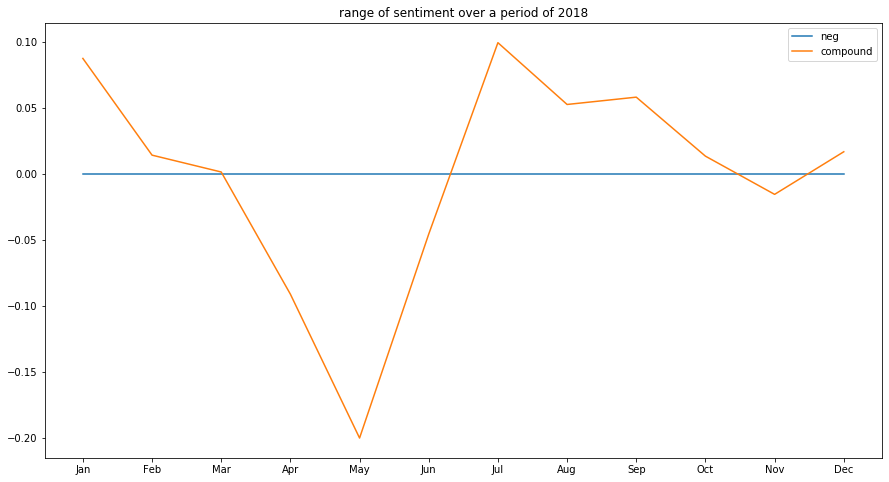

In [29]:
plt.figure(figsize=(15,8))
# dates = [str(date) for date in dates]
# plt.plot(dates,pos_sentiment,label="pos")
# plt.plot(dates,neg_sentiment,label="neg")
plt.plot(dates,np.zeros(len(dates)),label="neutral baseline")
plt.plot(dates,compound_sentiment,label="compound")
plt.title("range of sentiment over a period of 2018")
plt.legend()
plt.show()

## selecting 2018 data and seeing the sentiments of them

In [8]:
juul_2018 = juul_data.loc[(juul_data["tweetCreatedAt"] >= datetime(2018,1,1) ) & (juul_data["tweetCreatedAt"] < datetime(2018,12,31))]


### filtering news and promo users

In [16]:
classifier_dir = os.path.join(model_dir,"classifier","annotation_classifier")
svm = pickle.load(open(os.path.join(classifier_dir,"svm_tf.pkl"),"rb"))
tf_idf = pickle.load(open(os.path.join(classifier_dir,"tf_idf_vect.pkl"),"rb"))

In [17]:
X = tf_idf.transform(juul_2018["tweetText"])

In [18]:
y = (svm.predict(X))

In [19]:
y.shape

(1471336,)

In [20]:
print("regular tweets",len([ele for ele in y if ele== 2]) / len(y),":",len([ele for ele in y if ele== 2]))
print("promoters tweets",len([ele for ele in y if ele== 1]) / len(y),":",len([ele for ele in y if ele== 1]) )
print("news tweets",len([ele for ele in y if ele== 0]) / len(y),":",len([ele for ele in y if ele== 0]))

regular tweets 0.694000554597998 : 1021108
promoters tweets 0.17742990044422213 : 261059
news tweets 0.12856954495777986 : 189169


In [21]:
juul_2018["label"] = y

/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### capture regular users (max tweets of each category)

In [23]:
juul_ = pd.get_dummies(juul_2018,columns=["label"],prefix=['cat'])
juul_users_2018 = juul_.groupby(by="userID").agg({'cat_0': 'sum','cat_1':'sum','cat_2':'sum'})
juul_users_2018 = juul_users_2018.reset_index()
juul_users_2018["label"] = juul_users_2018[['cat_0','cat_1','cat_2']].idxmax(axis=1)
## sanity check
# regular tweets 1021108
(np.sum(list(juul_users_2018["cat_2"])))

1021108.0

### plotting each user in different category

regular_users 546396
promoters users 146993
news users, 113029
806418
806418


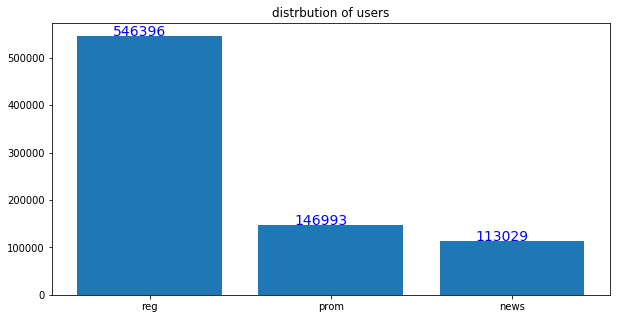

In [176]:
## no of users in each category
print("regular_users",len(juul_users_2018.loc[juul_users_2018.label == "cat_2"]))
print("promoters users",len(juul_users_2018.loc[juul_users_2018.label == "cat_1"]))
print("news users,",len(juul_users_2018.loc[juul_users_2018.label == "cat_0"]))
users_ = {"reg":len(juul_users_2018.loc[juul_users_2018.label == "cat_2"]),
 "prom":len(juul_users_2018.loc[juul_users_2018.label == "cat_1"]),
 "news":len(juul_users_2018.loc[juul_users_2018.label == "cat_0"])}

## sanity check
print(np.sum(list(users_.values())))
print(len(juul_users_2018.userID.unique()))

## plotting each user by category
fig, ax = plt.subplots(figsize=(10,5)) 
ax.set_title("distrbution of users")
ax.bar(users_.keys(),users_.values())
for idx,(key,value) in enumerate(users_.items()):
    ax.text( idx - 0.2 ,value + 0.5, value, color='blue',fontsize=14)

In [ ]:
## predicting sentiment fo users

In [95]:
def increment_dict(source,target,categories):
    for key in categories:
        if key in source:
            if key in target:
                target[key] += source[key]
            else:
                target[key] = 1
    return target

In [100]:
def normalize_dict(target,constant,categories):
    for key in categories:
        target[key] = target[key] / constant
    return target

In [40]:
## predict the sentiment of regualr users
juul_reg_users_18 = juul_users_2018.loc[juul_users_2018.label == "cat_2"]
users_18 = list(juul_reg_users_18.userID.unique())
reg_tweets_18 = juul_2018.loc[juul_2018.userID.isin(users_18)][["userID","tweetText","tweetCreatedAt"]]

In [41]:
print("reg users tweets '18",len(reg_tweets_18))
print("reg users in '18",len(reg_tweets_18.userID.unique()))

reg users tweets '18 1046205
reg users in '18 546396


In [164]:
categories = [
    "pos",
    "neg",
    "neu",
    "compound",
    ]
polarity_list= []
dates = []
start = datetime(2018,1,1)
for i in tqdm(range(12)):
    next_ = start + relativedelta(months=1)
    ## filtering data of each month
    data = juul_data.loc[(juul_data["tweetCreatedAt"] >= start ) & (juul_data["tweetCreatedAt"] < next_)]
    count = 0
    polarity_cat= {}
    for sentence in tqdm(list(data.tweetText)):
        ss = sid.polarity_scores(sentence)
        polarity_cat = increment_dict(ss,polarity_cat,categories)
        count += 1
    polarity_cat = (normalize_dict(polarity_cat,count,categories))
    polarity_list.append(polarity_cat)
    dates.append(start.strftime("%b"))
    start = next_    # reset start to point to next date

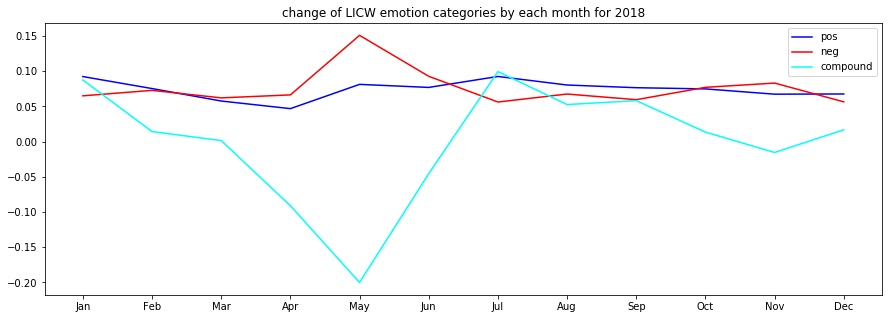

In [165]:
## vader
plt.figure(figsize=(15,5))
plt.title("change of emotion categories by each month for 2018 using vader")
categories = [
    "pos",
    "neg",
#     "neu",
    "compound",
    ]
colors = [
    "blue",
    "red",
#     "green",
    "cyan",
]
for cat,color in zip(categories,colors):
    plot_cat = []
    for emotions in polarity_list:
        plot_cat.append(emotions[cat])
    plt.plot(dates,plot_cat,label=cat,color=color)
plt.legend()
plt.show()

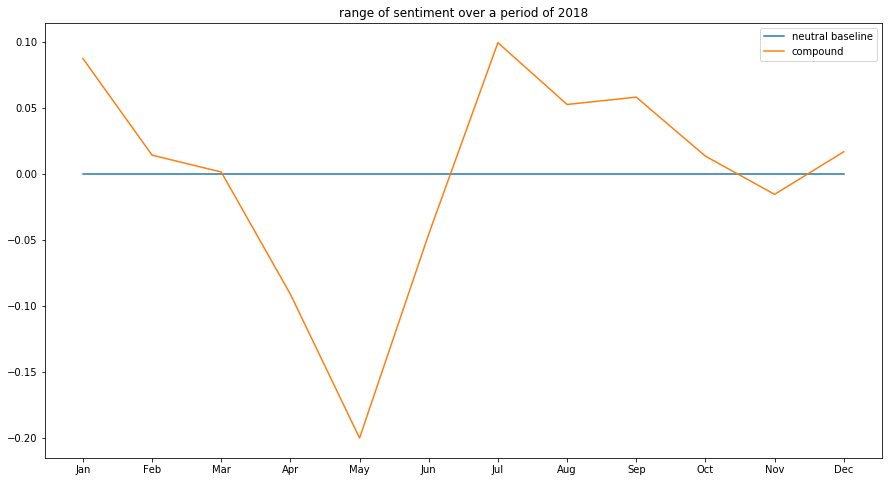

In [27]:
plt.figure(figsize=(15,8))
plt.plot(dates,np.zeros(len(dates)),label="neutral baseline")
plt.plot(dates,compound_sentiment,label="compound")
plt.title("range of sentiment over a period of 2018")
plt.legend()
plt.show()

## using Standford empath

In [98]:
from empath import Empath
lexicon = Empath()
def get_licw_categories(sentence,categories):
    data = lexicon.analyze(sentence,categories)
    return data

In [126]:
## empath categories
start = datetime(2018,1,1)
dates = []
emotions_list = []
categories = [
    "celebration",
    "cheerfulness",
    "love",
    "disgust", 
    "joy",
    "fun",
    "fashion",
    "pain",
    "positive_emotion",
    "negative_emotion"
]
# compound_sentiment = []
for i in tqdm(range(12)):
    next_ = start + relativedelta(months=1)
    data = reg_tweets_18.loc[(reg_tweets_18["tweetCreatedAt"] >= start ) & (reg_tweets_18["tweetCreatedAt"] < next_)]
    count = 0 
    emotions = {}
    for sentence in tqdm(list(data.tweetText)):
        dict_ = get_licw_categories(sentence,categories)
        emotions = increment_dict(dict_,emotions,categories)
        count += 1
    emotions = normalize_dict(emotions,count,categories)
    date = start.strftime("%b")
    emotions_list.append((date,emotions))
    start = next_

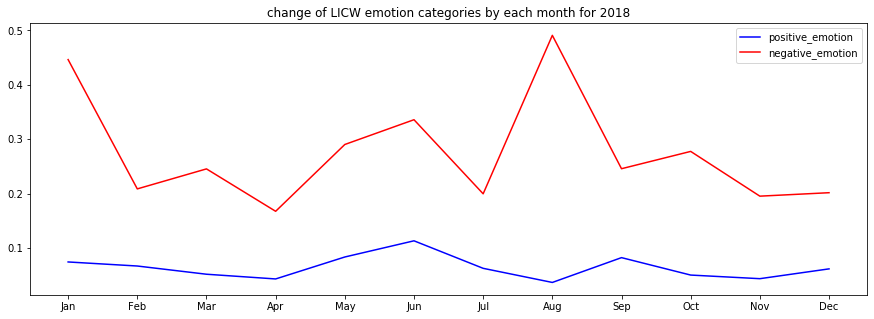

In [147]:
plt.figure(figsize=(15,5))
plt.title("change of LICW emotion categories by each month for 2018")
categories = [
    "positive_emotion",
    "negative_emotion",
#     "celebration",
#     "cheerfulness",
#     "love",
#     "disgust", 
#     "joy",
#     "fun",
#     "fashion",
#     "pain",
]
colors = [
    "blue",
    "red",
    
]
for cat,color in zip(categories,colors):
    dates = []
    plot_cat = []
    for date,emotions in emotions_list:
        plot_cat.append(emotions[cat])
        dates.append(date)
    plt.plot(dates,plot_cat,label=cat,color=color)
plt.legend()
#     plt.plot(dates,plot_cat)

In [ ]:
## plots highlight the change in sentiment in aug and apr..

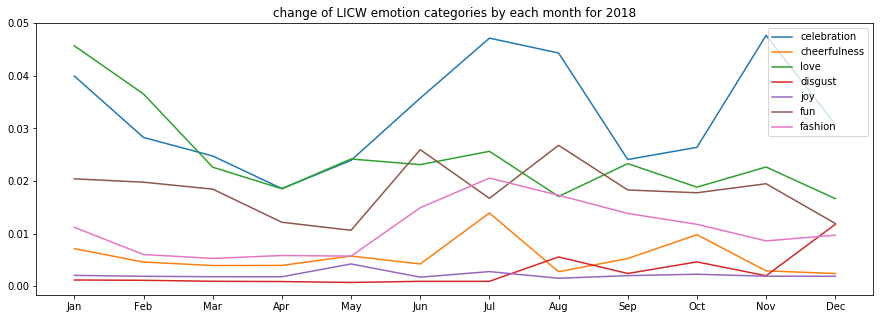

In [145]:
plt.figure(figsize=(15,5))
plt.title("change of LICW emotion categories by each month for 2018")
categories = [
    "celebration",
    "cheerfulness",
    "love",
    "disgust", 
    "joy",
    "fun",
    "fashion",
#     "pain",
#     "positive_emotion",
#     "negative_emotion"
]
for cat in categories:
    dates = []
    plot_cat = []
    for date,emotions in emotions_list:
        plot_cat.append(emotions[cat])
        dates.append(date)
    plt.plot(dates,plot_cat,label=cat)
plt.legend()

In [ ]:
## try aspect based sentiment analysis

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [188]:
doc = nlp("I love juul")
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

I nsubj love VERB []
love ROOT love VERB [I, juul]
juul dobj love VERB []


In [218]:
tweets_2018 = reg_tweets_18[["tweetText","tweetCreatedAt"]]

In [210]:
# clean_text
import re
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text)   ## remove @ mentions with author
    text = re.sub(r'(@)', "",text)             ## remove @ symbols
    text = re.sub(r'(author)',"",text)         ## remove author
    text = re.sub(r'(#)', "",text)             ## removing the hashtags signal 
    text = re.sub(r'(RT :)', "",text)         ## remove the retweet info as they dont convey any information
    text.rstrip 
    text.lstrip
    return(text)

In [219]:
from tqdm import tqdm_notebook
tqdm.pandas()
tweets_2018["clean_text"] = tweets_2018["tweetText"].progress_apply(clean_text)
tweets_2018

tweetText  \
219038   RT @redneB_: When u hit the juul too hard https://t.co/YXlYLcGoLq                                                                                                                                                        
219039   Juul’s dead staying in tonight https://t.co/xPQsXkmgL3                                                                                                                                                                   
219040   RT @Gclax5822: "These girls jus kept saying someone stole their juul and I was so confused, I thought they brought diamonds with them or so…                                                                             
219042   RT @tanamongeau: tide pods are the new juul pods                                                                                                                                                                         
219043   ...um so all of my cousins are like 14 15 16 and all of them are just like “omg we’re gonna juul tonight right” “yah and i brought fireball we’ll do shots tonight” BITCH YOU DONT EVEN HAVE YOUR LISENCE SIT DOWN LOL   
219044   RT @genericsimonn: I think sis just hit a juul https://t.co/yw1PIIRhTV                                                                                                                                                   
219045   RT @BeastCaucasian: your MCM was standing outside with his juul that's broken. he's too broke to replace it and was just breathing so the c…                                                                             
219046   RT @tanamongeau: tide pods are the new juul pods                                                                                                                                                                         
219048   *never had nicotine in their life* *buys juul bc they think it’s cool*                                                                                                                                                   
219049   RT @brasscock: Kissin the juul at midnight                                                                                                                                                                               
219050   RT @Stringbeanez: Ur wcw will leave everything except her juul in 2017                                                                                                                                                   
219051   Just saw a movie where people fought over a juul. Doesn’t get much more 2017 than that.                                                                                                                                  
219052   what if they made juul pod replacements like those Keurig cups where u can put in ur own coffee grounds                                                                                                                  
219053   what the fuck even is a juul lol                                                                                                                                                                                         
219054   RT @MattWerr: Dave Chappelle is just smackin a juul in his new special on Netflix                                                                                                                                        
219055   found a new juul pod on the floor of my juno. it’s gonna be a great NYE                                                                                                                                                  
219056   who has the juul charge                                                                                                                                                                                                  
219057   RT @ngannguyvn: BIHHH I️ FORGOT &amp; HIT MY JUUL IN FRONT OF MY MOM SHE WAS LIKE WHAT DID U JUST DO WHAT WAS THAT SMOK

In [224]:
def add_to_dict(source,key):
    if (key) in source:
        source[key] += 1
    else:
        source[key] = 1
    return source

In [ ]:
juul_verbs = dict()
for text in tqdm(list(tweets_2018["clean_text"])):
    doc = nlp(text)
    for token in doc:
        if token.text.lower() == "juul" or token.head.text == "juul":
            print(token.head.pos_,token.head.text,token.text)
            if token.head.pos_ == "VERB":   # if juul is associated with a verb
                juul_verbs = add_to_dict(juul_verbs,token.head.text)

NOUN juul the
VERB hit juul
PART ’s Juul
NOUN juul their
VERB stole juul
NOUN pods juul
NOUN juul na
VERB gon juul
NOUN juul tonight
NOUN juul a
VERB hit juul
NOUN juul his
ADP with juul
NOUN pods juul
VERB buys juul
NOUN juul the
PROPN Kissin juul
NOUN juul at
NOUN juul her
ADP except juul
NOUN juul in
NOUN juul a
ADP over juul
VERB made juul
NOUN juul a
VERB is juul
NOUN juul a
VERB smackin juul
NOUN juul in
NOUN juul a
NOUN juul new
NOUN pod juul
NOUN juul the
VERB has juul
VERB WAS JUUL
NOUN juul a
VERB has juul
NOUN juul had
NOUN juul a
VERB has juul
NOUN juul had
NOUN juul a
NOUN juul gold
NOUN juul sparkly
VERB finds juul
NOUN pods juul
NOUN pods juul
NOUN things Juul
NOUN juul my
VERB ripping juul
NOUN juul my
VERB give juul
NOUN juul my
VERB ’s juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN juul a
NOUN juul mango
VERB finish juul
NOUN pods juul
NOUN juul a
VERB using juul
NOUN juul a
VERB smoking juul
NOUN pods juul
NOUN juul the
VERB hitt

NOUN JUUL JUUL
NOUN juul the
ADP of juul
NOUN juul his
VERB miss juul
NOUN pods juul
NOUN juul my
VERB ’s juul
NOUN pods juul
NOUN juul my
VERB kiss juul
VERB found Juul
NOUN juul a
VERB checked juul
NOUN juul for
NOUN juul my
VERB hit juul
NOUN juul my
VERB kiss juul
VERB hits juul
VERB hit Juul
NOUN hit JUUL
NOUN juul my
VERB kissed juul
VERB did Juul
NOUN juul a
VERB have juul
NOUN juul in
NOUN juul first
NOUN rip juul
NOUN juul the
VERB is juul
VERB hit Juul
NOUN pods juul
NOUN pods juul
NOUN juul year
NOUN juul new
NOUN pod juul
NOUN juul my
VERB kissed juul
NOUN pods Juul
VERB WAS JUUL
NOUN juul my
VERB hit juul
NOUN juul this
ADP of juul
NOUN juul my
VERB was juul
NOUN pods juul
NOUN juul a
ADP with juul
NOUN juul in
NOUN juul and
NOUN juul 4loko
NOUN juul my
NOUN juul fourth
VERB lost juul
VERB dragged Juul
NOUN brothers JUUL
NOUN juul the
NOUN juul first
NOUN rip juul
NOUN pods juul
NOUN juul my
VERB is juul
NOUN juul her
VERB have juul
NOUN juul her
VERB give juul
NOUN juul t

NOUN juul my
ADP in juul
VERB was Juul
VERB found Juul
NOUN juul a
VERB Bought juul
NOUN juul their
VERB lose juul
NOUN juul your
VERB lose juul
NOUN pods juul
NOUN juul your
ADP in juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB kiss juul
VERB tossed Juul
VERB liked JUUL
PROPN JUUL JUUL
NOUN pods juul
NOUN juul my
VERB kiss juul
NOUN juul my
VERB lost juul
NOUN pods juul
NOUN pods juul
NOUN juul my
VERB dropped juul
NOUN juul my
VERB Lost juul
NOUN juul full
NOUN pods juul
NOUN juul full
NOUN pods juul
NOUN juul my
VERB kiss juul
NOUN juul my
VERB kiss juul
NOUN juul damn
PUNCT 🙄 juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB kiss juul
NOUN juul my
VERB 's juul
NOUN juul the
VERB quit juul
NOUN juul My
VERB fucking juul
VERB feels juul
VERB WAS JUUL
NOUN juul my
VERB kiss juul
VERB hit Juul
NOUN juul ur
VERB hit juul
NOUN juul their
VERB whips juul
NOUN juul the
VERB take juul
ADP of juul
NOUN juul his
VERB vaped juul
NOUN juul this
ADP of juul
NOUN juul this
ADP of juul
NOUN ju

NOUN juul his
ADP for juul
NOUN juul my
ADP for juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP to juul
VERB call JUUL
NOUN juul the
VERB want juul
NOUN juul my
ADP off juul
NOUN juul my
VERB give juul
NOUN juul my
VERB lose juul
NOUN juul a
NOUN juul big
NOUN juul ass
VERB Take juul
NOUN juul my
VERB offering juul
PROPN Armor juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP to juul
NOUN juul a
NOUN juul lost
ADP with juul
NOUN juul a
VERB having juul
NOUN juul at
NOUN juul a
ADP with juul
NOUN juul &
NOUN juul amp
NOUN juul my
ADP to juul
NOUN juul my
VERB lose juul
VERB hit Juul
NOUN juul my
VERB give juul
NOUN juul the
NOUN juul family
ADP of juul
NOUN bro Juul
NOUN juul you
NOUN fiends juul
NOUN juul my
VERB give juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP to juul
NOUN juul a
NOUN era juul
VERB smoking Juul
NOUN CHARGER JUUL
VERB kill Juul
NOUN juice Juul
NOUN juul the
VERB secured juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP 

ADP with Juul
NOUN pods juul
NOUN juul a
VERB smoking juul
NOUN juul in
NOUN juul my
VERB found juul
VERB ’s Juul
NOUN joke juul
NOUN juul Nice
NOUN juul juul
NOUN juul ?
NOUN juul avocado
NOUN pods juul
PROPN 😉 Juul
VERB is Juul
NOUN juul you
NOUN fiends juul
NOUN juul Nice
NOUN juul juul
NOUN juul ?
NOUN juul a
VERB hitting juul
NOUN juul my
NOUN vapes juul
NOUN teams Juul
NOUN juul my
NOUN juul third
ADP On juul
ADP of juul
NOUN juul my
VERB sharing juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB s juul
NOUN juul my
VERB lose juul
NOUN juul my
VERB stole juul
NOUN juul his
VERB smoking juul
NOUN juul  
NOUN juul juul
NOUN juul for
NOUN juul you
NOUN fiends juul
NOUN juul Dalaina
VERB stole juul
NOUN juul you
NOUN fiends juul
NOUN pods juul
NOUN pods juul
VERB leaving juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB stole juul
NOUN juul my
VERB kiss juul
VERB buy Juul
NOUN juul you
NOUN fiends juul
NOUN juul a
VERB hitting juul
NOUN juul you
NOUN fiends juul
NOUN juul my
VERB br

NOUN juul my
VERB ’s juul
NOUN juul her
ADP except juul
NOUN juul in
NOUN juul his
VERB hits juul
NOUN juul my
NOUN juul brothers
VERB lost juul
NOUN juul ,
NOUN juul socks
NOUN pods juul
NOUN juul a
NOUN juul new
VERB buying juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP to juul
ADP for Juul
VERB cartridges Juul
ADJ friendly Juul
NOUN juul my
VERB take juul
NOUN juul a
VERB own juul
NOUN juul you
NOUN fiends juul
NOUN juul college
ADP in juul
NOUN juul college
ADP in juul
NOUN juul my
ADP in juul
NOUN juul the
ADP on juul
NOUN juul a
VERB smoking juul
NOUN juul in
NOUN juul my
VERB stole juul
VERB WAS JUUL
NOUN juul my
VERB give juul
PROPN JUUL JUUL
NOUN juul you
NOUN fiends juul
NOUN pods juul
NOUN juul my
VERB dropped juul
VERB pass JUUL
NOUN pods juul
NOUN juul my
NOUN something juul
PART ’s Juul
NOUN pods juul
NOUN juul my
VERB is juul
NOUN company juul
NOUN juul brand
NOUN juul new
NOUN device juul
VERB leave juul
NOUN juul my
VERB miss juul
NOUN juul my
VERB ’s juul
NOUN juul

NOUN juul my
VERB stole juul
NOUN juul my
ADP of juul
NOUN juul you
NOUN fiends juul
VERB stole JUUL
NOUN juul the
VERB drop juul
NOUN juul &
NOUN juul amp
NOUN juul the
VERB make juul
NOUN juul that
NOUN girls juul
NOUN juul in
NOUN CHARGER JUUL
NOUN pods juul
NOUN juul my
VERB was juul
NOUN juul my
VERB dropped juul
NOUN juul year
NOUN juul we
NOUN juul juul
NOUN juul you
NOUN fiends juul
NOUN juul Leaving
NOUN juul we
NOUN juul only
NOUN juul juul
NOUN juul now
NOUN juul a
VERB is juul
VERB smoke Juul
PROPN Restock Juul
NOUN juul juul
NOUN juul vape
NOUN juul zootiesvapors
NOUN juul it
NOUN juul the
VERB roll juul
NOUN juul right
NOUN juul wake
VERB call JUUL
VERB juul I
VERB juul ’ll
VERB juul definitely
VERB ’m juul
NOUN juul a
VERB have juul
NOUN juul NeedOne
NOUN juul my
VERB hit juul
VERB smoked Juul
VERB smoking Juul
VERB kill Juul
NOUN juul you
NOUN fiends juul
VERB find Juul
NOUN juul their
ADP on juul
NOUN juul and
NOUN juul idk
NOUN juul a
VERB hitting juul
NOUN juul a
VER

NOUN rapper Juul
NOUN habit JUUL
NOUN pods juul
VERB hits juul
ADP with juul
NOUN juul a
NOUN juul "
ADP like juul
NOUN juul "
VERB handing juul
NOUN juul your
VERB loose juul
NOUN juul a
NOUN juul "
ADP like juul
NOUN juul "
VERB hitting Juul
NOUN juul her
ADP except juul
NOUN juul in
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN juul my
VERB buy juul
NOUN pods juul
VERB handing juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN juul my
VERB fucking juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN PODS JUUL
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN juul a
VERB sold juul
NOUN pods juul
NOUN area Juul
NOUN seati

NOUN juul a
VERB ripping juul
NOUN juul on
NOUN juul one
VERB rip juul
NOUN pods juul
NOUN pods juul
NOUN SHIRT JUUL
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN fiends juul
NOUN pods juul
NOUN pods juul
NOUN juul my
VERB loses juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN juul my
VERB give juul
NOUN juul my
VERB give juul
NOUN pods juul
ADP onto Juul
NOUN pods juul
NOUN juul a
VERB bought juul
VERB leave juul
NOUN pods juul
NOUN pods juul
NOUN pods Juul
NOUN pods juul
NOUN pods juul
NOUN charger Juul
NOUN pods juul
NOUN juul to
ADJ cool juul
NOUN juul in
NOUN cartridge Juul
NOUN juul her
NOUN hands juul
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN juul A
VERB is juul
NOUN pods juul
NOUN pods juul
NOUN juul a
VERB waterproof juul
NOUN juul ’m
VERB buy Juul
NOUN juul mint
NOUN pods juul
NOUN juul his
VERB hitting juul
NOUN juul their
VERB hitting juul
NOUN juul his
VERB hitting juul
NOUN juul a
ADP like juul
NOUN pods juul
VERB hit Juul
NOUN pods juul
NOUN juul a
VERB ri

NOUN pods juul
NOUN juul a
VERB charge juul
NOUN juul with
NOUN juul my
VERB drop juul
NOUN juul my
VERB has juul
NOUN juul a
NOUN idea juul
NOUN juul is
NOUN juul my
NOUN juul fucking
VERB ’s juul
NOUN action JUUL
NOUN juul a
ADP with juul
NOUN juul my
VERB attacking juul
NOUN juul my
VERB s juul
NOUN juul my
VERB broke juul
NOUN juul my
VERB stole juul
VERB Leaving juul
NOUN juul sharing
NOUN pods juul
NOUN juul a
VERB buy juul
NOUN phone juul
NOUN juul tobacco
NOUN girl juul
NOUN juul a
NOUN juul mint
VERB are juul
NOUN juul my
VERB name juul
NOUN juul this
NOUN juul fucking
VERB buy juul
NOUN juul for
NOUN juul my
NOUN charger juul
NOUN juul the
ADP of juul
NOUN pods juul
VERB created JUUL
NOUN juul that
VERB hitting juul
NOUN juul her
VERB threw juul
NOUN juul my
VERB stole juul
NOUN juul A
NOUN juul juul
NOUN juul and
NOUN juul card
VERB lost Juul
VERB is Juul
VERB using Juul
ADP of Juul
PROPN Juul Juul
VERB WAS JUUL
NOUN pods juul
NOUN juul tobacco
NOUN girl juul
NOUN juul a
NOU

NOUN pods juul
VERB shoot Juul
NOUN juul that
NOUN juul fuckin
NOUN juul ass
NOUN slap juul
NOUN juul out
NOUN juul a
NOUN juul mint
VERB hit juul
NOUN juul and
NOUN juul a
NOUN juul cucumber
NOUN juul juul
NOUN baby juul
NOUN pods juul
VERB leave juul
NOUN juul my
VERB charge juul
VERB leave Juul
NOUN juul tobacco
NOUN girl juul
NOUN juul a
NOUN juul mint
VERB are juul
NOUN juul the
VERB found juul
NOUN juul thought
NOUN juul tobacco
NOUN girl juul
NOUN juul a
NOUN juul mint
VERB are juul
NOUN juul a
ADP about juul
NOUN juul as
NOUN juul my
ADP for juul
VERB see Juul
NOUN juul a
VERB want juul
ADJ my juul
NOUN juul i
NOUN juul juul
NOUN juul now
NOUN juul y
NOUN juul the
NOUN juul biggest
VERB take juul
NOUN juul a
VERB has juul
NOUN juul idk
NOUN pods juul
NOUN juul tobacco
NOUN girl juul
NOUN juul a
NOUN juul mint
VERB are juul
NOUN juul a
ADP with juul
NOUN juul in
NOUN pods juul
PROPN January Juul
NOUN niggas juul
NOUN juul that
VERB understand juul
NOUN juul my
VERB find juul
NOU

VERB is Juul
NOUN pods juul
NOUN pods juul
NOUN juul ur
VERB get juul
VERB do Juul
NOUN pods juul
NOUN pods Juul
NOUN pods juul
NOUN juul a
VERB smoking juul
NOUN juul in
NOUN juul my
VERB find juul
NOUN juul a
VERB buy juul
NOUN juul an
NOUN juul empty
ADP like juul
NOUN juul my
ADP on juul
VERB hit JUUL
NOUN juul the
VERB rips juul
NOUN juul  
NOUN flavor juul
VERB hit Juul
NOUN pods juul
VERB Is Juul
NOUN juul my
VERB get juul
ADP in juul
NOUN juul  
NOUN juul on
NOUN juul :
NOUN juul fellas
NOUN juul my
ADP from juul
NOUN juul his
VERB hitting juul
NOUN juul your
VERB broke juul
VERB going juul
NOUN juul in
NOUN juul ,
NOUN juul doing
VERB gets Juul
NOUN pods juul
NOUN juul a
VERB hitting juul
NOUN pods juul
NOUN juul my
VERB ’s juul
VERB HITTING JUUL
ADP like Juul
NOUN pods juul
NOUN pods juul
PROPN Charger Juul
VERB tearing Juul
NOUN juul the
PART off juul
VERB takes Juul
VERB gets Juul
NOUN juul but
NOUN juul not
NOUN juul the
NOUN 😤 juul
NOUN pods juul
NOUN pods juul
NOUN juul 

NOUN juul my
VERB brought juul
NOUN juul AND
NOUN juul charger
NOUN juul a
VERB bought juul
NOUN thing juul
NOUN juul ur
PROPN Leave juul
NOUN juul the
NOUN crackle juul
NOUN juul a
VERB bought juul
NOUN juul my
VERB loose juul
VERB hitting Juul
NOUN cloud juul
ADP of Juul
PROPN Pod Juul
ADP of Juul
ADP outside Juul
NOUN juul my
NOUN pods juul
NOUN juul this
ADP on juul
NOUN juul a
NOUN pod juul
NOUN juul BBQ
NOUN juul flavor
NOUN pods juul
VERB Having Juul
NOUN juul my
VERB Got juul
NOUN juul the
ADP for juul
NOUN bro Juul
VERB Having Juul
NOUN juul ur
PROPN Leave juul
NOUN juul the
VERB is juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP to juul
NOUN juul a
VERB sell juul
NOUN juul us
VERB let juul
NOUN juul lovers
NOUN juul live
NOUN juul ,
VERB says Juul
NOUN juul a
VERB has juul
NOUN juul makes
NOUN guy JUUL
VERB has JUUL
NOUN juul their
ADP with juul
VERB lost Juul
VERB stole Juul
NOUN juul her
ADP with juul
NOUN juul in
NOUN juul my
VERB shake juul
NOUN juul my
VERB stole juul


NOUN juul a
VERB makes juul
NOUN juul I
NOUN juul 'd
NOUN juul ever
NOUN reason juul
NOUN pods juul
NOUN juul the
VERB hide juul
NOUN absence Juul
NOUN juul her
VERB passed juul
NOUN juul ur
PROPN Leave juul
VERB love Juul
NOUN juul ur
PROPN Leave juul
VERB juul Them
VERB juul juul
VERB juul things
PROPN Taos juul
NOUN juul my
VERB have juul
NOUN juul be
VERB hit juul
NOUN juul like
VERB has Juul
NOUN juul you
NOUN fiends juul
NOUN juul my
VERB came juul
NOUN juul their
ADP with juul
NOUN juul your
VERB was juul
NOUN pods juul
NOUN juul for
NOUN juul ur
VERB waiting juul
NOUN juul to
NOUN juul the
NOUN juul red
VERB getting juul
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN juul a
VERB is juul
NOUN juul My
VERB lost juul
NOUN chargers juul
NOUN juul you
NOUN fiends juul
ADP for JUUL
NOUN juul classic
NOUN juul menthol
NOUN pod juul
NOUN juul a
ADP with juul
NOUN pods Juul
ADP of juul
NOUN juul  
NOUN flavor juul
NOUN pods juul
NOUN kanger juul
VERB juul if
VERB juul we
VERB start juul

NOUN juul the
ADP for juul
NOUN juul ...
NOUN juul ’s
NOUN juul a
VERB own juul
NOUN juul a
VERB ripped juul
NOUN juul in
PROPN Juul Juul
NOUN charger Juul
NOUN juul ur
PROPN Leave juul
NOUN juul your
VERB was juul
VERB buy Juul
PROPN Juul Juul
PROPN Juul Juul
NOUN juul ur
PROPN Leave juul
NOUN juul a
VERB bought juul
NOUN juul and
NOUN juul 2,000
NOUN juul worth
NOUN juul your
VERB was juul
PROPN Juul Juul
PROPN Juul Juul
NOUN juul the
VERB kill juul
NOUN juice juul
VERB rip Juul
NOUN juul my
VERB having juul
NOUN juul with
NOUN juul a
NOUN juul flavored
VERB is juul
NOUN juul your
VERB was juul
NOUN juul my
ADP for juul
NOUN owner juul
NOUN juul my
VERB seen juul
NOUN juul your
VERB was juul
NOUN juul my
VERB is juul
NOUN juul a
NOUN juul VUITTON
NOUN skin juul
NOUN juul your
VERB was juul
NOUN juul a
VERB lost juul
NOUN juul and
NOUN juul AirPods
NOUN juul your
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul a
VERB have j

NOUN juul a
VERB hitting juul
NOUN juul the
VERB drop juul
NOUN juul &
NOUN juul amp
NOUN pods juul
NOUN pods Juul
NOUN juul your
VERB was juul
NOUN juul my
ADP for juul
NOUN owner juul
NOUN juul my
VERB seen juul
VERB bought Juul
NOUN juul a
NOUN juul fresh
ADP like juul
VERB is juul
NOUN nicotine Juul
NOUN juul a
VERB have juul
NOUN neva juul
NOUN juul my
VERB take juul
NOUN juul NyQuil
NOUN concept juul
NOUN juul pods
NOUN juul NyQuil
NOUN pods juul
NOUN juul a
VERB ripping juul
NOUN juul in
NOUN juul my
VERB take juul
NOUN pods juul
NOUN juul your
VERB was juul
NOUN juul the
ADP to juul
ADP to juul
NOUN juul and
NOUN juul bean
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB WAS JUUL
NOUN wave juul
NOUN juul your
VERB was juul
NOUN juul ur
PROPN Leave juul
NOUN juul this
ADP of juul
NOUN daddy juul
NOUN juul bout
NOUN pods juul
NOUN juul my
VERB is juul
VERB ripping Juul
NOUN juul the
VERB hittin juul
VERB holding Juul
PROPN ’s Juul
VERB pods juul
NOUN juul my
VERB is

VERB juul Do
VERB juul n't
VERB juul juul
VERB juul ╱
VERB juul ┏
VERB hitting Juul
NOUN juul your
VERB was juul
NOUN juul my
VERB hold juul
VERB takes Juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul his
VERB stole juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB be Juul
VERB getting Juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN pods juul
NOUN juul My
VERB woke juul
NOUN juul a
ADP like juul
NOUN juul  
NOUN juul 4
PROPN JUUL JUUL
VERB juul who
VERB juul does
VERB juul n’t
NOUN someone juul
VERB juul you
VERB Find Juul
NOUN pods juul
ADP with Juul
NOUN juul ur
PROPN Leave juul
VERB ripped Juul
NOUN pods juul
NOUN juul your
VERB was juul
VERB are juul
NOUN juul a
VERB has juul
NOUN juul with
NOUN juul on
NOUN juul their
ADP with juul
VERB be Juul
NOUN juul ur
PROPN Leave juul
NOUN juul the
VERB saw juul
NOUN juul a
VERB smoking juul
NOUN juul a
VERB got juul
VERB let Juul
NOUN juul your
VERB was juul
VERB be Juul
NOUN juu

NOUN juul the
NOUN juul whole
VERB throw juul
NOUN juul your
VERB was juul
VERB are Juul
NOUN juul the
VERB is juul
PROPN JUUL JUUL
NOUN juul two
VERB Hit juul
NOUN juul your
VERB was juul
ADP with juul
NOUN juul a
ADP like juul
NOUN juul or
NOUN juul something
NOUN juul your
VERB was juul
ADP of juul
NOUN juul his
VERB puffs juul
NOUN juul your
VERB was juul
NOUN juul the
VERB ripped juul
NOUN juul your
VERB was juul
NOUN juul a
VERB having juul
NOUN juul your
VERB was juul
ADP of juul
NOUN juul my
VERB gave juul
NOUN juul your
VERB was juul
NOUN juul a
VERB bought juul
NOUN cartel juul
NOUN princess juul
NOUN juul your
VERB was juul
VERB buy Juul
NOUN juul a
VERB buying juul
NOUN juul the
ADP to juul
NOUN juul a
VERB holding juul
NOUN juul in
NOUN juul my
ADP with juul
NOUN juul a
VERB get juul
NOUN juul a
VERB trying juul
NOUN juul for
VERB buy JUUL
PROPN Juul Juul
PROPN Juul Juul
NOUN juul a
VERB having juul
PROPN Pimp Juul
NOUN juul nice
ADJ bro juul
NOUN juul smoke
VERB drink juu

NOUN juul your
VERB was juul
VERB blow juul
VERB be Juul
NOUN juul a
ADP with juul
NOUN juul a
VERB buy juul
NOUN pods juul
VERB put juul
VERB juul down
VERB juul in
NOUN juul the
NOUN juul fucking
VERB hit juul
NOUN juul a
ADP on juul
VERB stole Juul
NOUN juul My
VERB crawled juul
VERB juul you
VERB juul do
VERB juul n’t
ADJ sure juul
VERB juul and
VERB juul drive
NOUN juul My
VERB exploded juul
NOUN juul my
VERB lose juul
VERB be Juul
NOUN juul the
ADP of juul
NOUN juul my
VERB stole juul
NOUN juul this
VERB is juul
NOUN juul a
NOUN Fucc juul
VERB encrusted Juul
NOUN juul your
VERB hit juul
NOUN juul your
VERB was juul
NOUN juul a
VERB has juul
NOUN juul a
ADJ fuck juul
NOUN juul ,
NOUN juul phix
NOUN juul a
VERB ripping juul
NOUN juul on
NOUN juul a
ADP of juul
NOUN juul your
VERB was juul
VERB juul Do
VERB juul n’t
VERB juul juul
VERB juul and
VERB juul drive
NOUN juul '
NOUN juul juul
NOUN juul '
NOUN juul ?
NOUN juul ?
NOUN juul your
VERB was juul
NOUN pods juul
NOUN juul your
VE

NOUN juul your
VERB was juul
NOUN juul when
NOUN juul me
NOUN juul to
NOUN juul juul
NOUN juul together
NOUN juul got
NOUN juul my
VERB hit juul
NOUN juul the
NOUN pod juul
ADP of Juul
ADP with Juul
NOUN juul the
VERB Hit juul
NOUN juul her
VERB is juul
NOUN juul your
VERB was juul
NOUN juul a
ADP like juul
NOUN juul or
NOUN juul something
NOUN juul your
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul on
NOUN juul your
VERB was juul
NOUN juul favorite
NOUN flavor juul
PROPN Netflix Juul
NOUN juul the
VERB gave juul
NOUN juul pod
ADP of Juul
NOUN juul your
VERB was juul
VERB been juul
VERB do Juul
VERB chill juul
NOUN juul with
VERB juul Do
VERB juul n’t
VERB break juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul one
NOUN juul whole
ADP through juul
NOUN pods juul
NOUN juul my
NOUN app juul
VERB GET JUUL
NOUN juul my
NOUN taste juul
NOUN rn Juul
NOUN juul your
VERB was juul
VERB have JUUL
NOUN juul the
ADP for juul
NOUN juul and
NOUN juul hands
VERB be Juul
V

NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB bought Juul
NOUN juul your
VERB was juul
NOUN juul a
VERB Get juul
NOUN juul your
VERB was juul
NOUN juul my
VERB clutching juul
NOUN juul like
NOUN juul your
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul on
NOUN pods Juul
NOUN juul your
VERB was juul
NOUN pod juul
NOUN juul my
VERB hitting juul
NOUN juul your
VERB was juul
NOUN withdrawals juul
NOUN juul their
ADP with juul
NOUN juul your
VERB was juul
NOUN juul my
VERB clutching juul
NOUN juul like
NOUN juul my
VERB hitting juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
NOUN taste juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB bought Juul
VERB bought Juul
NOUN juul your
VERB was juul
NOUN juul I
NOUN juul only
NOUN juul juul
NOUN juul on
NOUN juul your
VERB was juul
NOUN juul

NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN thing Juul
NOUN juul a
VERB buy juul
NOUN juul your
VERB lose juul
NOUN juul my
VERB had juul
NOUN juul for
NOUN pods juul
PROPN Pods Juul
NOUN juul to
VERB tries juul
VERB be Juul
NOUN juul your
VERB was juul
VERB deliver juul
NOUN juul your
VERB was juul
NOUN juul my
VERB smoked juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB hit JUUL
NOUN juul your
VERB was juul
NOUN cracks juul
NOUN juul your
VERB was juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul a
ADP to juul
NOUN juul   
NOUN pods juul
NOUN juul your
VERB was juul
NOUN juul ur
VERB hit juul
NOUN juul another
VERB order juul
NOUN pods juul
NOUN pods juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul people
VERB rip juul
NOUN juul a
VERB own juul
NOUN juul my
ADP on juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was

NOUN juul your
VERB was juul
NOUN owner juul
NOUN juul my
VERB seen juul
NOUN juul his
VERB forgets juul
NOUN juul your
VERB was juul
NOUN addiction juul
NOUN juul a
VERB hitting juul
NOUN juul my
ADP on juul
NOUN juul the
VERB hit juul
NOUN juul on
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB juul You
VERB juul ca
VERB juul n’t
VERB juul just
VERB juul juul
VERB juul away
VERB juul problems
NOUN juul a
VERB bought juul
NOUN juul for
PROPN HIT JUUL
NOUN juul a
VERB has juul
NOUN juul a
VERB got juul
NOUN juul a
VERB hit juul
NOUN juul a
VERB bought juul
NOUN juul for
NOUN thing Juul
NOUN juul your
VERB was juul
NOUN juul my
ADP with juul
NOUN juul a
VERB bought juul
NOUN juul for
NOUN juul who
NOUN guys juul
NOUN juul a
VERB bought juul
NOUN juul for
NOUN juul my
VERB buy juul
NOUN juul a
VERB getting juul
NOUN juul the
VERB became juul
NOUN pods JUUL
NOUN juul your
VERB was juul
NOUN juul my
VERB lose juul
NOUN juul his
VERB forgets juul
NOUN juul that
VERB going juu

ADP with juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul a
VERB hit juul
NOUN juul my
VERB find juul
NOUN juul the
VERB hitting juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
VERB is juul
NOUN juul my
VERB eat juul
NOUN pod juul
NOUN juul a
ADP to juul
NOUN juul VAPE
VERB is Juul
NOUN juul the
NOUN juul menthol
NOUN pods juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul a
VERB got juul
NOUN juul bc
NOUN juul your
VERB was juul
NOUN juul her
VERB flushed juul
NOUN juul the
VERB do juul
NOUN juul my
ADP of juul
NOUN juul the
VERB hit juul
NOUN juul your
VERB was juul
ADP for juul
NOUN juul a
VERB owns juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul her
VERB is juul
NOUN juul the
VERB hit juul
NOUN juul the
NOUN juul juul
NOUN juul your
VERB was juul
VERB gotten Juul
NOUN juul your
VERB was juul
NOUN juul a
VERB bought juul
PROPN US JUUL
NOUN juul a
NOUN juul free
NOUN case juul
NOUN juul

ADP on juul
NOUN juul your
VERB was juul
VERB ripping Juul
NOUN juul empty
NOUN pods juul
NOUN juul my
VERB hit juul
NOUN juul in
VERB is Juul
ADP than Juul
NOUN pods juul
NOUN juul my
VERB want juul
NOUN juul I
NOUN juul 'd
NOUN juul ever
NOUN reason juul
NOUN pods juul
NOUN juul your
VERB was juul
NOUN juul a
NOUN juul true
VERB 's juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul a
VERB owns juul
NOUN pod Juul
NOUN juul their
ADP with juul
NOUN juul USB
ADJ your juul
NOUN juul your
VERB was juul
VERB lose Juul
NOUN juul your
VERB was juul
NOUN juul a
VERB is juul
NOUN juul a
NOUN juul random
NOUN charger juul
NOUN flavor juul
NOUN juul your
VERB was juul
NOUN juul a
ADP with juul
NOUN pods juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
VERB lost juul
NOUN pens juul
NOUN juul Ally
ADP of juul
NOUN juul your
VERB was juul
NOUN juul The
NOUN juul juul
NOUN juul found
NOUN pods 

NOUN juul a
VERB get juul
NOUN juul in
NOUN juul a
VERB ghost juul
NOUN juul my
ADP with juul
NOUN juul your
VERB was juul
NOUN juul a
VERB hit juul
NOUN juul your
VERB was juul
NOUN juul a
VERB bought juul
NOUN juul for
NOUN juul your
VERB was juul
NOUN juul his
VERB hit juul
NOUN fuck Juul
NOUN juul a
VERB tried juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN pods juul
VERB HAS JUUL
NOUN juul your
VERB was juul
NOUN juul a
VERB hit juul
NOUN charger juul
NOUN juul a
VERB have juul
NOUN juul my
ADP on juul
NOUN juul that
DET All juul
NOUN juul ’s
NOUN juul the
NOUN pods juul
NOUN juul your
VERB was juul
NOUN juul i
NOUN time juul
ADP without Juul
NOUN juul my
VERB lost juul
NOUN juul my
NOUN juul fourth
VERB lost juul
NOUN juul the
VERB Fuck juul
NOUN juul 2018
NOUN juul your
VERB was juul
NOUN juul i
NOUN time juul
NOUN juul my
VERB 's juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul the
NOUN juul first
VERB is juul
NOUN juul hit
VERB lost 

VERB SEEN JUUL
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
VERB buy juul
NOUN juul the
NOUN juul mint
VERB hits juul
NOUN juul the
VERB hitting juul
NOUN juul 2
NOUN juul your
VERB was juul
NOUN juul ca
NOUN juul n’t
NOUN juul even
VERB come juul
NOUN juul anymore
NOUN juul my
ADP for juul
VERB LOST JUUL
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB WAS JUUL
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul your
VERB was juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
VERB have Juul
NOUN pods juul
VERB ’s Juul
NOUN juul your
VERB was juul
VERB WAS JUUL
ADP without Juul
NOUN juul your
VERB was juul
NOUN juul my
VERB love juul
NOUN pen Juul
NOUN juul another
VERB get juul
NOUN juul this
VERB got juul
NOUN juul his
VERB hit juul
NOUN juul in
VERB WAS JUUL
NOUN juul a
VERB bought juul
NOUN juul for
NOUN juul your
VERB was juul
VERB bought JUUL
NOUN

NOUN juul your
VERB was juul
NOUN juul a
VERB smoke juul
NOUN juul a
ADP without juul
NOUN juul your
VERB was juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul the
VERB pass juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul a
NOUN pod juul
NOUN juul your
VERB was juul
NOUN gang juul
NOUN juul your
VERB was juul
NOUN juul the
ADP of juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul a
VERB owns juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
VERB hit juul
NOUN juul your
VERB was juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul My
VERB is juul
NOUN juul that
NOUN juul first
NOUN rip juul
NOUN juu

NOUN life juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB is JUUL
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul a
NOUN juul full
VERB stole juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB juul He
VERB juul can
VERB juul juul
VERB juul all
VERB juul .
NOUN juul a
VERB is juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul your
VERB was juul
NOUN juul my
VERB found juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juul
NOUN juul the
ADP against juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul supreme
NOUN juul x
NOUN drop juul
VERB smoking juul
NOUN juul things
NOUN juul the
VERB hit juul
NOUN juul proud
NOUN 😣 juul
VERB find Juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was ju

NOUN phix juul
NOUN juul little
NOUN thing juul
NOUN juul my
ADP with juul
NOUN juul favorite
NOUN flavor juul
NOUN juul that
ADP on juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul my
ADP of juul
NOUN juul your
VERB was juul
NOUN juul my
VERB hitting juul
VERB smoking Juul
NOUN phix juul
NOUN juul your
VERB was juul
NOUN juul your
ADP of juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul the
VERB hit juul
NOUN juul my
NOUN juul new
ADV aka juul
NOUN pods juul
NOUN juul cucumber
NOUN pod juul
VERB was JUUL
NOUN juul that
ADP on juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul a
VERB buy juul
VERB ’s Juul
NOUN juul your
VERB keep juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul the
VERB is juul
NOUN juul a
VERB buy juul
NOUN life Juul
NOUN juul your
ADP of juul
NOUN things juul
NOUN juul your
ADP of juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’

NOUN juul your
VERB was juul
VERB hitting Juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN vapor Juul
NOUN juul a
VERB getting juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul the
VERB was juul
VERB Find JUUL
NOUN juul your
VERB was juul
ADP ta juul
NOUN juul a
VERB hitting juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
ADP for Juul
NOUN juul cucumber
NOUN pod juul
NOUN juul the
ADP for juul
NOUN juul your
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN pods juul
NOUN juul your
VERB was juul
VERB Leave JUUL
NOUN juul ur
NOUN juul mint
NOUN pod juul
VERB Lost Juul
NOUN juul my
VERB hanging juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN pods Juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juu

NOUN juul your
VERB was juul
NOUN juul a
VERB own juul
VERB showed Juul
NOUN juul a
VERB own juul
NOUN juul your
VERB was juul
NOUN pods Juul
NOUN juul my
NOUN juul first
VERB giving juul
NOUN juul a
ADP without juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB hit juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
VERB gon Juul
NOUN juul your
VERB was juul
NOUN juul my
VERB rip juul
NOUN juul an
NOUN juul entire
NOUN pod juul
NOUN juul ya
ADP with juul
NOUN graveyard Juul
NOUN juul my
VERB find juul
VERB was JUUL
NOUN juul your
VERB was juul
ADP on Juul
NOUN juul a
VERB got juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul My
VERB fell juul
NOUN juul your
VERB was juul
NOUN juul the
VERB find juul
NOUN juul your
VERB was juul
NOUN juul a
VERB have juul
NOUN wallet Juul
NOUN juul my
VERB rip juul
NOUN juul my
VERB cheifing juul
NOUN juul a
VERB owns juul
NOUN juul a
VERB buy juul
NOUN juul cucumber
N

NOUN juul a
VERB own juul
NOUN juul to
VERB breathe juul
NOUN juul your
NOUN addiction juul
NOUN juul this
VERB is juul
NOUN juul a
VERB is juul
NOUN juul mango
NOUN pod juul
NOUN juul her
VERB hit juul
VERB was JUUL
NOUN juul cucumber
NOUN pod juul
NOUN juul my
VERB be juul
NOUN juul your
VERB was juul
VERB COME JUUL
NOUN juul your
VERB was juul
NOUN juul the
ADP on juul
NOUN juul cucumber
NOUN pod juul
ADP for Juul
VERB sold JUUL
NOUN juul your
VERB was juul
NOUN juul my
VERB lost juul
NOUN juul cucumber
NOUN pod juul
NOUN juul a
VERB owns juul
NOUN pods juul
NOUN juul my
VERB get juul
NOUN juul in
NOUN juul this
VERB is juul
NOUN juul a
VERB been juul
NOUN juul rip
NOUN college juul
NOUN pods Juul
NOUN juul cucumber
NOUN pod juul
NOUN juul the
NOUN juul average
VERB is juul
NOUN juul the
NOUN juul average
VERB is juul
NOUN juul the
VERB hitting juul
NOUN juul in
NOUN juul cucumber
NOUN pod juul
NOUN juul unwept
NOUN juul slabr
NOUN juul juul
NOUN juul and
NOUN juul genesy
NOUN juul 

NOUN juul my
VERB hitting juul
NOUN juul in
NOUN juul my
VERB ’s juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul Rip
NOUN ia juul
NOUN juul a
VERB getting juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN pods juul
NOUN juul their
VERB give juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN juul a
VERB put juul
VERB juul so
VERB juul I
VERB juul can
VERB juul juul
VERB juul on
NOUN fad juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juul
NOUN fortnite juul
NOUN juul your
VERB was juul
NOUN juul another
NOUN day juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul my
PROPN Bitch juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN juul t
NOUN flavor juul
NOUN juul my
VERB rip juul
NOUN juul the
VERB used juul
NOUN pods juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOU

CCONJ but juul
NOUN juul a
VERB hits juul
CCONJ but juul
NOUN juul an
NOUN juul extra
NOUN pod juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul The
VERB is juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul an
NOUN juul extra
NOUN pod juul
NOUN pods juul
NOUN juul a
VERB using juul
NOUN juul in
NOUN juul an
NOUN juul extra
NOUN pod juul
NOUN juul an
NOUN juul extra
NOUN pod juul
VERB enjoying Juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul your
VERB was juul
NOUN juul an
NOUN juul extra
NOUN pod juul
NOUN juul a
VERB hits juul
NOUN juul your
VERB was juul
CCONJ but juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul a
VERB own juul
NOUN juul a
VERB own juul
VERB smoking juul
NOUN juul smoking
NOUN juul your
VERB was juul
NOUN pods juul
NOUN juul your
VERB was juul
VERB is Juul
NOUN juul your
VERB was juul
NOUN mirror

NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
ADP to juul
NOUN juul your
VERB hitting juul
NOUN juul and
NOUN juul heir
VERB hit juul
NOUN juul this
VERB buy juul
VERB ’s JUUL
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
VERB refill JUUL
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN switch juul
NOUN juul ,
NOUN juul and
NOUN juul girl
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN juul her
NOUN juul fucking
VERB pulled juul
NOUN juul in
NOUN fortnite juul
NOUN juul My
VERB making juul
NOUN juul your
VERB get juul
NOUN juul cucumber
NOUN pod juul
NOUN phix juul
NOUN juul a
VERB have juul
NOUN juul your
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN juul a
NOUN juul fucking
ADP on juul
NOUN juul a
VERB have juul
NOUN juul your
VERB was juul
NOUN juul my
VERB ’s juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juul
VERB forgot Juul
NOUN juul

NOUN juul a
VERB hitting juul
NOUN juul on
NOUN juul your
VERB was juul
PROPN Breakdown Juul
NOUN juul your
VERB was juul
PROPN Breakdown Juul
NOUN juul my
VERB is juul
VERB was Juul
VERB smoking juul
NOUN juul my
VERB is juul
NOUN factory Juul
VERB picked Juul
NOUN juul the
VERB ripped juul
VERB is juul
NOUN juul A
NOUN juul juul
NOUN juul …
NOUN juul a
VERB owned juul
NOUN juul My
VERB said juul
VERB picked Juul
NOUN juul a
NOUN charger juul
ADP of Juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul the
VERB ripped juul
NOUN juul a
VERB has juul
NOUN juul his
VERB lost juul
NOUN juul and
NOUN juul ur
VERB lose juul
NOUN juul a
VERB got juul
NOUN juul the
VERB ripped juul
NOUN juul cucumber
NOUN pod juul
PART ’s JUUL
NOUN juul the
VERB ripped juul
NOUN juul a
VERB bought juul
NOUN juul his
VERB hit juul
NOUN juul and
NOUN juul professor
NOUN juul my
VERB got juul
NOUN juul the
VERB ripped juul
NOUN juul his
VERB lost juul
N

NOUN juul my
ADP to juul
NOUN juul her
ADP over juul
NOUN damnit Juul
NOUN trend juul
VERB get juul
NOUN juul a
VERB owning juul
NOUN trend juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul a
VERB owning juul
VERB Thank Juul
VERB costs Juul
NOUN juul a
VERB owning juul
NOUN juul a
VERB owning juul
NOUN juul a
VERB getting juul
NOUN juul a
VERB owning juul
VERB call juul
NOUN juul the
ADP from juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul my
VERB came juul
NOUN juul a
VERB have juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
VERB hate Juul
NOUN juul cucumber
NOUN pod juul
VERB bought Juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul recycle
NOUN pods juul
NOUN juul a
ADP to juul
NOUN juul my
VERB lose juul
NOUN juul your
VERB was juul
NOUN life juul
NOUN juul cucumber
NOUN pod juul
NOUN juul a
VERB sharing juul
NOUN juul a
VERB owning juul
NOUN juul a
VERB is juul
VERB hate Juul
NOUN trend JUUL
NOUN juul your
VERB w

NOUN juul your
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN family juul
NOUN juul my
VERB hit juul
VERB hit Juul
ADP of Juul
VERB hits juul
NOUN juul a
VERB owning juul
NOUN pods juul
PART ’s juul
NOUN juul your
VERB was juul
NOUN juul "
ADP of juul
NOUN juul "
NOUN juul and
NOUN juul juuling
NOUN juul cucumber
NOUN pod juul
NOUN juul a
VERB be juul
NOUN juul for
NOUN juul his
ADP with juul
NOUN juul his
VERB replaced juul
NOUN juul the
VERB ripped juul
NOUN juul the
VERB is juul
NOUN juul the
VERB hitting juul
NOUN juul your
VERB find juul
NOUN juul my
VERB stole juul
VERB losing Juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juul
NOUN juul my
VERB rip juul
NOUN juul a
VERB owning juul
NOUN juul my
VERB lost juul
NOUN juul the
VERB ripped juul
PROPN Pods Juul
NOUN juul my
VERB stop juul
NOUN juul my
VERB was juul
VERB juul Does
VERB juul he
VERB juul juul
VERB juul ?
ADJ dosent juul
NOUN juul my
NOUN day juul
NOUN juul my
VERB find juul
NOUN juul cucumber
NOUN po

VERB hitting JUUL
NOUN juul my
VERB buy juul
NOUN juul my
VERB dropping juul
VERB LOSING JUUL
NOUN juul a
VERB owning juul
NOUN juul the
VERB quit juul
NOUN juul your
VERB was juul
NOUN juul a
VERB buy juul
NOUN juul a
VERB 's juul
NOUN pods juul
NOUN juul a
VERB ordered juul
NOUN juul that
VERB hide juul
NOUN JUUL JUUL
NOUN juul a
VERB buy juul
ADP of Juul
NOUN juul ur
VERB hide juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP to juul
NOUN juul when
NOUN juul i
VERB look juul
NOUN juul your
VERB was juul
NOUN juul a
VERB Is juul
NOUN juul in
NOUN juul her
VERB died juul
PROPN JUUL JUUL
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juul
NOUN juul my
VERB dropped juul
NOUN juul cucumber
NOUN pod juul
NOUN juul the
VERB find juul
NOUN juul my
ADP on juul
NOUN juul a
VERB hit juul
NOUN juul the
VERB pass juul
NOUN juul a
ADP over juul
NOUN juul of
NOUN juul jewel
NOUN juul a
VERB ’s juul
NOUN juul a
VERB loan juul
NOUN juul my
ADP with juul
NOU

NOUN juul my
VERB find juul
VERB bought Juul
NOUN juul cucumber
NOUN pod juul
PART ’s juul
NOUN juul your
VERB was juul
NOUN juul the
VERB ripped juul
VERB hit juul
ADP of juul
PART ’s juul
NOUN smoke Juul
NOUN juul my
VERB broke juul
NOUN juul your
VERB was juul
NOUN juul the
VERB hold juul
NOUN juul a
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul his
ADP of juul
NOUN juul in
NOUN juul a
VERB see juul
NOUN juul in
NOUN juul a
VERB has juul
NOUN juul  
NOUN juul a
VERB have juul
NOUN juul his
ADP of juul
NOUN juul in
NOUN juul a
VERB has juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB give juul
NOUN cloud juul
NOUN juul a
VERB owning juul
NOUN juul a
VERB charge juul
VERB NEED JUUL
NOUN juul cucumber
NOUN pod juul
NOUN juul a
VERB owning juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul someones
VERB was juul
NOUN juul her
NOUN juul own
NOUN charger juul
NOUN pods Juul
NOUN wave Juul
NOUN juul a
VERB has juul
NOUN juul  
NOUN juul cucumber
NO

NOUN juul cucumber
NOUN pod juul
VERB hit juuL
NOUN juul my
VERB charged juul
NOUN juul cucumber
NOUN pod juul
NOUN juul her
VERB lost juul
NOUN juul your
VERB rail juul
NOUN juul a
VERB owning juul
NOUN juul the
VERB rip juul
NOUN juul a
VERB owning juul
NOUN juul only
NOUN flavors juul
NOUN juul a
VERB ripped juul
NOUN pods Juul
NOUN juul many
NOUN hits juul
VERB is juul
NOUN juul a
VERB owning juul
NOUN shit Juul
NOUN juul her
VERB lost juul
VERB mean juul
VERB look Juul
NOUN pod Juul
VERB use juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB lost juul
NOUN juul your
VERB was juul
NOUN juul my
VERB using juul
NOUN juul in
PROPN Kits Juul
PROPN Chargers Juul
PROPN Pods Juul
VERB hit JUUL
NOUN remote Juul
NOUN juul cucumber
NOUN pod juul
ADP to juul
VERB juul when
VERB juul you
VERB know juul
VERB juul Do
VERB juul n't
VERB be juul
NOUN juul the
VERB hit juul
VERB WAS JUUL
NOUN juul my
VERB sold juul
NOUN juul her
NOUN whips juul
NOUN juul my
VERB hitting juul
VERB continues Juul
VER

VERB NEED JUUL
NOUN juul my
VERB pick juul
NOUN juul over
NOUN juul the
VERB hitting juul
NOUN juul the
VERB hate juul
NOUN juul your
VERB was juul
NOUN juul gays
NOUN juul juul
VERB bought Juul
NOUN juul your
VERB was juul
ADP to juul
NOUN juul and
NOUN juul drive
VERB light Juul
NOUN juul the
VERB grab juul
NOUN juul your
VERB was juul
VERB hit juul
NOUN juul cucumber
NOUN pod juul
NOUN juul your
VERB was juul
NOUN juul the
NOUN juul thiccest
VERB is juul
NOUN juul of
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul cucumber
NOUN pod juul
NOUN juul cucumber
NOUN pod juul
NOUN juul a
VERB selling juul
NOUN juul an
NOUN juul extra
NOUN pod juul
ADP na Juul
NOUN juul a
VERB ’re juul
NOUN juul your
VERB was juul
NOUN juul girl
ADP from juul
NOUN juul your
VERB was juul
VERB hit Juul
VERB hit juul
NOUN juul the
VERB hits juul
NOUN pods Juul
NOUN juul his
NOUN juul mint
VERB uses juul
ADP to juul
NOUN pods juul
NUM 🙄 juul
NOUN juul cucumber
NOUN pod juul
NOUN juul the
VERB ripping juul


VERB IS JUUL
NOUN juul my
VERB hit juul
NOUN juul how
NOUN juul to
VERB know juul
NOUN juul a
VERB owned juul
NOUN juul my
VERB rip juul
NOUN juul someone
VERB shove juul
NOUN juul tobacco
NOUN juul flavored
NOUN pods juul
NOUN juul your
VERB was juul
ADP than Juul
NOUN juul juul
NOUN juul on
NOUN juul 😭
ADP of Juul
NOUN juul your
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN juul a
NOUN smokin juul
NOUN juul patronum
NOUN juul first
ADP at juul
NOUN juul a
VERB take juul
NOUN juul a
VERB owned juul
NOUN juul a
VERB owning juul
NOUN juul my
NOUN juul fuckin
NOUN charger juul
NOUN juul my
VERB left juul
NOUN juul their
VERB hit juul
NOUN juul a
VERB bought juul
NOUN damnit Juul
VERB wants Juul
NOUN juul cucumber
NOUN pod juul
VERB hitting Juul
NOUN juul their
VERB hit juul
NOUN juul cucumber
NOUN pod juul
NOUN juul my
ADP for juul
NOUN pods juul
NOUN juul their
VERB hit juul
NOUN juul My
VERB disappeared juul
NOUN juul single
VERB buy juul
VERB lost juul
VERB coming Juul
NOUN juul

NOUN juul your
VERB wrapping juul
NOUN juul cucumber
NOUN pod juul
NOUN thing juul
NOUN juul your
VERB smackin juul
NOUN juul a
VERB was juul
NOUN juul your
VERB was juul
NOUN juul any
ADP than juul
NOUN juul how
NOUN juul to
NOUN weed juul
NOUN juul my
NOUN juul complementary
VERB is juul
NOUN juul for
NOUN juul a
VERB dropped juul
NOUN juul your
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul my
NOUN juul fucking
VERB lost juul
VERB been Juul
NOUN juul a
ADP of juul
NOUN juul in
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN pods juul
NOUN juul my
ADP of juul
NOUN juul his
VERB loved juul
NOUN juul his
VERB loved juul
VERB smoking Juul
NOUN pods juul
NOUN juul U
NOUN feigns juul
VERB IS JUUL
NOUN juul his
VERB loved juul
NOUN skins juul
VERB smoking Juul
NOUN juul my
NOUN phone juul
NOUN juul my
VERB lost juul
VERB located Juul
NOUN juul the
VERB hit juul
NOUN juul his
VERB loved juul
NOUN juul the
VERB love juul
NOUN juul a
VERB owning juul
NOUN juul my
VERB Gave juul
NOUN juul 

NOUN juul your
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul tobacco
NOUN juul flavored
NOUN pods juul
VERB been Juul
NOUN wops juul
NOUN juul more
VERB wops juul
NOUN juul my
ADP in juul
ADP about Juul
NOUN juul ur
NOUN juul juul
NOUN DM juul
NOUN juul a
VERB is juul
NOUN juul her
VERB hitting juul
NOUN juul my
VERB Call juul
NOUN juul my
VERB lose juul
NOUN juul a
VERB clutching juul
NOUN juul during
NOUN team juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP to juul
VERB mean juul
NOUN juul your
VERB was juul
NOUN bandwagon juul
PUNCT " JUUL
NOUN juul my
VERB dropped juul
NOUN juul my
VERB give juul
NOUN juul whole
NOUN cigs juul
VERB owns Juul
NOUN juul my
VERB had juul
NOUN juul for
NOUN juul your
VERB was juul
VERB juul ta
VERB got juul
VERB juul pain
VERB juul away
NOUN juul your
VERB was juul
NOUN juul your
VERB was juul
NOUN juul b
NOUN juul named
PART ta juul
NOUN juul  
NOUN juul b
NOUN juul named
NOUN juul juul
NOUN juul  
VER

NOUN juul a
PROPN Printed juul
NOUN pods Juul
NOUN thing Juul
NOUN juul their
ADP for juul
NOUN juul a
VERB was juul
NOUN juul cucumber
NOUN pod juul
NOUN trend juul
NOUN juul a
VERB need juul
VERB WORKING JUUL
NOUN juul a
PROPN Printed juul
NOUN juul a
VERB using juul
NOUN juul in
NOUN juul a
PROPN Printed juul
NOUN juul a
VERB bought juul
NOUN juul my
VERB finds juul
NOUN juul lost
NOUN juul a
VERB dropped juul
NOUN juul my
VERB hit juul
PROPN ✅ Juul
VERB uses juul
NOUN train juul
NOUN juul a
NOUN juul cucumber
NOUN pod juul
NOUN juul his
VERB hit juul
NOUN juul their
VERB lose juul
NOUN juul his
VERB loved juul
NOUN juul 1
NOUN retailer juul
NOUN juul My
VERB disappears juul
NOUN trend juul
PROPN ✅ Juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB buying juul
NOUN juul a
NOUN juul cucumber
NOUN pod juul
NOUN juul a
VERB is juul
NOUN juul your
VERB was juul
VERB hit juul
NOUN pods juul
NOUN juul a
PROPN Printed juul
PROPN BITCH JUUL
NOUN juul a
VERB got juul
NOUN juul in
NOUN juul yo

NOUN birthday juul
NOUN juul a
VERB bought juul
VERB cancelled Juul
NOUN thanks juul
NOUN juul his
VERB left juul
NOUN juul on
NOUN cigarette juul
NOUN juul the
VERB lost juul
PROPN ✅ Juul
NOUN juul My
VERB charge juul
NOUN trend juul
NOUN juul my
VERB lost juul
NOUN juul and
NOUN juul passport
NOUN capitol Juul
NOUN juul an
NOUN juul empty
NOUN pod juul
VERB been Juul
NOUN juul his
NOUN pods juul
NOUN trend juul
NOUN juul a
VERB bought juul
VERB quit juul
NOUN juul their
NOUN juul lost
ADP for juul
NOUN juul the
NOUN juul cool
NOUN juul cucumber
VERB hitting juul
NOUN pods juul
NOUN juul my
VERB finessed juul
NOUN juul my
ADP for juul
VERB is jUUL
NOUN juul this
VERB buy juul
NOUN juul and
NOUN juul charger
NOUN trend juul
PROPN Pods Juul
NOUN juul the
VERB did juul
NOUN pods juul
NOUN pods juul
NOUN juul the
VERB hit juul
VERB been Juul
PROPN Juul Juul
NOUN juul their
ADP for juul
VERB owns Juul
VERB ruin Juul
NOUN juul a
VERB holding juul
NOUN rips juul
NOUN pods juul
NOUN juul the


NOUN juul a
VERB own juul
NOUN juul his
NOUN hit juul
NOUN juul in
NOUN juul a
VERB Bought juul
VERB bought Juul
NOUN Kits Juul
NOUN juul a
VERB eating juul
NOUN juul their
VERB charging juul
NOUN juul on
NOUN juul a
VERB 're juul
NOUN juul 1
NOUN retailer juul
NOUN juul 1
NOUN retailer juul
NOUN juul cucumber
NOUN pod juul
NOUN juul the
VERB hit juul
PROPN ✅ Juul
NOUN juul a
NOUN juul fucking
VERB is juul
PROPN JUUL JUUL
VERB Spoon juul
PROPN ✅ Juul
NOUN juul ’m
NOUN juul can
NOUN juul i
NOUN juul openly
NOUN juul juul
NOUN juul my
VERB find juul
NOUN juul my
VERB hit juul
VERB buy Juul
ADV away Juul
NOUN juul a
VERB was juul
NOUN juul my
VERB Dropped juul
NOUN juul a
VERB drinking juul
VERB falls juul
NOUN juul a
PROPN Printed juul
NOUN juul first
VERB hit juul
NOUN juul a
VERB bought juul
VERB have Juul
NOUN trend juul
VERB is juul
VERB take JUUL
NOUN juul a
NOUN charger juul
VERB hit Juul
NOUN pods juul
NOUN juul a
PROPN Printed juul
VERB let Juul
VERB get Juul
VERB let Juul
NOUN j

NOUN juul a
ADP with juul
NOUN juul 1
NOUN retailer juul
VERB is Juul
NOUN juul 1
NOUN retailer juul
NOUN juul my
NOUN juul new
NOUN pods juul
VERB is juul
NOUN juul a
VERB see juul
PROPN JUUL JUUL
NOUN juul a
ADP of juul
NOUN juul a
ADP with juul
NOUN juul your
VERB was juul
VERB ’s juul
NOUN juul a
VERB hitting juul
NOUN juul in
NOUN juul a
ADP with juul
NOUN juul a
ADP with juul
NOUN juul a
ADP with juul
NOUN vape juul
NOUN trend juul
VERB ’s juul
VERB owns Juul
NOUN juul a
ADP with juul
NOUN juul a
ADP of juul
NOUN juul a
ADP with juul
VERB naming Juul
NOUN juul my
ADP off juul
NOUN gang juul
NOUN juul a
ADP with juul
VERB is juul
NOUN juul a
ADP with juul
NOUN boys Juul
VERB have JUUL
ADP like Juul
VERB ’s juul
NOUN juul a
NOUN need juul
NOUN juul a
ADP with juul
NOUN juul a
ADP with juul
NOUN juul 1
NOUN retailer juul
VERB broke Juul
VERB ’s juul
NOUN PODS JUUL
NOUN juul a
ADP with juul
NOUN juul 1
NOUN retailer juul
VERB dropped juul
NOUN juul a
ADP of juul
NOUN juul a
ADP with 

VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
NOUN juul fuckin
VERB stealing juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul your
VERB was juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB come juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB ’s juul
VERB slips Juul
PROPN Juul Juul
ADP of Juul
VERB juul if
VERB juul i
VERB ask juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB ’s juul
VERB say Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VER

VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB having juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
NOUN juul mint
VERB hits juul
VERB slips Juul
PROPN Juul Juul
NOUN juul your
VERB hit juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB see juul
NOUN juul laugh
VERB slips Juul
PROPN Juul Juul
NOUN juul your
VERB hit juul
ADP with JUUL
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB loves juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
VERB passed Juul
NOUN juul a
VERB find juul
VERB uses Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP through juul
NOUN juul pod
NOUN juul a
VERB hit juul
NOUN juul in
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP on juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP wit

ADP of Juul
NOUN ownership juul
VERB slips Juul
PROPN Juul Juul
NOUN juul your
VERB was juul
NOUN trend juul
NOUN juul My
VERB bought juul
VERB buying JUUL
VERB slips Juul
PROPN Juul Juul
PROPN ✅ Juul
VERB slips Juul
PROPN Juul Juul
VERB stop Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
NOUN juul a
VERB bought juul
NOUN juul without
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
ADP for Juul
VERB are Juul
NOUN juul a
VERB is juul
NOUN juul ’m
VERB has Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
NOUN juul a
ADP with juul
NOUN juul a
NOUN juul real
ADP to juul
NOUN juul a
VERB get juul
VERB slips Juul
PROPN Juul Juul
VERB Lost Juul
VERB get Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB s

NOUN juul my
VERB seen juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB ’s juul
VERB slips Juul
PROPN Juul Juul
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
ADP with JUUL
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
PROPN J- JUUL
NOUN juul my
VERB seen juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
NOUN juul a
VERB having juul
NOUN juice juul
NOUN juice juul
NOUN juul a
PROPN Printed juul
PROPN J- JUUL
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
NOUN juul their
VERB show juul
NOUN juul a
ADP with juul
VERB slips Juul
PROPN Juul Juul
NOUN juul juul
NOUN juul working
VERB slips Juul
PROPN Juul Juul
PROPN ✅ Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB hit juul
VERB slips Juul
PROPN Juul Juul
PROPN Pods JUUL
NOUN juul my
VERB ripped juul
NOUN juul my
ADP about juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VE

VERB slips Juul
PROPN Juul Juul
NOUN juul first
VERB rip juul
VERB slips Juul
PROPN Juul Juul
VERB juul who
VERB juul does
VERB juul n’t
NUM one juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB owns juul
VERB slips Juul
PROPN Juul Juul
VERB juul who
VERB juul does
VERB juul n’t
NUM one juul
VERB slips Juul
PROPN Juul Juul
PROPN J- JUUL
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
NOUN juul do
NOUN juul n't
VERB be juul
VERB slips Juul
PROPN Juul Juul
PROPN Juul Juul
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
NOUN vape juul
NOUN juul my
VERB Lost juul
NOUN juul if
NOUN juul u
NOUN juul juul
NOUN juul but
NOUN juul smoke
VERB slips Juul
PROPN Juul Juul
ADP on Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB Lost juul
NOUN juul as
NOUN juul dignity
NOUN juul a
ADP with juul
VERB buying Juul
PROPN J- JUUL
NOUN juul a
ADP with juul
VERB slips Juul
PROPN Juul Juul
NOUN juul ur
PROPN Leave juul
VERB slips Juul
PROPN Juul 

VERB slips Juul
PROPN Juul Juul
PROPN J- JUUL
VERB slips Juul
PROPN Juul Juul
NOUN wave juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB lose juul
VERB forgot Juul
NOUN juul whole
NOUN wave juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB saw juul
NOUN juul friends
VERB steals juul
NOUN juul my
NOUN juul new
VERB Love juul
NOUN juul my
VERB threw juul
NOUN juul a
ADP to juul
NOUN juul need
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
VERB ripping juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN ownership juul
VERB liked JUUL
NOUN juul a
ADP by juul
ADP of Juul
VERB slips Juul
PROPN Juul Juul
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
VERB called Juul
VERB slips Juul
PROPN Juul Juul
NOUN pods juul
NOUN juul my
VERB destroying juul
NOUN juul a
VERB bought juul
NOUN tings juul
NOUN juul a
ADP with juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB get juul
VERB slips Juul
PROPN Juul Juul
VERB slips Ju

VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN pods juul
VERB hit Juul
NOUN juul a
PROPN Printed juul
VERB slips Juul
PROPN Juul Juul
NOUN juul whole
NOUN wave juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
ADP in Juul
NOUN juul a
NOUN juul fucking
VERB is juul
VERB slips Juul
PROPN Juul Juul
NOUN juul his
ADP for juul
NOUN juul LOL
VERB slips Juul
PROPN Juul Juul
NOUN pods juul
NOUN juul the
VERB Hit juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB is juul
NOUN juul on
NOUN juul a
VERB bought juul
NOUN juul for
NOUN juul my
VERB find juul
NOUN juul a
VERB bought juul
NOUN juul for
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB bought juul
NOUN juul for
NOUN juul my
ADP with juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB find juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juu

NOUN juul a
VERB was juul
NOUN juul a
VERB getting juul
VERB slips Juul
PROPN Juul Juul
VERB have Juul
NOUN juul a
VERB take juul
VERB slips Juul
PROPN Juul Juul
NOUN juul your
VERB was juul
NOUN juul a
ADP with juul
NOUN juul a
VERB having juul
NOUN juul   
NOUN juul na
NOUN juul juul
VERB slips Juul
PROPN Juul Juul
NOUN juul her
NOUN pods juul
NOUN juul the
ADP on juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB is juul
NOUN juul ur
VERB hit juul
NOUN juul on
VERB slips Juul
PROPN Juul Juul
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
NOUN juul cucumber
NOUN pod juul
NOUN gunna Juul
NOUN juul my
VERB lose juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB hits juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul his
ADP with juul
NOUN juul with
NOUN juul a
VERB bought juul
NOUN juul my
VERB hitting juul
VERB slips Juul
PROPN Juul Juul
NOUN juul the
VERB drop juul
NOUN ju

NOUN juul my
ADP without juul
VERB hit juul
NOUN juul a
ADP with juul
NOUN juul your
VERB was juul
NOUN juul my
VERB lose juul
NOUN juul his
ADP in juul
NOUN juul a
VERB Is juul
VERB slips Juul
PROPN Juul Juul
PROPN J- JUUL
NOUN juul my
ADP in juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB get juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul cucumber
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
PART off juul
NOUN juul this
VERB threw juul
VERB Find Juul
VERB slips Juul
PROPN Juul Juul
NOUN bitch juul
PROPN J- JUUL
NOUN juul a
VERB hit juul
NOUN juul  
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
ADJ boi juul
ADP of Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
NOUN juul my
VERB hit juul
NOUN juul a
ADP through juul
NOUN juul pod
VERB slips Juul
PROPN Juul Juul
NOUN juul your
VERB snapchatting juul
NOUN ju

NOUN pods juul
NOUN hours juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB own Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP in juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
NOUN juul rhinestoned
VERB stole juul
NOUN juul the
VERB hit juul
NOUN juul am
NOUN pods Juul
NOUN juul my
VERB is juul
VERB slips Juul
PROPN Juul Juul
NOUN juul Cucumber
VERB tastes juul
NOUN vapes juul
NOUN juul your
VERB was juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
ADP with juul
NOUN juul and
NOUN juul bag
NOUN juul the
VERB 's juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP for juul
NOUN juul pod
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB have juul
PROPN J- JUUL
NOUN juul my
VERB find juul
NOUN juul a
VERB use juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB ordered juul
VERB slips Juul
PROPN

NOUN phone juul
NOUN pages juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
NOUN juul fucking
VERB have juul
PROPN Time Juul
NOUN juul my
VERB found juul
NOUN juul a
VERB get juul
NOUN juul for
NOUN juul a
ADP with juul
NOUN juul a
VERB get juul
NOUN juul for
NOUN juul my
VERB lose juul
PROPN Pods JUUL
NOUN juul a
ADP with juul
PART ’s JUUL
ADP than Juul
NOUN juul my
VERB took juul
NOUN juul and
NOUN juul charger
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB own juul
NOUN juul defending
VERB smoke juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul your
VERB was juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN broh Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul cucumber
NOUN pod juul
PROPN Pods JUUL
NOUN juul my
VERB lose juul
VERB slips Juul
PROPN Juul Juul
NOUN juul the
NOUN vapes juul
NOUN juul my
VERB

NOUN juul my
VERB hit juul
VERB slips Juul
PROPN Juul Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul That
NOUN wave juul
NOUN juul my
ADP with juul
NOUN juul and
NOUN juul bag
NOUN juul a
VERB bought juul
NOUN juul for
NOUN juul my
ADP with juul
NOUN juul under
NOUN bitch juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB bought juul
NOUN juul for
NOUN juul the
NOUN juul mighty
VERB hail juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB Hit juul
NOUN juul a
ADP for juul
NOUN juul on
NOUN juul a
ADP with juul
NOUN juul my
VERB matches juul
VERB hit juul
VERB dying Juul
VERB ’s juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB is juul
NOUN ownership juul
NOUN juul a
ADP with juul
NOUN juul my
VERB use juul
NOUN juul my
VERB is juul
NOUN juul your
ADJ ready juul
NOUN gang juul
VERB mean juul
NOUN juul your
VERB ’s juul
NOUN juul Brandon
NOUN juul my
VERB stole juul
NOUN juul a
VERB get juul
NOUN juul a
NOUN wtf juul
NOUN juul a
VERB find juul
NOUN turkey j

NOUN juul my
VERB lost juul
NOUN juul my
VERB seen juul
VERB slips Juul
PROPN Juul Juul
NOUN emoji juul
NOUN emoji juul
VERB stay JUUL
NOUN juul my
VERB Hit juul
VERB smokes Juul
VERB slips Juul
PROPN Juul Juul
ADP for Juul
NOUN juul a
VERB is juul
NOUN juul my
VERB is juul
NOUN juul a
VERB got juul
VERB be Juul
NOUN pods juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
VERB slips Juul
PROPN Juul Juul
NOUN juul what
NOUN juul flavour
VERB is juul
NOUN juul a
VERB hitting juul
NOUN juul a
ADP from juul
NOUN juul ,
NOUN juul phix
NOUN juul my
VERB is juul
NOUN juul my
VERB hit juul
VERB passing JUUL
NOUN juul my
VERB lose juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB Hitting juul
ADP of Juul
PROPN J- JUUL
NOUN juul my
VERB s juul
NOUN juul mint
NOUN pods juul
NOUN juul a
VERB saw juul
NOUN juul thought
NOUN juul my
VERB is juul
VERB passing JUUL
NOUN juul another
VERB lost juul
VERB is Juul
ADP of juul
NOUN juul word
VERB see juul
NOUN juul my
VERB s juul
NOUN bitch juul


NOUN juul my
VERB lose juul
PROPN ien Juul
PROPN Juul Juul
ADJ awful Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB does juul
NOUN light juul
NOUN juul a
NOUN juul charged
VERB have juul
NOUN juul and
NOUN juul my
VERB is juul
NOUN juul my
VERB enjoys juul
NOUN juul my
VERB dropped juul
NOUN bitch juul
NOUN juul their
VERB hitting juul
NOUN juul my
VERB lose juul
NOUN juul this
VERB Smoke juul
NOUN juul a
VERB bought juul
NOUN juul my
VERB is juul
NOUN owner juul
NOUN pods juul
NOUN juul generation
NOUN pod juul
NOUN juul ass
NOUN pods juul
VERB is Juul
NOUN juul my
VERB put juul
NOUN pod Juul
VERB passing JUUL
NOUN juul the
VERB throw juul
VERB is JUUL
NOUN juul One
NOUN pod juul
VERB slips Juul
PROPN Juul Juul
NOUN juul the
VERB have juul
NOUN juul my
VERB is juul
NOUN juul my
VERB lost juul
NOUN pods juul
VERB passing JUUL
NOUN juul her
VERB brought juul
NOUN juul her
ADP with juul
NOUN juul her
ADP with juul
NOUN juul their
NOUN juul old
VERB sell juul
NOUN juul for
ADP for

NOUN juul a
NOUN juul mint
VERB hits juul
VERB passing JUUL
NOUN donations juul
NOUN donations juul
NOUN pod Juul
VERB know Juul
NOUN juul word
VERB see juul
NOUN juul '
VERB passing JUUL
NOUN juul the
VERB ripped juul
NOUN juul a
VERB maxed juul
NOUN juul my
VERB is juul
ADP with juul
NOUN juul my
VERB is juul
VERB is Juul
NOUN juul a
ADP about juul
NOUN juul and
NOUN juul light
NOUN juul a
ADP about juul
NOUN juul and
NOUN juul keys
VERB losing juul
NOUN juul night
NOUN juul a
NOUN juul random
NOUN pod juul
NOUN juul a
NOUN crackle juul
NOUN juul my
VERB is juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
ADP for juul
NOUN juul a
VERB bought juul
NOUN juul my
ADP w juul
NOUN juul a
VERB ’s juul
NOUN juul my
VERB is juul
NOUN juul a
VERB is juul
VERB send Juul
NOUN pods juul
NOUN juul much
VERB hit juul
NOUN juul u
X u juul
NOUN juul my
VERB Join juul
NOUN juul cucumber
NOUN pod juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB hit juul
NOUN pod Juul
NOUN juul my
ADP w juul
NOUN juul

NOUN juul my
VERB hit juul
NOUN juul FAT
NOUN clouds juul
NOUN juul my
VERB is juul
NOUN juul FAT
NOUN clouds juul
VERB make juul
VERB are Juul
NOUN juul a
VERB is juul
NOUN juul a
ADP with juul
NOUN juul in
NOUN juul a
VERB get juul
VERB are juul
NOUN juul word
VERB see juul
NOUN juul '
NOUN juul grants
ADP for juul
VERB was Juul
VERB passing JUUL
VERB slips Juul
PROPN Juul Juul
NOUN 🤕 Juul
NOUN juul a
VERB owns juul
VERB gon Juul
NOUN pod Juul
NOUN juul a
VERB sneak juul
PROPN Kits JUUL
ADJ awful Juul
NOUN juul a
VERB bought juul
NOUN juul my
VERB enjoys juul
NOUN juul eatin
NOUN pods juul
NOUN juul my
VERB hitting juul
NOUN juul a
VERB ’s juul
NOUN fiends Juul
NOUN juul my
VERB left juul
NOUN juul a
VERB hitting juul
NOUN juul a
VERB was juul
PROPN REVIEW JUUL
NOUN juul that
VERB hit juul
NOUN juul a
ADP with juul
NOUN juul in
VERB passing JUUL
NOUN bro Juul
ADP on Juul
NOUN patrol juul
NOUN juul a
NOUN juul mint
VERB hits juul
NOUN juul a
VERB was juul
NOUN pod Juul
VERB found Juul

NOUN juul the
VERB hitting juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB Lost juul
NOUN vape juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
ADP with Juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul a
VERB smoke juul
NOUN juul a
VERB ’s juul
NOUN juul a
VERB hitting juul
NOUN juul in
NOUN juul a
VERB own juul
NOUN juul your
VERB hit juul
PUNCT “ Juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul a
VERB copped juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul to
VERB go juul
NOUN juul issue
NOUN juul )
NOUN juul My
VERB charged juul
NOUN juul free
NOUN code juul
NOUN juul a
VERB smoke juul
VERB is Juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
VERB drinking juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB ’s juul
NOUN juul a
VERB hitting juul
NOUN juul in
NOUN juul the
NOUN juul juul
NOUN juul giggled
NOUN juul the
VERB is juul
NOUN juul a
VERB smoke juul
NO

NOUN gang juul
NOUN juul who
PROPN Lovers juul
NOUN juul a
VERB smoke juul
NOUN usage Juul
NOUN juul all
NOUN juul my
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
NOUN juul a
VERB smoke juul
NOUN bitch juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB Hit juul
NOUN juul my
VERB lost juul
NOUN juul my
ADP with juul
NOUN juul a
VERB smoking juul
NOUN juul a
VERB smoking juul
NOUN juul fuckin
NOUN bro juul
NOUN juul my
VERB is juul
VERB passing JUUL
NOUN juul the
NOUN juul fucking
VERB hits juul
NOUN juul just
VERB flipped juul
NOUN juul another
NOUN pod juul
VERB slips Juul
PROPN Juul Juul
NOUN juul the
VERB ripped juul
NOUN juul a
VERB bought juul
NOUN juul a
NOUN juul dead
ADP in juul
ADP like JUUL
NOUN molds juul
NOUN juul First
VERB gets juul
NOUN juul hit
NOUN juul their
ADP in juul
VERB slips Juul
PROPN Juul Juul
VERB make JUUL
VERB Do Juul
PROPN JUUL JUUL
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB is juul
NOUN juul a
VERB smoke juul
NOUN juul my
VERB took 

NOUN juul a
NOUN juul new
VERB got juul
NOUN juulpods juul
VERB passing JUUL
NOUN juul my
NOUN juul first
VERB Bought juul
NOUN juul my
NOUN come juul
NOUN juul sum1
NOUN juul a
VERB smoke juul
NOUN juul my
ADP for juul
NOUN juul his
VERB showed juul
NOUN juul a
VERB own juul
NOUN juul  
NOUN juul a
VERB hit juul
NOUN juul my
NOUN juul lost
VERB finds juul
NOUN juul my
VERB enjoys juul
ADP from JUUL
NOUN juul a
VERB smoke juul
VERB is juul
NOUN juul a
VERB smoke juul
NOUN life juul
NOUN juul a
ADP with juul
NOUN juul my
VERB hitting juul
VERB 🤦 Juul
PROPN JUUL JUUL
NOUN thing Juul
NOUN gang juul
NOUN juul a
VERB smoke juul
NOUN juul a
VERB smoke juul
NOUN juul my
VERB enjoys juul
VERB was Juul
NOUN juul his
VERB had juul
ADP for JUUL
NOUN juul my
VERB wanted juul
NOUN bitch juul
NOUN juul a
VERB get juul
NOUN juul a
PROPN Printed juul
NOUN bitch juul
ADP for JUUL
NOUN juul her
VERB hit juul
VERB passing JUUL
NOUN juul a
VERB Smoking juul
NOUN juul smoking
PROPN REVIEW JUUL
NOUN box juu

NOUN ownership juul
NOUN juul my
NOUN juul first
VERB got juul
NOUN ownership juul
NOUN juul spicy
NOUN pods juul
NOUN device juul
NOUN juul Flavored
NOUN pods juul
NOUN juul Flavored
NOUN pods juul
NOUN ownership juul
VERB wants Juul
NOUN brand Juul
NOUN juul my
VERB found juul
NOUN juul a
VERB own juul
NOUN juul or
NOUN juul phix
NOUN pods juul
NOUN juul a
PROPN Printed juul
NOUN juul his
VERB whip juul
NOUN juul in
NOUN juul the
VERB hit juul
NOUN juul in
NOUN juul the
VERB rip juul
VERB owned Juul
VERB is Juul
NOUN juul a
PROPN Printed juul
NOUN juul a
VERB left juul
NOUN juul a
VERB hitting juul
NOUN juul blue
NOUN juul raspberry
NOUN pods juul
VERB juul they
VERB says juul
VERB juul much
VERB juul gives
NOUN juul a
VERB bought juul
NOUN juul a
PROPN Printed juul
VERB owned Juul
VERB is Juul
VERB come Juul
VERB RIPPING JUUL
VERB Swear Juul
NOUN juul the
VERB rip juul
VERB is Juul
NOUN PODS JUUL
NOUN juul your
VERB hit juul
VERB is Juul
VERB Lost Juul
VERB Found Juul
ADP w juul
NOU

NOUN ownership juul
VERB is Juul
NOUN juul a
VERB was juul
NOUN pods juul
VERB is Juul
NOUN juul my
ADP for juul
NOUN juul this
ADV smack juul
NOUN deadass Juul
NOUN ownership juul
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
PROPN STUFF JUUL
NOUN juul my
NOUN juul 4th
VERB buying juul
VERB slips Juul
PROPN Juul Juul
NOUN pods juul
NOUN juul The
VERB is juul
NOUN juul ♂
NOUN juul my
VERB is juul
NOUN juul my
ADP on juul
NOUN opinion juul
NOUN juul 's
NOUN juul my
NOUN phone juul
NOUN juul in
NOUN juul my
ADP like juul
NOUN juul my
VERB find juul
VERB are Juul
PROPN ’s Juul
NOUN juul their
NOUN juul kickass
ADP of juul
NOUN juul my
VERB lost juul
NOUN juul her
VERB loves juul
NOUN juul my
VERB hitting juul
VERB bought Juul
NOUN pods juul
NOUN juul a
NOUN juul camo
ADP with juul
NOUN juul my
VERB give juul
NOUN juul her
VERB dropped juul
NOUN juul cucumber
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul in
VERB has JUUL
NOUN pods juul
NOUN craze Juul
NOUN mom Juul
VERB smoke juul


NOUN juul that
NOUN juul funky
VERB hit juul
NOUN juul my
VERB describe juul
VERB HITTING JUUL
NOUN shit juul
NOUN juul a
VERB hits juul
NOUN juul A
NOUN juul big
NOUN juul ass
ADP like juul
NOUN juul a
VERB smoking juul
NOUN juul a
VERB hitting juul
NOUN juul and
NOUN juul my
VERB sold juul
NOUN juul my
ADP in juul
NOUN juul the
VERB named juul
NOUN juul My
NOUN team juul
NOUN juul and
NOUN juul doll
PROPN Washington Juul
NOUN juul his
VERB hit juul
NOUN juul in
NOUN juul a
VERB smoking juul
VERB have Juul
VERB pods juul
NOUN juul a
NOUN juul fucking
ADP with juul
NOUN juul my
VERB ’s juul
NOUN juul a
ADP on juul
NOUN juul a
ADP on juul
NOUN juul preferred
NOUN flavor juul
NOUN juul my
VERB Lost juul
NOUN juul a
NOUN pod juul
NOUN juul my
VERB has juul
VERB trying juul
NOUN juul or
NOUN juul vape
NOUN juul you
NOUN fiends juul
NOUN juul a
VERB hitting juul
NOUN juul a
ADP from juul
VERB is juul
NOUN juul in
NOUN juul a
VERB passing juul
NOUN juul yelling
VERB UsiNg JUUL
NOUN juul a
VE

VERB slips Juul
PROPN Juul Juul
NOUN smh juul
NOUN juul your
VERB lose juul
NOUN juul in
NOUN juul my
ADP of juul
VERB contacted juul
NOUN juul a
NOUN juul second
VERB getting juul
NOUN juul for
NOUN juul my
ADP for juul
NOUN juul a
VERB hitting juul
NOUN juul a
VERB hitting juul
NOUN skins juul
NOUN skins juul
NOUN skins juul
NOUN pod juul
NOUN skins juul
NOUN juul a
VERB hits juul
NOUN pods juul
NOUN juul a
VERB hitting juul
NOUN juul on
NOUN pods juul
NOUN juul my
VERB hit juul
NOUN juul my
ADP across juul
NOUN ownership juul
NOUN skins juul
NOUN juul that
VERB hit juul
NOUN juul like
NOUN juul my
NOUN juul last
VERB losing juul
NOUN juul the
NOUN juul facebook
ADP to juul
VERB took juul
VERB 's Juul
NOUN juul a
VERB was juul
NOUN juul a
VERB hitting juul
NOUN juul best
NOUN flavor juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB dropped juul
NOUN juul a
ADV nigga juul
VERB took juul
VERB took juul
NOUN juul the
VERB hitting juul
NOUN juul a
VERB order juul
NOUN juul a
VERB hitting 

VERB got Juul
NOUN juul mango
ADJ piss juul
VERB hAvE JuUl
NOUN pods Juul
VERB got Juul
NOUN juul cucumber
NOUN cancer juul
PROPN JUUL JUUL
NOUN pods juul
NOUN juul his
VERB threw juul
NOUN pods juul
NOUN juul my
VERB found juul
NOUN juul a
VERB hitting juul
NOUN juul my
ADP for juul
NOUN juul your
ADP with juul
NOUN juul a
NOUN juul new
VERB got juul
NOUN juul a
VERB hits juul
NOUN juul  
PROPN JuUl JuUl
NOUN skins juul
VERB got Juul
NOUN skins juul
NOUN juul the
VERB put juul
NOUN juul the
VERB put juul
VERB juul how
VERB juul to
VERB teach juul
VERB juul 😩
NOUN juul a
VERB called juul
NOUN juul a
ADP of juul
NOUN juul hit
NOUN thing Juul
NOUN juul a
VERB hitting juul
VERB was juul
VERB got Juul
ADJ ROMANTIC Juul
NOUN juul the
VERB put juul
NOUN juul a
VERB smoke juul
VERB got Juul
NOUN juul my
ADP on juul
NOUN juul the
VERB smack juul
NOUN juul the
NOUN vid juul
NOUN juul a
NOUN juul vape
NOUN juul /
VERB have juul
NOUN juul why
NOUN juul juul
NOUN juul blast
NOUN juul ?
NOUN juul a

NOUN stuff juul
NOUN juul my
VERB lost juul
NOUN packages juul
NOUN juul the
PRON Bro juul
VERB slips Juul
PROPN Juul Juul
NOUN bro juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB bought juul
NOUN juul smoking
NOUN juul my
VERB lost juul
NOUN juul each
VERB hit juul
NOUN juul my
NOUN days juul
NOUN skins juul
NOUN juul my
VERB went juul
NOUN juul a
NOUN juul quad
VERB hit juul
NOUN people Juul
VERB stole Juul
NOUN juul my
ADP like juul
VERB slips Juul
PROPN Juul Juul
NOUN ownership juul
NOUN bitch juul
NOUN juul a
VERB hits juul
NOUN juul  
PROPN JuUl JuUl
NOUN juul my
VERB lost juul
NOUN pods juul
VERB got Juul
NOUN juul a
ADP like juul
NOUN pods juul
NOUN juul a
VERB hits juul
NOUN juul  
PROPN JuUl JuUl
VERB lost Juul
NOUN juul a
ADP on juul
NOUN juul in
NOUN juul my
VERB lost juul
NOUN juul my
VERB lost juul
VERB got Juul
VERB got Juul
NOUN juul my
VERB lost juul
VERB hits juul
VERB got Juul
VERB took Juul
NOUN juul the
VERB Pass juul
NOUN pods juul
VERB slips Juul
PROPN Juul Juu

NOUN juul a
VERB hitting juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB smoking juul
NOUN juul a
VERB smoking juul
NOUN skins juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB lose juul
NOUN juul a
VERB hitting juul
PROPN Pods Juul
NOUN skins juul
VERB is juul
NOUN juul or
NOUN juul pneumonia
NOUN juul my
VERB lost juul
NOUN juul a
VERB takes juul
NOUN juul *
NOUN juul mf
NOUN juul juul
NOUN juul my
VERB love juul
NOUN juul a
VERB hits juul
NOUN juul  
PROPN JuUl JuUl
NOUN juul a
VERB hits juul
NOUN juul  
PROPN JuUl JuUl
NOUN juul the
VERB rip juul
NOUN juul a
VERB hits juul
NOUN juul the
VERB rip juul
NOUN juul my
NOUN rt juul
NOUN juul in
NOUN juul my
VERB lost juul
NOUN juul money
VERB got juul
NOUN juul  
ADP before juul
NOUN juul the
VERB hit juul
NOUN juul in
NOUN juul a
VERB hits juul
NOUN juul a
VERB using juul
NOUN juul a
VERB takes juul
NOUN juul *
VERB got Juul
NOUN skins juul
PROPN IM JUUL
NOUN juul ,
NOUN juul then
NOUN juul my
VERB lost juul
NOUN juul ,
NOUN juul and

VERB slips Juul
PROPN Juul Juul
NOUN pods juul
NOUN juul that
ADP on juul
NOUN juul the
VERB pass juul
NOUN juul the
VERB pass juul
NOUN juul the
VERB pass juul
NOUN pods Juul
NOUN juul much
NOUN juul to
VERB loved juul
NOUN juul in
VERB ruined Juul
NOUN hahahahaha juul
NOUN juul my
VERB shared juul
ADP • JUUL
VERB got Juul
NOUN juul the
VERB rip juul
NOUN juul his
VERB charging juul
NOUN pods juul
NOUN juul ciggarettes
ADP on juul
NOUN juul tu
VERB am juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB have juul
NOUN juul of
VERB own Juul
NOUN juul a
VERB hit juul
NOUN smoke juul
NOUN juul my
VERB lost juul
VERB hit JUUL
NOUN juul the
VERB quit juul
NOUN juul sum
NOUN pods juul
NOUN juul my
VERB lost juul
NOUN juul a
NOUN juul mint
VERB has juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB seen juul
VERB become JUUL
NOUN juul my
VERB lost juul
NOUN spot juul
NOUN juul cucumber
NOUN pod juul
VERB is juul
NOUN juul (
NOUN juul juul
NOUN juul a
VERB ’s juul
NOUN juul my
VERB lost juul
NOU

NOUN juul a
VERB hits juul
NOUN juul  
PROPN JuUl JuUl
VERB HIT JUUL
NOUN juul my
VERB lost juul
NOUN juul random
NOUN juul juul
NOUN juul at
NOUN juul -slaps
NOUN epidemic juul
NOUN juul your
VERB handled juul
VERB HIT JUUL
VERB HIT JUUL
NOUN juul my
ADP into juul
VERB HIT JUUL
NOUN juul his
VERB lost juul
NOUN juul my
VERB taught juul
ADP from juul
NOUN juul my
VERB lost juul
VERB ’s juul
PROPN Juul Juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB smoking juul
NOUN juul in
NOUN juul my
VERB lost juul
NOUN pods Juul
NOUN juul my
VERB went juul
VERB HIT JUUL
NOUN skins juul
NOUN juul a
VERB hit juul
NOUN addiction Juul
NOUN pods Juul
NOUN juul my
VERB ash juul
VERB HIT JUUL
VERB got Juul
NOUN juul his
VERB toss juul
NOUN juul in
ADP about juul
NOUN tweets juul
NOUN juul the
NOUN hittin juul
NOUN pods juul
NOUN juul a
NOUN juul wack
NOUN juul ass
ADP to juul
NOUN juul a
VERB ’s juul
NOUN juul (
NOUN juul juul
PROPN Juul Juul
VERB sell Juul
VERB HIT JUUL
VERB HIT JUUL
PROPN Things Juul


NOUN juul my
VERB lost juul
VERB HIT JUUL
NOUN juul the
VERB hit juul
NOUN juul my
VERB lost juul
NOUN juul the
NOUN juul damn
VERB 's juul
NOUN juul my
VERB lost juul
NOUN juul I
NOUN juul only
NOUN juul juul
NOUN juul drink
NOUN juul his
VERB punches juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB ’s juul
VERB liked JUUL
NOUN juul my
VERB lost juul
VERB HIT JUUL
NOUN juul the
VERB ripped juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB use juul
VERB 💜 juul
NOUN juul my
VERB have juul
NOUN juul your
VERB Throw juul
VERB HIT JUUL
NOUN juul this
NOUN pod juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB is juul
NOUN juul this
ADP with juul
NOUN juul my
VERB lost juul
VERB smoke Juul
NOUN juul this
ADP with juul
NOUN pods juul
VERB HIT JUUL
PROPN Juul Juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB get juul
NOUN juul for
NOUN juul his
ADP to juul
NOUN smoke Juul
NOUN juu

NOUN juul me
NOUN juul a
NOUN juul wax
NOUN pod juul
PROPN Got Juul
VERB HIT JUUL
NOUN juul a
VERB smoke juul
NOUN juul my
ADP for juul
NOUN juul a
ADP with juul
NOUN juul up
NOUN juul hanging
NOUN juul a
VERB smoking juul
NOUN fortnite juul
NOUN juul my
VERB lost juul
NOUN juul the
VERB hitting juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul the
ADP w juul
NOUN juul hanging
NOUN juul (
NOUN juul juul
NOUN juul the
VERB rip juul
NOUN juul the
VERB rip juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN rips juul
NOUN juul my
VERB lost juul
NOUN juul the
VERB rip juul
NOUN juul my
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN skins juul
NOUN juul the
VERB rip juul
NOUN juul the
VERB rip juul
VERB have juul
NOUN juul the
VERB rip juul
ADP from juul
NOUN juul another
VERB fix juul
NOUN juul hit
NOUN rips juul
NOUN juul my
VERB lost juul
NOUN juul (
NOUN juul juul
NOUN juul his
VERB toss juul
NOU

NOUN juul my
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB sharing juul
NOUN juul and
NOUN juul beer
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB lost juul
ADP with Juul
PROPN J- JUUL
NOUN juul the
VERB hit juul
VERB own Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB lost juul
ADP for Juul
NOUN juul cucumber
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul in
NOUN juul a
VERB is juul
NOUN juul a
NOUN buy juul
VERB hit juul
NOUN juul my
NOUN juul extra
VERB has juul
NOUN juul my
NOUN juul extra
VERB has juul
NOUN juul my
NOUN juul extra
VERB has juul
VERB blows juul
NOUN juul into
NOUN juul my
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul the
NOUN juul damn
ADP of juul
NOUN gang juul
NOUN juul the
VERB pass juul
VERB pods Juul
NOUN juul my
VERB got juul
VERB finding Juul
VERB finding Juul
NOUN juul (
NOUN juul juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN

NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB lost juul
NOUN pods juul
NOUN juul a
VERB passing juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul My
VERB baptized juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB have juul
NOUN juul the
VERB hitting juul
NOUN juul a
VERB have juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
NOUN snake juul
NOUN juul never
NOUN juul a
NOUN snake juul
NOUN juul and
NOUN juul snake
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul that
VERB hit juul
NOUN juul like
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB is juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB have juul
NOUN juul tobacco
NOUN pods juul
NOUN juul his
VERB toss juul
NOU

NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
ADP than juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB bought juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB use juul
NOUN juul his
VERB handed juul
NOUN juul a
NOUN pod juul
VERB hit Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul (
NOUN juul juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB is juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
ADP around 

NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN pods juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
ADP to Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul (
NOUN juul juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
VERB ’s Juul
NOUN use Juul
NOUN juul a
VERB owning juul
NOUN juul outside
NOUN juul his
VERB hit juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN pods juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB hit juul
VERB finding Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN JUUL JUUL
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB Be juul
NOUN juul my
VERB Be juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN

NOUN juul my
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul your
VERB hit juul
NOUN juul my
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
VERB says Juul
NOUN pods juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul Cucumber
NOUN pods juul
NOUN phase juul
VERB getting JUUL
NOUN juul a
NOUN juul new
ADP on juul
NOUN juul with
NOUN juul a
VERB see juul
NOUN juul plugged
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul team
NOUN reps juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB getting JUUL
NOUN juul my
VERB lost juul
NOUN store juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB bedazzle juul
VERB be Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul their
VERB blowing juul
NOUN juul ur
VERB hit juul
VERB hit juul
NOUN

NOUN juul his
VERB toss juul
NOUN juul in
VERB got Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN charger JUUL
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB want juul
NOUN juul bad
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
ADP to juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
VERB is Juul
PROPN JUUL JUUL
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB buy juul
NOUN juul my
VERB find juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB 's juul
NOUN juu

NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul ur
NOUN smoke juul
PROPN ian Juul
PROPN ius Juul
NOUN juul other
VERB got juul
NOUN juul mango
NOUN pods juul
NOUN juul my
NOUN fortnite juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB are juul
NOUN juul  
VERB are juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB get juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB lost juul
NOUN store juul
NOUN pods juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul who
NOUN People juul
NOUN pods juul
VERB charging Juul
NOUN juul my
ADP in juul
NOUN juul  
VERB are juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul  
NOUN juul juul
NOUN juul in
NOUN juul ,
NOUN juul hugging
PROPN Pods Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN pods juul
ADP for juul
NOUN juul his
VERB toss juul
NO

NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB said juul
NOUN juul and
NOUN juul pussy
NOUN juul and
NOUN juul ’s
NOUN juul …
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB drops juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB have juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB fixed juul
NOUN juul your
VERB was juul
VERB Buying juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul moldy
NOUN lovenothate juul
NOUN juul my
VERB dies juul
ADP with JUUL
VERB hitting Juul
PUNCT “ juul
NOUN juul his
VERB toss juul
NOUN juul in
NUM 🙄 juul
NOUN girls Juul
AD

NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul fresh
NOUN pod juul
VERB thank juul
NOUN juul the
VERB rip juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB dropping Juul
NOUN juul the
VERB hit juul
VERB liked JUUL
NOUN juul whole
NOUN wave juul
NOUN juul my
VERB hit juul
NOUN juul their
ADP of juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB Lost Juul
PART ’s juul
NOUN juul juul
NOUN juul napping
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul the
VERB ripped juul
NOUN vapor juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
VERB has Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul the
VERB pass juul
VERB HIT JUUL
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
VERB hitting juul
NOUN juul ’s
NOUN juul a
VERB Having juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN j

NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB was juul
PROPN Tide Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul this
VERB is juul
NOUN pods juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
VERB Lost Juul
ADP on Juul
NOUN juul my
VERB Lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul the
VERB pass juul
NOUN juul a
VERB got juul
NOUN juul for
NOUN juul mango
NOUN pods juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB sold juul
VERB HIT JUUL
NOUN juul a
ADP with juul
NOUN juul in
NOUN ju

NOUN juul mostly
NOUN juul the
NOUN juul juul
NOUN juul but
NOUN juul makes
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB have juul
NOUN juul my
VERB see juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul the
VERB help juul
NOUN juul his
VERB toss juul
NOUN juul in
ADP to juul
NOUN juul a
VERB was juul
NOUN juul the
VERB lost juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul their
VERB hits juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul empty
NOUN pods juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB got juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul ur
VERB broke juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB juul do
VERB juul nt
VERB juul juul
VERB juul be
NOUN juul  
NOUN pod juul
NOUN juul his
VERB toss juul


VERB bought Juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul the
ADP with juul
VERB hitting juul
NOUN bo juul
NOUN store juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB hitting juul
NOUN pods Juul
NOUN juul the
ADP for juul
NOUN life juul
NOUN POD JUUL
NOUN juul his
VERB toss juul
NOUN juul in
NOUN pods juul
NOUN juul the
ADP of juul
NOUN juul on
NOUN juul the
ADP with juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB find juul
VERB hitting juul
VERB got Juul
NOUN juul my
VERB find juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB toss juul
NOUN juul in
NOUN pods juul
NOUN pods juul
NOUN juul a
VERB had juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul weed
NOUN pods juul
NOUN juul a
ADP to juul
VERB taking juul
NOUN juul my
VERB find juul
NOUN juul his
NOUN juul fourth
VERB getting juul
NOUN juul a
ADP on juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB smoking juul
NOUN hit Juul
VERB Having Juul
NOUN juul his
VERB toss

NOUN juul my
VERB dropped juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB ’s juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul his
VERB had juul
NOUN juul in
NOUN pods juul
NOUN juul the
ADP to juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB lose juul
NOUN juul a
VERB wnated juul
NOUN juul for
PROPN Juul Juul
NOUN juul my
VERB use juul
NOUN juul a
VERB have juul
NOUN juul ,
NOUN juul a
VERB 's juul
NOUN juul a
VERB have juul
NOUN juul ,
NOUN juul his
VERB hit juul
NOUN juul a
VERB have juul
NOUN juul ,
ADP via juul
NOUN juul a
ADP to juul
NOUN juul the
ADP to juul
VERB hits juul
NOUN flavor Juul
NOUN juul my
VERB smoke juul
NOUN juul a
NOUN emoji juul
VERB promoting Juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB hits juul
NOUN juul a
VERB have juul
NOUN juul by
NOUN juul a
ADP to juul
NOUN juul a
VERB hit juul
NOUN juul   
NOUN juul more
NOUN pods juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB forgot juul
NOUN juul a
VERB Is juul
NOUN juul in
VERB onna juul
NOUN juul 

NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul my
VERB lost juul
NOUN juul the
NOUN juul juul
NOUN juul my
ADP w juul
NOUN juul a
VERB has juul
NOUN ️ juul
NOUN juul my
VERB lose juul
NOUN juul the
VERB take juul
NOUN ️ juul
NOUN juul my
VERB dropped juul
VERB took JUUL
NOUN juul a
ADP for juul
NOUN pods juul
NOUN pods juul
NOUN juul your
VERB hit juul
NOUN pods juul
NOUN juul someone
VERB hit juul
NOUN ️ juul
NOUN juul the
VERB hits juul
NOUN gang Juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB lost juul
NOUN juul fresh
NOUN pod juul
NOUN juul a
VERB have juul
VERB work Juul
PROPN Juul Juul
NOUN juul my
PROPN ’s juul
NOUN juul a
ADP like juul
NOUN pod juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB hit juul
NOUN juul a
NOUN juul new
VERB buy juul
NOUN juul the
ADP for juul
NOUN juul your
VERB is juul
NOUN juul the
VERB 's juul
NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul a
VERB hitting juul
NOUN juul a
VERB has juul
NOUN juul like
NOUN juul a
VERB bought juul
NOUN juu

NOUN man juul
NOUN juul cucumber
NOUN pods juul
NOUN juul my
VERB is juul
NOUN Pods JUUL
NOUN juul a
VERB owns juul
NOUN juul my
VERB is juul
NOUN juul a
ADP like juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB charge Juul
NOUN juul my
VERB fell juul
NOUN juul my
NOUN juul “
VERB losing juul
NOUN juul your
NOUN charger juul
VERB love Juul
VERB hitting JUUL
NOUN juul empty
NOUN pods juul
VERB 're juul
NOUN juul your
ADP for juul
NOUN juul my
VERB hit juul
NOUN juul his
VERB buy juul
VERB Find Juul
VERB hit Juul
NOUN look Juul
NOUN juul a
VERB is juul
NOUN PODS JUUL
NOUN juul his
VERB flexing juul
NOUN juul on
NOUN juul and
NOUN juul idk
NOUN juul a
ADP with juul
NOUN juul idk
NOUN juul My
VERB likes juul
NOUN pod juul
NOUN pods Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leav

NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB ripped juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB ripped juul
NOUN juul my
VERB leave juul
PROPN Juul Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave

NOUN juul ✅
VERB tucked juul
NOUN juul charged
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB whipped juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul a
PROPN Smoking juul
NOUN juul my
VERB took juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN pods juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB mean juul
NOUN juul or
NOUN juul tide
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB lea

NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
ADP to Juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB smoking juul
NOUN juul and
NOUN juul shorts
NOUN juul my
VERB leave juul
VERB marry Juul
NOUN juul his
VERB charging juul
NOUN juul mango
NOUN pods juul
NOUN juul my
VERB leave juul
NOUN sesh juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB lost juul
NOUN juul your
VERB lost juul
NOUN juul my
VERB leave juul
NOUN juul this
NOUN trend juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN pods juul
PROPN Pods Juul
VERB hits juul
NOUN juul my
VERB leave juul
VERB hits juul
NOUN juul my
VERB leave juul
VERB 're juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB hitting juul
NOUN juul a
VERB hitting juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave ju

NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB is Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB Lost juul
ADP to Juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB find juul
NOUN juul ”
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul this
VERB change juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul FULL
NOUN pod juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB bought juul
ADP to Juul
NOUN juul  
NOUN challenge juul
NOUN juul a
NOUN juul trickshot
VERB hit juul
NOUN juul your
VERB plug juul
NOUN juul &
NOUN juul gt;&gt;&gt;&gt
NOUN pod JUUL
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB buy juul
NOUN juul or
NOUN juul vape
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB forget juul
NOUN juul my
VERB is juul
NOUN juul my
V

NOUN juul my
VERB leave juul
VERB do Juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul their
VERB borrow juul
VERB do Juul
NOUN juul the
VERB hit juul
VERB do Juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB do Juul
VERB do Juul
VERB do Juul
VERB do Juul
VERB do Juul
VERB do Juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB do Juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN pods juul
NOUN daddy juul
VERB do Juul
NOUN juul the
ADP of juul
VERB do Juul
VERB do Juul
VERB do Juul
VERB do Juul
VERB do Juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB is juul
NOUN JUUL JUUL
NOUN juul mango
VERB tastes juul
NOUN juul my
VERB lost juul
VERB do Juul
VERB do Juul
NOUN juul the
ADP of juul
VERB do Juul
NOUN juul my
ADP across juul
VERB do Juul
NOUN juul the
ADP w/o juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul a
NOUN juul new
VERB bought juul
NOUN juul marry
NOUN juul a
VE

NOUN juul my
VERB leave juul
NOUN juul their
VERB posted juul
NOUN juul for
NOUN juul my
VERB leave juul
ADP with Juul
VERB 're juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN pods juul
VERB took JUUL
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul ur
VERB put juul
NOUN fairy juul
VERB do Juul
NOUN juul ur
VERB is juul
NOUN juul in
NOUN juul ,
NOUN juul hit
NOUN juul ;
NOUN juul smoke
PROPN Juul Juul
VERB called Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB hit juul
NOUN juul a
VERB shove juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB hits Juul
VERB do Juul
VERB do Juul
NOUN juul his
VERB threw juul
VERB do Juul
NOUN juul my
ADP on juul
ADP from juul
NOUN juul another
VERB hit juul
NOUN juul my
VERB leave juul
VERB do Juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB 

NOUN juul his
VERB toss juul
NOUN juul in
VERB do Juul
VERB tastes Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB do Juul
PROPN Juul Juul
VERB do Juul
VERB do Juul
NOUN juul a
ADP like juul
VERB 're juul
NOUN juul my
VERB took juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB ’s juul
NOUN fat Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB dropped juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
PROPN JUUL JUUL
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul the
PROPN ’s juul
NOUN juul the
VERB was juul
NOUN juul my
V

VERB do Juul
VERB do Juul
VERB slips Juul
PROPN Juul Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN pods juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB get juul
NOUN juul over
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB stole juul
NOUN juul a
VERB bought juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul that
NOUN Girls juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul a
ADP with juul
NOUN juul ur
NOUN luv juul
VERB take juul
NOUN juul to
NOUN juul othr
NOUN pals juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB ’s juul
VERB do Juul
NOUN vapor juul
NOUN juul my

NOUN juul my
VERB leave juul
NOUN aggress juul
NOUN juul ur
VERB feel juul
NOUN juul in
NOUN juul my
VERB leave juul
NOUN juul a
NOUN juul new
ADP with juul
NOUN juul within
NOUN juul my
VERB hitting juul
VERB hitting JUUL
NOUN juul my
VERB leave juul
VERB do Juul
NOUN pods juul
VERB do juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul this
VERB hit juul
NOUN vape Juul
NOUN juul my
VERB taking juul
VERB do Juul
NOUN carton juul
NOUN juul ...
NOUN juul the
VERB ripped juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB plug juul
NOUN juul &
NOUN juul gt;&gt;&gt;&gt
VERB slips Juul
PROPN Juul Juul
ADP like juul
VERB need juul
NOUN juul my
VERB leave juul
NOUN juul that
VERB remove juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB buying Juul
NOUN juul your
VERB losing juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB leave juul
VERB 

NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul her
VERB charging juul
NOUN juul in
NOUN juul my
VERB leave juul
NOUN juul his
VERB hit juul
NOUN juul this
NOUN juul stupid
NOUN juul fucking
VERB 's juul
NOUN juul a
VERB bought juul
NOUN juul &
NOUN juul amp
VERB do juul
VERB do Juul
NOUN juul my
VERB put juul
NOUN juul my
VERB leave juul
VERB juul when
VERB juul I
VERB miss juul
VERB juul in
PROPN Cigarette Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul ur
VERB put juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN fidget juul
NOUN juul my
VERB put juul
NOUN juul a
NOUN juul juul
VERB bought juul
NOUN juul a
ADP to juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB afford juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB hitting juul
NOUN juul a
VERB smoking juul
NOUN juul a
NOUN juul juul
VERB bought juul
NOUN juul my
VERB leave juul
NOUN juul my
NOUN pod juul
NOUN juul a
VERB bought juul
NOUN juul &
NOU

NOUN juul my
ADP with juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB leave juul
NOUN PODS JUUL
NOUN juul his
VERB smoking juul
NOUN juul his
VERB toss juul
NOUN juul in
VERB hitting juul
NOUN phase Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB hitting juul
NOUN idgi Juul
VERB lost Juul
NOUN juul a
VERB has juul
NOUN juul my
VERB leave juul
NOUN haircut juul
VERB do Juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB using juul
ADJ own juul
NOUN juul the
VERB hit juul
NOUN aggress juul
NOUN shit juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul the
NOUN juul juul
NOUN juul sMH
NOUN juul !
NOUN juul !
NOUN juul the
VERB hit juul
NOUN juul his
VERB hit juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB put juul
NOUN juul a
VERB get juul
VERB owning Juul
NOUN juul my
VERB put juul
VERB do Juul
NOUN juul participants
VERB hits juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
ADP TO JUUL
NOU

NOUN juul my
VERB leave juul
NOUN lmao juul
NOUN pods juul
PROPN Raps Juul
VERB do Juul
VERB hold Juul
VERB do Juul
NOUN juul my
VERB leave juul
PART ’s juul
NOUN juul my
ADJ popular juul
NOUN juul not
NOUN juul a
NOUN juul juul
NOUN juul but
NOUN juul hit
NOUN juul a
VERB is juul
NOUN juul a
ADP on juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
NOUN juul poor
VERB is juul
NOUN juul my
VERB leave juul
NOUN queen juul
NOUN juul my
VERB leave juul
PART ’s juul
VERB is Juul
VERB juul to
NOUN need juul
VERB juul  
VERB juul through
VERB juul out
VERB juul lecture
NOUN juul the
VERB hit juul
NOUN pods juul
NOUN juul my
NOUN juul missing
ADP to juul
NOUN juul ur
VERB is juul
NOUN juul in
NOUN juul ,
NOUN juul hit
NOUN juul ;
NOUN juul smoke
NOUN pods juul
VERB slips Juul
PROPN Juul Juul
NOUN problem juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
VERB do Juul
VERB burrow Juul
NO

NOUN juul my
VERB leave juul
NOUN juul my
VERB is juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul that
VERB send juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB leave juul
ADP for Juul
NOUN anxiety Juul
NOUN juul a
VERB hitting juul
NOUN juul sucked
NOUN juul not
NOUN juul a
NOUN juul juul
ADP to Juul
NOUN juul my
VERB leave juul
NOUN wraps juul
VERB do Juul
NOUN juul my
VERB leave juul
NOUN juul a
NOUN pod juul
NOUN juul "
VERB hear juul
NOUN juul "
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul juul
NOUN juul as
NOUN juul his
VERB pulls juul
NOUN juul IN
NOUN juul my
VERB leave juul
NOUN pods Juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB Fuck juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB getting juul
NOUN devices Juul
NOUN juul a
VERB saw juul
NOUN juul the
VERB is juul
NOUN juul in
NOUN juul least
NOUN juul its
NOUN juul not
NOUN juul a
NOUN juul juul
NOUN juul .
NOUN

NOUN juul my
VERB is juul
NOUN juul a
VERB is juul
ADP like Juul
NOUN juul a
NOUN weed juul
NOUN juul my
NOUN rn juul
NOUN juul to
VERB note juul
NOUN juul in
VERB Having Juul
VERB being juul
NOUN juul a
VERB use juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB hit juul
NOUN juul a
NOUN cheese juul
NOUN juul a
ADP from juul
NOUN juul the
NOUN sticks juul
PROPN JUUL JUUL
NOUN flavor juul
ADP on Juul
ADP on Juul
PROPN JUUL JUUL
NOUN juul a
ADP from juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB owns juul
NOUN juul my
VERB talked juul
NOUN juul lil
NOUN queen juul
PROPN JUUL JUUL
NOUN juul my
NOUN fortnite juul
NOUN juul my
VERB leave juul
PROPN JUUL JUUL
PROPN JUUL JUUL
NOUN juul not
NOUN juul a
NOUN juul juul
NOUN juul my
VERB have juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN phase Juul
NOUN juul creme
NOUN juul brûlée
NOUN pods juul
NOUN juul my
VERB lose juul
VERB do Juul
NOUN juul a
VERB is juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB have juul
NOUN

VERB do Juul
NOUN juul my
VERB leave juul
PROPN JUUL JUUL
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB lose juul
NOUN juul ur
VERB have juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB leave juul
PROPN Lmao Juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB tried juul
VERB pass Juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul a
VERB buy juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB lose juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul brulee
NOUN pod juul
NOUN juul my
VERB pocketed juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB hits juul
NOUN juul my
VERB leave juul
VERB took JUUL
VERB do Juul
NOUN juul my
NOUN charge

NOUN juul a
VERB bought juul
VERB own Juul
NOUN juul they
VERB smoking juul
VERB love Juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB steals juul
NOUN juul a
VERB hitting juul
NOUN juul a
VERB hittin juul
NOUN juul flavor
VERB Leaning juul
NOUN juul a
ADP from juul
NOUN juul a
VERB hit juul
NOUN juul the
VERB throw juul
VERB be juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB has juul
NOUN juul my
VERB leave juul
NOUN juul quad
NOUN juul coil
PROPN Hits juul
NOUN juul with
VERB do Juul
NOUN juul a
VERB buy juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB have juul
NOUN juul the
VERB hitting juul
VERB do Juul
NOUN juul this
NOUN juul damn
VERB buy juul
NOUN juul getting
NOUN juul my
VERB leave juul
VERB hits juul
NOUN juul at
NOUN juul Hits
VERB is juul
NOUN juul on
NOUN juul my
NOUN weed juul
NOUN juul for
VERB do Juul
NOUN juul my
NOUN charger juul
NOUN juul my
NOUN juul own
NOUN juul off
NOUN juul grid
VERB create juul
NOUN juul  
VERB get juul


NOUN juul his
VERB toss juul
NOUN juul in
NOUN juul that
VERB rip juul
NOUN juul a
ADP from juul
NOUN juul a
ADP from juul
NOUN juul a
VERB cop juul
NOUN juul or
NOUN juul Nah
NOUN juul the
ADP in juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
NOUN juul nice
VERB got juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN juul his
VERB shoves juul
NOUN juul the
ADP over juul
VERB have Juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB smoke juul
NOUN juul my
VERB take juul
NOUN owners juul
NOUN juul your
VERB hit juul
NOUN juul All
NOUN juul the
NOUN flavors juul
NOUN juul your
VERB hit juul
NOUN juul my
NOUN juul own
VERB got juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB has juul
NOUN juul is
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB leave juul
NOUN juul my
VERB left juul
NOUN 

NOUN juul my
VERB leave juul
NOUN juul a
VERB ripping juul
NOUN juul at
NOUN juul my
VERB leave juul
NOUN pods juul
NOUN usage juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB have juul
NOUN juul at
NOUN juul a
NOUN juul “
VERB have juul
NOUN juul your
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN capital juul
NOUN pods juul
VERB purchasing Juul
VERB leave juul
NOUN juul at
NOUN pods juul
VERB passes juul
NOUN juul your
ADP about juul
NOUN juul the
VERB drop juul
VERB is juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul the
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PROPN JUUL JUUL
NOUN juul your
VERB give juul
NOUN juul my
VERB leave juul
NOUN pen juul
NOUN juul my
VERB took juul
VERB HIT JUUL
VERB slips Juul
PROPN Juul Juul
NOUN juul a
ADP in juul
NOUN juul my
VERB hit juul
NOUN juul or
NOUN juul mom
PROPN JUUL JUUL
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juu

NOUN juul a
VERB is juul
NOUN juul in
NOUN juul or
NOUN juul are
NOUN juul your
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
ADP without juul
NOUN juul 1
VERB hit juul
VERB juul when
VERB juul you
VERB smoking juul
NOUN juul the
VERB ripped juul
VERB lost Juul
VERB buy Juul
NOUN juul my
ADP for juul
NOUN juul your
VERB hit juul
NOUN juul the
VERB ripped juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PROPN Tide Juul
NOUN juul my
NOUN juul mint
ADP of juul
NOUN pens Juul
NOUN juul your
ADP of juul
NOUN juul in
NOUN juul the
NOUN juul coolest
VERB do juul
VERB are Juul
NOUN juul a
VERB smoking juul
NOUN juul ♂
NOUN juul my
NOUN app juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul his
ADP with juul
NOUN juul the
ADP in juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB have juul
VERB lie juul
NOUN juul and
NOUN juul fortnite
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my

NOUN juul my
VERB love juul
NOUN juul and
NOUN juul fornite
NOUN juul the
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul that
ADP of juul
NOUN juul and
NOUN juul chill
VERB used juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB finding juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB buying juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul the
VERB ripped juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB was juul
NOUN juul y

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB made Juul
NOUN juul my
ADP of juul
NOUN juul his
NOUN aft juul
NOUN sponsorship JUUL
PROPN Juul Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul his
NOUN aft juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP from juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB use juul
NOUN juul  
NOUN juul his
VERB hitting juul
NOUN money Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods Juul
NOUN juul forgot
NOUN juul ur
VERB Think juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
NOUN juul brand
NOUN juul nee
VERB hitting juul
NOUN juul my
VERB lose juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB do Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB lose juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul that
VERB got juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul


NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB fucking juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP from juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PROPN JUUL JUUL
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB made Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro ju

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB lost juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB juul they
VERB use juul
VERB juul in
NOUN juul his
VERB pulled juul
VERB 'S JUUL
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PART ’s juul
NOU

NOUN juul a
VERB buy juul
NOUN juul his
VERB lost juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB ’s juul
NOUN juul god
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN ju

NOUN juul your
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP from juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
NOUN work juul
NOUN juul a
VERB was juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB flavored Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP from juul
NOUN juul your
VERB hit juul
NOUN j

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your

NOUN juul my
VERB hit juul
NOUN juul a
VERB owning juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB charged juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your


NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul this
VERB hittin juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PROPN Juul Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul this
VERB hittin juul
PART ’s juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB is Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit 

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul his
NOUN aft juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN weed Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VE

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN baby juul
NOUN juul this
VERB hittin juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul this
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juu

NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul the
VERB hit juul
NOUN juul my
NOUN juul own
VERB got juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB ripping juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB have juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB do Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PART ’s juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN juul your
VERB sell juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB bu

VERB buy Juul
VERB have Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul the
NOUN u juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PROPN Resurgence JUUL
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro 

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB Bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PROPN Tide Juul
NOUN juul my
VERB give juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB gripping juul
NOUN juul a
ADP with juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro ju

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB know juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB bought juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul his
VERB smoking juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB leave juul
NOUN juul a
NOUN juul fresh
PART in juul


NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB hitting Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul this
VERB hittin juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP from juul
NOUN thing juul
NOUN juul a
VERB rips juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP from juul
ADP to Juul
NOUN juul my
NOUN juul mango
NO

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PART ’s juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP from juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul his
NOUN aft juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN 

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP of Juul
NOUN juul the
ADP of juul
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB do Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB sold juul
NOUN juul or
NOUN pods juul
NOUN juul pods
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB IS JUUL
NOUN juul if
NOUN juul you
NOUN fuul juul
VERB juul so
VERB juul u
VERB juul can
VERB disguised juul
VERB juul at
NOUN pods juul
NOUN juul my
VERB lose juul
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN night juul
NOUN juul a
VERB bought juul
NOUN juul your
VERB hitting juul
NOUN juul my
VERB pull juul
NOUN juul at
NOUN juul your
VERB hit juul
NOUN juul your


NOUN pods juul
PROPN Tide Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN bullshit Juul
NOUN juul a
ADP with juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB leave juul
NOUN juul my
NOUN pod juul
PROPN Fortnight Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
VERB sent Juul
NOUN juul you
VERB know juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB ’s juul
VERB hitting Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB is juul
NOUN juul your
VERB hit juul
NOUN juul my
VERB leave juul
NOUN juul the
VERB hit juul
NOUN juul or
NOUN juul s
VERB is Juul
NOUN juul a
VERB was juul
NOUN juul in
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN j

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul this
VERB hittin juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul his
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN sticks JuuL
NOUN juul my
NOUN fortnite juul
NOUN shakes juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN shakes juul
NOUN shakes juul
NOUN shakes juul
NOUN shakes juul
NOUN shakes juul
NOUN shakes juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN shakes juul
NOUN juul her
ADP of juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP to juul
ADP to Juul
ADP to juul
NOUN juul a
VERB smoking juul
ADP to juul
VERB is Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul


NOUN shakes juul
ADP like juul
NOUN juul a
VERB bought juul
NOUN juul a
VERB got juul
VERB smoke juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul the
VERB chooses juul
NOUN juul or
NOUN juul cigarette
NOUN juul a
VERB smoke juul
NOUN thing Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN thing Juul
NOUN juul my
VERB love juul
NOUN juul a
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP to juul
NOUN juul a
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOU

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP from juul
NOUN juul a
VERB want juul
NOUN juul a
VERB described juul
NOUN juul fresh
NOUN baby juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
NOUN god juul
NOUN juul my
NOUN pods juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN thing Juul
ADP on Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB is Juul
VERB Find juul
NOUN juul  
NOUN juul Find
NOUN charger juul
NOUN juul my
VERB smoke juul
NOUN juul a
NOUN juul charged
VERB hit juul
NOUN juul w
NOUN juul my
VERB leave juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
ADP of juul
NOUN juul my
VERB threw juul
NOUN juul my
NOUN fortnite juul
NOUN juul my
VERB leave juul
VERB hits juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN thing Juul
NOUN juul my
VERB got juul
NOUN doctor juul
NOUN juul the
VERB 

NOUN juul your
VERB hit juul
NOUN juul a
ADP on juul
NOUN juul a
VERB ownes juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB lost juul
NOUN shakes juul
NOUN juul my
NOUN fortnite juul
NOUN shakes juul
ADP to juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB leave juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN thing Juul
NOUN juul midtown
NOUN juul squash
NOUN pods juul
NOUN juul his
VERB ripping juul
NOUN juul a
VERB give juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN item juul
ADP to juul
NOUN juul my
VERB has juul
NOUN juul a
VERB give juul
NOUN juul my
VERB had juul
VERB juul no
VERB juul we
INTJ like juul
VERB juul in
NOUN juul a
VERB give juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB Bubsy Juul
NOUN juul your
VERB

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP without juul
NOUN juul at
NOUN juul my
VERB leave juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB give juul
NOUN juul my
VERB have juul
ADP to juul
NOUN juul my
NOUN fortnite juul
NOUN clouds Juul
NOUN juul the
VERB is juul
NOUN pods juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul 💘
PROPN 💞 juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB hit juul
NOUN juul a
VERB is juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB auction juul
VERB is Juul
NOUN cigs Juul
NOUN thing Juul
NOUN juul my
VERB love juul
NOUN juul my
VERB love juul
NOUN pods juul
NOUN juul my
VERB call juul
VERB had Juul
NOUN juul all
VERB got juul
NOUN juul my
NOUN fortnite juul
NOUN 😢 JUUL
N

NOUN juul a
VERB bought juul
NOUN juul a
VERB hold juul
NOUN juul like
NOUN cigs JUUL
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul ur
NOUN juul juul
NOUN juul dh
NOUN juul your
VERB hit juul
NOUN juul  
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul the
VERB find juul
NOUN juul a
NOUN juul charged
ADP of juul
NOUN juul as
NOUN juul I
ADV much juul
NOUN juul a
VERB Got juul
PROPN FLIP JUUL
PROPN FLIP JUUL
VERB fell Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP on juul
NOUN juul my
VERB leave juul
NOUN juul my
NOUN juul fucking
VERB lost juul
NOUN juul his
VERB charge juul
NOUN juul this
VERB hittin juul
NOUN juul a
NOUN charger juul
NOUN juul no
NOUN charger juul
NOUN withdrawals JUUL
NOUN juul That
NOUN juul first
NOUN juul juul
NOUN juul my
VERB leave juul
NOUN shakes juul
NOUN bro Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB came juul
VERB Find Juul
NOUN juul the
NOUN juul words
NOUN 

ADJ popular Juul
ADP to Juul
NOUN juul my
NOUN bro juul
NOUN juul a
VERB smoking juul
NOUN juul a
VERB rip juul
VERB hit Juul
VERB juul you
VERB juul ca
VERB juul n’t
VERB say juul
VERB juul or
VERB juul have
VERB Taking Juul
NOUN juul fucking
NOUN 😂 juul
NOUN juul 's
VERB stays Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP to juul
NOUN juul my
VERB handed juul
NOUN juul of
NOUN juul card
NOUN juul this
VERB hittin juul
NOUN juul a
NOUN juul "
VERB is juul
NOUN juul "
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul bros
NOUN pods juul
NOUN juul my
ADP to juul
NOUN juul my
ADP for juul
NOUN juul my
PROPN Rip juul
NOUN juul my
VERB dropped juul
NOUN juul in
NOUN juul the
VERB Give juul
VERB smoking juul
NOUN juul or
NOUN juul bo
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP of JUUL
VERB have Juul
NOUN juul a
ADP on juul
NOUN juul a
NOUN juul boys
ADP of juul
NOUN thing Juul
NOUN juul a
VERB pulls juul
NOUN juul out
NOUN juul your
VERB hit juul
NOU

NOUN juul the
VERB hitting juul
NOUN juul in
NOUN juul ,
NOUN juul we
VERB drink juul
NOUN juul my
NOUN juul 6th
VERB buying juul
NOUN juul the
VERB hitting juul
NOUN juul in
NOUN juul the
NOUN juul cucumber
NOUN pods juul
NOUN juul a
ADP for juul
PROPN Tide Juul
NOUN juul her
VERB using juul
NOUN prices Juul
NOUN policy Juul
PRON you Juul
NOUN juul her
VERB using juul
NOUN juul a
VERB called juul
NOUN juul some1
NOUN juul proxy
NOUN juul juul
NOUN juul to
NOUN juul thx
NOUN juul ur
NOUN luv juul
VERB take juul
NOUN juul to
NOUN juul othr
NOUN pals juul
NOUN JUUL JUUL
NOUN juice juul
NOUN vape juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN vape juul
VERB hit Juul
NOUN juul my
VERB lose juul
NOUN JUUL JUUL
NOUN juul your
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
NOUN bro juul
NOUN bro juul
NOUN juul my
VERB fix juul
NOUN juul bro
VERB have juul
NOUN juul me
VERB do Juul
NOUN vape juul
NOUN juul the
VERB hitting juul
NOUN 

NOUN thing Juul
VERB do Juul
NOUN juul a
VERB cop juul
NOUN juul for
NOUN juul the
ADP of juul
NOUN juul 2018
NOUN juul ur
ADP of juul
NOUN juul a
VERB buying juul
NOUN juul the
ADP of juul
NOUN juul the
VERB hitting juul
NOUN juul in
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul empty
NOUN pods juul
NOUN juul my
VERB have juul
NOUN juul A
NOUN juul fat
NOUN juul ass
NOUN rip juul
NOUN thing Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB do Juul
NOUN juul a
VERB send juul
NOUN juul     
VERB carries JUUL
NOUN juul his
NOUN juul mango
VERB ran juul
NOUN juul pod
VERB dropped Juul
NOUN juul the
NOUN juul only
VERB have juul
NOUN juul at
NOUN juul my
VERB named juul
VERB named Juul
NOUN juul a
NOUN juul working
VERB get juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul their
VERB bring juul
NOUN juul a
ADP lik

NOUN juul a
VERB gave juul
NOUN juul my
VERB lose juul
NOUN smoke juul
NOUN juul the
VERB hitting juul
NOUN juul in
NOUN cloud juul
NOUN smoke juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul the
VERB shipping juul
NOUN juul a
ADP of juul
NOUN juul my
ADP for juul
NOUN ed juul
PROPN WHERES JUUL
NOUN juul my
NOUN alcohol juul
NOUN juul ,
NOUN juul or
NOUN juul food
VERB buying Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN queenofwheresmyjuul juul
NOUN juul my
VERB lost juul
NOUN juul your
VERB is juul
NOUN smoke juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul mama
NOUN juul a
VERB hit juul
NOUN juul a
VERB want juul
NOUN pods juul
NOUN pods juul
NOUN juul my
NOUN juul empty
ADP from juul
VERB Taking Juul
NOUN juul the
VERB hitting juul
NOUN juul in
NOUN juul my
NOUN juul fucking
VERB losing juul
NOUN juul her
VERB hit juul
NOUN juul her
VERB hit juul
VERB smoke Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB took

NOUN juul this
VERB hittin juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul momma
NOUN juul a
VERB is juul
NOUN juul a
VERB have juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
VERB claims Juul
NOUN juul a
VERB have juul
NOUN videos JUUL
PROPN Pods JUUL
NOUN juul a
VERB is juul
NOUN charger Juul
NOUN juul the
ADP on juul
NOUN juul a
ADP from juul
VERB lost Juul
VERB love Juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB dropped juul
NOUN flip juul
NOUN juul a
VERB own juul
NOUN juul a
VERB ’s juul
NOUN juul my
VERB dropped juul
NOUN juul my
VERB wrap juul
NOUN juul in
NOUN sand juul
NOUN juul a
VERB have juul
NOUN juul u
VERB do juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul mama
NOUN juul the
VERB hit juul
NOUN juul my
VERB hits juul
NOUN juul my
VERB ripped juul
NOUN juul my
VERB dropped juul
ADP Of Juul
PROPN SAP JUUL
NOUN pods Juul
NOUN juul a
VERB smoking juul
NOUN juul a
NOUN charger juul
NOUN charger juul
VERB enjoys Juul
NOUN devi

NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB hit juul
NOUN juul the
VERB gives juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB hit juul
NOUN juul a
VERB buys juul
VERB rip JUUL
NOUN juul that
NOUN friends juul
NOUN juul together
NOUN juul that
NOUN friends juul
NOUN juul together
NOUN juul a
VERB pulls juul
NOUN juul with
NOUN juul her
NOUN girl juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB Got juul
NOUN toki juul
NOUN juul my
VERB dropped juul
VERB is juul
NOUN juul a
VERB buy juul
VERB hit Juul
NOUN juul my
ADP for juul
NOUN juul her
VERB handed juul
ADP with juul
NOUN kits juul
NOUN pods juul
VERB hit juul
NOUN juul a
VERB have juul
NOUN juul your
VERB hit juul
PROPN Owner Juul
NOUN juul the
VERB hits juul
NOUN juul yo
VERB match juul
VERB hit JUUL
NOUN pods juul
NOUN pods juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN pods juul
NOUN juul your
VERB hi

NOUN juul someone
NOUN charger juul
VERB sauce Juul
VERB give JUUL
NOUN juul a
VERB is juul
VERB FOUND JUUL
NOUN juul whole
NOUN thing juul
NOUN juul a
VERB is juul
VERB ’s Juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB buying juul
NOUN juul my
VERB using juul
ADP of Juul
NOUN juul why
NOUN juul do
NOUN juul n’t
NOUN juul we
NOUN juul juul
NOUN juul goregames
NOUN juul juul
NOUN juul …
NOUN juul  
NOUN juul juul
NOUN juul see
NOUN juul my
VERB bedazzled juul
PROPN Gang Juul
NOUN juul a
PUNCT -16 juul
NOUN juul why
NOUN juul do
NOUN juul n’t
NOUN juul we
NOUN juul juul
NOUN juul your
VERB makes juul
NOUN juul a
ADP with juul
NOUN juulgang juul
NOUN juul a
NOUN juul mango
NOUN pod juul
NOUN juul my
VERB get juul
NOUN juul my
VERB have juul
PROPN Gang Juul
NOUN juul a
ADP over juul
PROPN Gang Juul
NOUN juul a
ADP over juul
PROPN Gang Juul
NOUN juul a
ADP over juul
PROPN Gang Juul
NOUN juul a
ADP over juul
NOUN juul your
VERB plug juul
NOUN breaks juul
NOUN juul  
NOUN breaks juul
NOUN 

NOUN juul her
NOUN girl juul
NOUN juul that
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP with juul
NOUN juul the
VERB hallucinating juul
NOUN juul my
VERB love juul
NOUN juul A
NOUN juul meat
VERB keeps juul
NOUN juul day
NOUN juul mango
NOUN pods juul
VERB ’s JUUL
NOUN juul my
VERB pulled juul
NOUN juul the
VERB hits juul
PROPN STEAL JUUL
VERB IS JUUL
NOUN juul a
VERB bring juul
NOUN juul pod
NOUN juul every
VERB throw juul
NOUN juul see
PROPN STEAL JUUL
VERB whips JUUL
NOUN juul a
VERB seeing juul
NOUN juul on
NOUN juul that
VERB hit juul
NOUN juul its
NOUN juul an
NOUN juul actual
INTJ Hmmm juul
NOUN juul tho
NOUN juul my
VERB lost juul
NOUN juul a
VERB Get juul
NOUN pods Juul
VERB bought Juul
PART 's Juul
NOUN juul a
VERB s juul
NOUN juul that
VERB hit juul
NOUN juul my
NOUN wine juul
NOUN juul the
VERB pass juul
NOUN juul the
VERB hit juul
NOUN juul have
NOUN juul Does
NOUN juul loose
NOUN juul there
NOUN juul juul
NOUN juul everytime
NOU

NOUN juul the
VERB hit juul
NOUN juul with
NOUN guy Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
PART ’s Juul
VERB charge Juul
NOUN juul my
VERB flushed juul
NOUN juul a
ADP with juul
VERB taken Juul
NOUN juul a
VERB having juul
VERB stocked juul
NOUN juul my
NOUN wine juul
VERB s juul
NOUN juul hit
NOUN juul a
NOUN juul free
VERB getting juul
NOUN juul in
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB Is juul
NOUN juul in
NOUN pods juul
NOUN juul my
VERB is juul
NOUN juul this
VERB hittin juul
NOUN juul my
VERB lost juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
ADP with juul
NOUN vapes juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul potty
NOUN juul a
VERB hit juul
NOUN juul a
VERB has juul
NOUN juul her
ADP from juul
NOUN juul my
VERB lost juul
NOUN pods juul
NOUN vapes juul
NOUN juul supreme
NOUN juul x
NOUN drop juul
NOUN juul a
VERB spot juul
NOUN juul from
NOUN juul your
VERB hit juul
NOUN juul yo

VERB hit Juul
NOUN preference Juul
NOUN juul a
VERB had juul
VERB made Juul
NOUN juul the
VERB ripped juul
NOUN juul a
VERB Is juul
NOUN juul in
NOUN juul an
NOUN juul extra
VERB got juul
NOUN juul for
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
ADP for juul
NOUN pods Juul
NOUN juul a
VERB owning juul
NOUN juul cucumber
NOUN pods juul
NOUN juul my
VERB is juul
NOUN juul my
VERB loses juul
NOUN juul a
VERB bought juul
NOUN juul a
NOUN juul legal
VERB ’re juul
NOUN juul god
NOUN juul her
VERB lost juul
VERB smack Juul
NOUN juul the
ADP off juul
VERB hit Juul
NOUN juul that
PROPN Grandmas juul
NOUN juul a
VERB called juul
NOUN shots juul
NOUN juul my
VERB hit juul
NOUN juul a
ADP from juul
NOUN juul the
NOUN liquid juul
VERB hit Juul
NOUN juul a
VERB smokes juul
VERB made Juul
NOUN juul a
VERB hit juul
NOUN juul in
PROPN POD JUUL
NOUN juul My
NOUN juul juul
PROPN POD JUUL
NOUN juul your
VERB hit juul
NOUN juul my
VERB smoking juul
NOUN juul a
VERB have juul
VE

VERB juul someone
VERB juul does
VERB juul n’t
VERB know juul
VERB juul say
NOUN juul your
VERB hit juul
NOUN juul my
NOUN pod juul
NOUN juul the
ADP for juul
NOUN juul my
VERB 's juul
ADP for Juul
NOUN juul a
NOUN juul single
VERB see juul
ADP with JUUL
NOUN juul a
VERB bought juul
NOUN juul of
PROPN Topic Juul
VERB do juul
VERB ripped Juul
NOUN juul a
ADP to juul
NOUN juul a
NOUN juul charged
ADP than juul
NOUN juul w
VERB ripped Juul
VERB ripped Juul
NOUN pods juul
NOUN juul ur
VERB hitting juul
NOUN pods juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB smoked Juul
NOUN pods juul
NOUN juul a
VERB use juul
VERB get Juul
NOUN pods juul
NOUN juul the
ADP on juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN pods juul
NOUN juul your
NOUN juul own
VERB bring juul
NOUN juul the
VERB respects juul
NOUN juul the
VERB respects juul
NOUN 🖕 Juul
NOUN juul my
VERB put juul
NOUN juul a
VERB hold juul
PROPN ’s Juul
NOUN juul my
VERB find juul
VER

NOUN juul his
VERB find juul
NOUN piece Juul
NOUN juul my
NOUN juul fucking
VERB ’s juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB ruined juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
NOUN juul black
VERB lost juul
VERB smokes juul
NOUN night Juul
NOUN juul a
VERB have juul
NOUN juul  
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB chiefing Juul
NOUN juul her
NOUN juul fifth
ADP on juul
NOUN juul then
NOUN juul the
NOUN adventures juul
NOUN juul ,
NOUN juul morning
NOUN juul the
NOUN juul free
ADP with juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul every
VERB loosing juul
NOUN juul get
NOUN juul that
VERB hit juul
NOUN juul u
VERB lets juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
ADP without juul
NOUN juul my
VERB dropped juul
NOUN pods juul
VERB has Juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN

VERB do Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN juul my
VERB hitting juul
NOUN juul my
VERB stole juul
NOUN juul ur
VERB suck juul
NOUN juul my
VERB hit juul
ADP of Juul
NOUN students Juul
NOUN juul a
ADP for juul
NOUN juul my
NOUN bro juul
NOUN juul my
VERB lost juul
NOUN students Juul
NOUN pods juul
VERB took juul
NOUN thing juul
NOUN juul a
ADP from juul
NOUN pods juul
NOUN pods juul
NOUN juul my
ADP for juul
NOUN juul their
VERB died juul
NOUN juul their
VERB hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul his
VERB hits juul
NOUN juul in
NOUN juul my
ADP for juul
VERB hit Juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB Eat juul
NOUN juul bro
VERB Eat juul
NOUN juul me
NOUN juul for
NOUN pods juul
NOUN pods juul
VERB hit Juul
NOUN juul their
VERB hit juul
NOUN juul a
VERB unplug juul
NOUN juul from
NOUN pods juul
NOUN juul a
VERB bought juul
NOUN juul my
VERB ’s juul
NOUN juul my
NOUN juul own
VERB got juul
PR

NOUN juul their
VERB hide juul
PROPN Topic Juul
NOUN wagon juul
VERB sesh Juul
NOUN pods juul
VERB skins juul
NOUN juul my
ADP for juul
VERB kisses Juul
NOUN juul ur
VERB dies juul
NOUN juul my
ADP for juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
VERB Is JUUL
VERB do Juul
NOUN juul a
ADP into juul
NOUN juul stuck
ADP to JUUL
NOUN juul a
ADP into juul
NOUN juul stuck
NOUN juul your
ADP on juul
NOUN juul my
VERB lost juul
NOUN juul my
VERB Lost juul
NOUN juul ,
NOUN juul voice
NOUN juul a
VERB get juul
NOUN juul a
VERB tried juul
NOUN juul my
ADP for juul
ADP of JUUL
VERB sound juul
NOUN juul My
VERB is juul
NOUN juul a
ADP from juul
NOUN juul a
VERB have juul
NOUN juul a
ADP to juul
NOUN juul my
VERB hit juul
NOUN juul a
VERB have juul
NOUN juul the
NOUN hittin juul
NOUN juul my
VERB leave juul
NOUN juul a
ADP for juul
VERB do Juul
NOUN juul my
VERB ’s juul
NOUN juul my
VERB are juul
NOUN juul and
NOUN juul mama
NOUN skin JUUL
NOUN juul my
VERB rip juul
NOUN juul my
VE

NOUN juul my
VERB ’s juul
NOUN owner juul
VERB do Juul
NOUN juul my
NOUN juul juul
NOUN juul watching
NOUN juul a
VERB pulls juul
NOUN juul husband
NOUN juul does
NOUN juul n’t
VERB hope juul
NOUN juul your
NOUN juul last
ADP on juul
NOUN juul my
PROPN Julio juul
VERB ’s Juul
PROPN Topic Juul
NOUN juul your
ADP without juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pods juul
NOUN juul a
VERB throwing juul
NOUN juul a
VERB throwing juul
NOUN juul damn
VERB misplacing juul
NOUN juul a
VERB is juul
NOUN juul my
VERB charge juul
NOUN pods juul
NOUN thing Juul
NOUN juul a
VERB own juul
NOUN juul bc
NOUN juul their
ADP of juul
NOUN juul my
VERB hit juul
VERB do juul
NOUN trend Juul
PROPN Topic Juul
VERB tell Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
ADP without juul
NOUN juul my
VERB leave juul
VERB have Juul
NOUN juul their
VERB threw juul
NOUN thing Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB use 

NOUN juul a
ADP by juul
NOUN juul a
NOUN juul whole
ADP thru juul
NOUN bro Juul
NOUN bro juul
VERB held Juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul pods
NOUN pods Juul
NOUN juul your
VERB is juul
ADP in Juul
NOUN juul a
VERB saw juul
NOUN juul like
NOUN juul ,
NOUN juul goddess
ADP on Juul
PROPN Topic Juul
NOUN barbs Juul
ADP on Juul
NOUN juul the
ADP from juul
NOUN pods juul
NOUN pods juul
PUNCT ” JUUL
VERB hitting JUUL
NOUN thing juul
ADP in Juul
NOUN juul the
VERB ripped juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
NOUN juul fucking
PROPN ’s juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
ADP in Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul my
VERB love juul
NOUN juul a
NOUN pod juul
NOUN juul a
VERB was juul
NOUN juul SICK
NOUN juul a
NOUN drive juul
NOUN juul her
ADP of juul
NOUN juul a
ADP with juul
NOUN juul plugged
NOUN juul a
ADP from juul
ADP on Juul
ADP in Juul
NOUN juul your
NOUN bro juul


NOUN juul the
PRON me juul
NOUN chargers JUUL
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul a
VERB bought juul
NOUN pods juul
NOUN educator juul
NOUN juul a
VERB buy juul
VERB Was Juul
VERB Was Juul
NOUN juul your
VERB hitting juul
NOUN juul my
ADP on juul
NOUN king juul
NOUN pods juul
PART ’s Juul
VERB Was Juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul to
VERB trust juul
NOUN juul in
NOUN juul a
VERB has juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul your
VERB hitting juul
NOUN pods juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul my
VERB hitting juul
NOUN juul and
NOUN juul nick
NOUN juul a
VERB got juul
NOUN juul stabbed
NOUN juul onion
NOUN pod juul
VERB hits juul
ADP at juul
NOUN juul in
NOUN juul ,
NOUN juul women
NOUN juul a
ADP with juul
NOUN juul A
VERB contains juul
VERB created juul
PROPN Juul Juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN pods juul
NOUN juul a
VERB ’s juul
NOUN juul

NOUN juul your
VERB hitting juul
NOUN juul the
VERB hit juul
NOUN juul the
ADP for juul
NOUN juul a
VERB get juul
NOUN juul that
VERB hit juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul her
VERB traded juul
ADP with Juul
NOUN juul my
NOUN juul good
VERB ripping juul
NOUN juul a
VERB buy juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
NOUN bro juul
NOUN bro juul
NOUN juul my
VERB fix juul
NOUN juul bro
VERB have juul
NOUN juul me
VERB Was Juul
NOUN juul my
NOUN juul fucking
VERB lost juul
NOUN juul on
NOUN juul the
VERB invented juul
VERB Was Juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul if
NOUN juul you
VERB ’re juul
NOUN juul your
VERB hitting juul
NOUN juul my
ADP with juul
NOUN juul the
VERB hit juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul my
VERB jailbreak juul
NOUN juul for
VERB Was Juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul for
NO

NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul a
NOUN charger juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN king juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juulgang juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul first
NOUN rip juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul a
NOUN charger juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
VERB Was Juul
NOUN juul wands
ADP on

VERB Was Juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul a
VERB buy juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB crushed juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul his
VERB using juul
VERB Was Juul
VERB Was Juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN pods Juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB flushed juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN king juul
NOUN juul a
NOUN charger juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB hit juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN company juul
NOUN juul wands
ADP on juul
PROPN JUUL JUUL
NOUN juul wands
ADP on juul
NOU

ADJ ulted juul
NOUN juul wands
ADP on juul
NOUN juul this
ADP into juul
VERB used juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul a
VERB ’s juul
NOUN pods juul
NOUN juul wands
ADP on juul
VERB Was Juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN pods juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB kiss juul
NOUN pods JUUL
NOUN ecig juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
VERB Was Juul
NOUN juul a
VERB is juul
NOUN juul smoking
NOUN juul ,
NOUN juul wands
ADP on juul
PROPN Juul Juul
NOUN juul wands
ADP on juul
PROPN Charger Juul
NOUN juul wands
ADP on juul
NOUN pods juul
NOUN juul wands
ADP on juul
VERB Was Juul
NOUN juul a
VERB cough juul
NOUN juul wands
ADP on juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul your
NOUN bro juul
NOUN bro juul
NOUN juul my
VERB fix juul
NOUN juul bro
VERB have juul
NOUN juul me
NOUN juul the
VERB 

NOUN juul a
VERB bought juul
VERB Was Juul
NOUN juul wands
ADP on juul
NOUN juul a
VERB get juul
NOUN juul wands
ADP on juul
VERB Was Juul
NOUN juul a
VERB has juul
NOUN juul hit
NOUN juul a
ADP from juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul a
VERB buy juul
NOUN juul my
VERB hitting juul
NOUN juul &
NOUN juul amp
NOUN juul his
VERB held juul
NOUN juul wands
ADP on juul
NOUN juul your
VERB hit juul
NOUN pods juul
NOUN juul wands
ADP on juul
NOUN fiends Juul
NOUN juul wands
ADP on juul
VERB is Juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB hit juul
ADP to juul
NOUN juul in
NOUN pods juul
NOUN juul your
VERB hit juul
NOUN juul a
VERB own juul
NOUN juul my
VERB flushed juul
NOUN juul wands
ADP on juul
NOUN pods juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul a
VERB is juul
NOUN juul in
NOUN juul or
NOUN juul are
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
VERB buy Juul
VERB Was Juul
NOUN juul wa

VERB Was Juul
VERB got Juul
VERB got Juul
NOUN juul wands
ADP on juul
NOUN juul the
NOUN juul earths
VERB is juul
VERB got Juul
VERB got Juul
NOUN bro juul
NOUN juul my
NOUN juul replacement
ADP for juul
NOUN juul the
NOUN juul earths
VERB is juul
VERB got Juul
VERB got Juul
NOUN juul wands
ADP on juul
NOUN juul a
VERB own juul
VERB Was Juul
VERB got Juul
NOUN juul your
VERB hit juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB light juul
NOUN juul damn
VERB got juul
VERB got Juul
VERB got Juul
VERB Was Juul
VERB got Juul
NOUN juul my
VERB got juul
NOUN juul like
NOUN juul my
ADP before juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB hitting juul
VERB Was Juul
VERB Was Juul
VERB Was Juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
PROPN BFRANK JUUL
NOUN juul wands
ADP on juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB hit juul
VERB hitting juul
NOUN juul a
NOUN phix juul
NOUN hog juul
VERB posting Juul
NOUN juul wands
ADP on juul
NOUN juul t

NOUN juul wands
ADP on juul
NOUN juul a
NOUN juul juul
NOUN juul my
VERB steal juul
NOUN juul wands
ADP on juul
NOUN juul your
NOUN lut juul
NOUN juul my
VERB need juul
NOUN king juul
NOUN juul my
VERB need juul
VERB stole Juul
ADP of Juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB love juul
NOUN juul m
NOUN juul sorry
NOUN juul the
VERB hitting juul
VERB Was Juul
NOUN king juul
NOUN juul the
VERB ripped juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB call juul
NOUN juul what
NOUN juul a
VERB explained juul
NOUN juul a
VERB is juul
NOUN juul my
VERB goodnighting juul
NOUN juul the
NOUN juul earths
VERB is juul
VERB Was Juul
NOUN juul wands
ADP on juul
VERB Was Juul
NOUN juul my
VERB give juul
NOUN juul the
NOUN juul earths
VERB is juul
VERB looking Juul
NOUN juul wands
ADP on juul
ADP TO JUUL
VERB is Juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
VERB juul when
VERB juul you
VERB juul can
VERB needs juul
VERB WANTS JUUL
VERB Was Juul
NOUN juul wands
ADP on juul
NOUN

NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
VERB love JUUL
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul wands
ADP on juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul wands
ADP on juul
ADP with Juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul a
VERB got juu

NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul my
ADP on juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN gang juul
NOUN juul wands
ADP on juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN king juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
VERB is Juul
NOUN juul my
VERB lose juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN pods juul
VERB found Juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN shit Juul
NOUN juul wands
ADP on juul
NOUN juul 

NOUN juul wands
ADP on juul
NOUN juul this
VERB hitting juul
VERB smoking Juul
NOUN juul eonpods
NOUN phix juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN bathroom juul
NOUN pods juul
NOUN juul a
VERB getting juul
NOUN pod juul
NOUN juul juul
NOUN juul wands
ADP on juul
NOUN juul free
NOUN shirt juul
NOUN juul a
VERB is juul
NOUN juul in
NOUN juul or
NOUN juul are
NOUN juul these
NOUN memes juul
NOUN juul this
VERB hitting juul
NOUN wave Juul
NOUN juul his
VERB ripping juul
NOUN pods Juul
NOUN juul this
VERB hitting juul
NOUN juul your
VERB loosing juul
NOUN juul this
VERB hitting juul
VERB love JUUL
NOUN juul this
VERB hitting juul
NOUN distributor juul
NOUN juul long
NOUN juul juul
NOUN juul missed
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN juul this
VERB hitting juul
NOUN pens juul
NOUN juul the
VERB forget juul
NOUN juul 😫
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul the
VER

NOUN juul this
VERB hitting juul
NOUN shop juul
NOUN pods juul
NOUN juul my
ADP in juul
NOUN bro juul
NOUN juul my
VERB gon juul
NOUN juul that
VERB got juul
NOUN juul this
VERB hitting juul
VERB got Juul
ADP over Juul
NOUN juul a
VERB smokes juul
NOUN juul a
VERB got juul
NOUN juul my
VERB Holding juul
NOUN juul in
NOUN juul The
VERB is juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB lost juul
NOUN juul The
VERB is juul
NOUN juul this
VERB hitting juul
NOUN juul a
VERB smoke juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul this
VERB hitting juul
NOUN juul your
VERB hitting juul
VERB love Juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul a
VERB need juul
NOUN juul this
VERB hitting juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB stealing juul
NOUN juul a
NOUN juul fresh
PART in juul
NOUN juul the
NOUN lyfe juul
NOUN juul a
NOUN juul fresh
PART in juul
NOUN juul this
VERB hitting juul
NOUN juul wands
ADP on juul
NOUN juul their
VERB hit juul
NOUN juul my
NOUN pod

NOUN juul the
VERB pass juul
NOUN juul my
NOUN fortnite juul
ADP of Juul
VERB smoking Juul
NOUN juul a
VERB hits juul
NOUN juul a
VERB have juul
NOUN juul the
VERB hit juul
NOUN juul hit
NOUN juul flavor
NOUN pod juul
ADP from Juul
NOUN rn juul
NOUN juul a
VERB was juul
NOUN juul more
NOUN night juul
VERB is Juul
VERB forgot JUUL
NOUN juul the
NOUN juul earths
VERB is juul
ADP to Juul
NOUN juul a
VERB bought juul
NOUN juul a
VERB smokes juul
NOUN juul his
VERB bring juul
VERB is Juul
NOUN juul the
VERB hit juul
NOUN juul hit
NOUN JUUL JUUL
NOUN pods juul
VERB is Juul
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul hit
NOUN juul her
VERB hit juul
NOUN juul the
VERB lost juul
NOUN juul this
VERB hitting juul
NOUN pods juul
ADP for Juul
VERB hit Juul
NOUN daughter Juul
NOUN juul this
VERB hitting juul
VERB hit Juul
NOUN juul a
VERB stomps juul
NOUN juul like
NOUN juul wands
ADP on juul
NOUN juul my
VERB love juul
NOUN juul my
VERB love juul
NOUN juul &
NOUN juul amp
NOUN juul a
ADP l

NOUN juul the
VERB Hit juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul the
VERB Hit juul
NOUN juul my
VERB hit juul
NOUN juul the
VERB Hit juul
NOUN juul the
VERB hitting juul
NOUN juul your
NOUN pods juul
NOUN juul my
VERB buying juul
NOUN juul the
VERB Hit juul
NOUN juul their
VERB hit juul
NOUN cig juul
NOUN cig juul
NOUN juul wands
ADP on juul
VERB blew juul
NOUN juul the
ADP of juul
NOUN juul the
VERB Hit juul
NOUN juul the
VERB Hit juul
NOUN cig juul
NOUN juul this
VERB hitting juul
NOUN juul the
VERB Hit juul
NOUN juul the
VERB Hit juul
NOUN juul a
VERB was juul
VERB Have Juul
NOUN juul my
VERB hit juul
VERB Was Juul
NOUN juul the
VERB swallow juul
NOUN juul my
VERB hit juul
NOUN juul the
VERB Hit juul
NOUN juul this
VERB hitting juul
NOUN cig juul
NOUN juul the
VERB Hit juul
VERB hit Juul
NOUN juul a
VERB buy juul
NOUN juul cause
NOUN juul the
VERB Hit juul
NOUN juul the
VERB Hit juul
NOUN juul this
VERB hitting juul
NOUN juul my
VERB charged juul
NOUN 

NOUN juul random
NOUN juul juul
NOUN juul at
NOUN juul -slaps
VERB is Juul
NOUN juul the
VERB drop juul
NOUN juul &
NOUN juul amp
VERB got Juul
NOUN pods Juul
NOUN juul to
ADJ about juul
NOUN juul in
NOUN juul a
VERB buy juul
NOUN juul this
VERB hitting juul
NOUN juul a
VERB take juul
NOUN juul hit
NOUN juul my
VERB hit juul
NOUN juul a
VERB called juul
NOUN juul god
NOUN juul ON
NOUN juul wands
ADP on juul
VERB is Juul
NOUN juul a
ADP with juul
NOUN juul a
VERB take juul
NOUN juul hit
NOUN juul wands
ADP on juul
NOUN juul a
VERB brings juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul a
VERB is juul
NOUN juul a
ADP like juul
VERB hitting Juul
VERB got Juul
NOUN juul your
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul have
NOUN pin juul
NOUN juul cucumber
NOUN pods juul
VERB had Juul
NOUN juul a
VERB copped juul
NOUN juul ,
NOUN juul a
VERB hit juul
NOUN juul the
VERB Hit juul
NOUN juul my
VERB lost juul
NOUN stories juul
NOUN juul a
VERB hit juul
NOUN juul whose
VERB hit

NOUN cig juul
NOUN juul my
VERB fell juul
VERB hit juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul pods
VERB come juul
VERB got JUUL
NOUN juul a
VERB hitting juul
NOUN juul a
VERB was juul
NOUN juul my
VERB find juul
NOUN netflix juul
NOUN juul their
VERB hit juul
NOUN juul a
VERB was juul
NOUN pods juul
NOUN juul cucumber
NOUN pods juul
NOUN juul a
VERB was juul
NOUN juul a
VERB have juul
NOUN juul a
VERB had juul
VERB wins Juul
VERB smoking JUUL
NOUN juul a
VERB was juul
VERB flavored juul
VERB Buying Juul
NOUN juul my
NOUN juul boyfriend
VERB called juul
NOUN juul of
ADP on Juul
NUM 🙄 juul
VERB 's JUUL
NOUN juul a
VERB buying juul
NOUN juul the
ADP like juul
NOUN juul My
VERB are juul
NOUN juul and
NOUN juul computer
NOUN juul a
VERB was juul
NOUN juul My
VERB are juul
NOUN juul and
NOUN juul computer
VERB hits Juul
NOUN juul a
VERB is juul
NOUN juul in
NOUN sticks Juul
VERB lose Juul
NOUN juul my
VERB lost juul
VERB is Juul
PROPN NotMySuperBowl Juul
PROPN NotMySuperBowl Ju

VERB hitting Juul
PROPN Roberts Juul
NOUN juul my
VERB dropped juul
NOUN juul my
NOUN fortnite juul
VERB juul I
VERB juul juul
VERB juul look
NOUN juul a
NOUN rips juul
NOUN juul the
VERB Hit juul
VERB smoking juul
NOUN juul a
VERB use juul
NOUN juul a
VERB was juul
NOUN pods JUUL
NOUN juul a
VERB get juul
NOUN juul for
NOUN juul be
NOUN juul the
VERB hit juul
NOUN juul a
NOUN juul fucking
VERB have juul
NOUN juul my
VERB left juul
ADP for Juul
NOUN juul my
VERB lose juul
VERB loses juul
NOUN juul na
VERB gon juul
NOUN juul much
NOUN juul my
VERB lost juul
NOUN pods juul
ADP IN JUUL
PROPN JUUL JUUL
NOUN juul much
PUNCT “ juul
NOUN juul my
VERB grabs juul
PROPN JUUL JUUL
NOUN juul a
ADP from juul
NOUN juul a
NOUN get juul
NOUN lmao juul
NOUN juul a
VERB was juul
NOUN juul my
VERB hit juul
NOUN juul in
VERB rip Juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul smoking
VERB smoke juul
NOUN juul the
NOUN juul empty
VERB takes juul
NOUN juul wands
ADP on juul
NOUN pod

NOUN juul wands
ADP on juul
NOUN juul to
VERB allowed juul
NOUN juul now
NOUN juul got
NOUN juul Madilyns
VERB threw juul
NOUN gang juul
NOUN juul my
VERB troubleshoot juul
VERB is JUUL
NOUN juul this
VERB stop juul
NOUN juul wielding
ADP of juul
VERB Hit Juul
NOUN hit Juul
NOUN juul my
VERB got juul
PROPN Hinze Juul
NOUN hit Juul
NOUN juul a
VERB was juul
NOUN juul The
VERB is juul
VERB love Juul
VERB Help JUUL
NOUN juul my
VERB Lost juul
NOUN juul a
VERB was juul
NOUN hgdnflgnshhm Juul
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul my
VERB hit juul
NOUN juul a
VERB was juul
NOUN juul my
VERB left juul
NOUN juul a
VERB was juul
NOUN juul My
VERB is juul
PROPN Pods JUUL
NOUN pods JUUL
NOUN juul wands
ADP on juul
VERB bought JUUL
NOUN juul my
NOUN app juul
ADP of JUUL
VERB is JUUL
NOUN juul the
VERB Hitting juul
NOUN juul a
VERB was juul
VERB is Juul
NOUN pods juul
VERB hitting Juul
NOUN juul a
NOUN juul new
VERB get juul
NOUN juul my
VERB rip juul
NOUN juul a
VERB Bringi

NOUN dedication juul
NOUN juul a
VERB use juul
NOUN juul a
ADP to juul
NOUN juul the
VERB Is juul
NOUN juul attractive
VERB do Juul
NOUN juul my
VERB hit juul
NOUN juul diy
NOUN charger juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul pods
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul a
NOUN juul full
NOUN pod juul
VERB stop Juul
ADP behind Juul
NOUN juul my
VERB hits juul
VERB put JUUL
NOUN juul a
NOUN juul fckin
VERB hit juul
NOUN juul a
ADP from juul
NOUN juul a
NOUN pod juul
VERB Is JUUL
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul a
VERB ’s juul
NOUN cigarette JUUL
VERB has JUUL
NOUN juul the
VERB hit juul
NOUN juul a
VERB was juul
NOUN cigarette JUUL
VERB hitting Juul
NOUN juul a
NOUN fetch juul
NOUN juul the
PRON you juul
NOUN juul  
NOUN juul City
NOUN juul the
PRON you juul
NOUN juul  
NOUN juul City
NOUN thriller Juul
NOUN juul a
VERB is juul
NOUN juul the
PRON you juul
NOUN juul  
NOUN juul City
NOUN juul the
PRON you juul
NOUN juul  

VERB buzzed Juul
VERB hit juul
NOUN friends juul
VERB hit juul
NOUN pods juul
NOUN juul a
VERB was juul
NOUN juul the
VERB hitting juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul pods
NOUN pods juul
NOUN juul a
VERB found juul
NOUN juul at
NOUN juul a
VERB found juul
NOUN juul at
NOUN juul my
VERB shipped juul
NOUN juul &
NOUN juul amp
NOUN juul ;
NOUN juul pods
NOUN juul mango
NOUN pods juul
NOUN juul a
NOUN pod juul
NOUN juul a
VERB was juul
NOUN juul mint
NOUN pods juul
NOUN juul a
VERB using juul
NOUN juul my
VERB lost juul
NOUN juul consumptions
NOUN juul juul
VERB hit juul
NOUN juul his
VERB took juul
VERB hit juul
NOUN juul a
VERB was juul
NOUN pods juul
NOUN juul a
VERB was juul
ADP about Juul
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul a
VERB buy juul
NOUN pods juul
NOUN pods juul
NOUN juul my
VERB lose juul
NOUN juul wands
ADP on juul
VERB smokes juul
NOUN juul mint
NOUN pods juul
NOUN juul a
VERB was juul
NOUN juul my
ADP on juul
NOUN juul and
NOUN

VERB hit Juul
NOUN juul a
VERB was juul
NOUN juul a
VERB buying juul
VERB rip Juul
NOUN juul the
VERB facing juul
NOUN juul a
VERB was juul
NOUN juul the
ADP without juul
NOUN juul my
VERB hitting juul
NOUN pods juul
NOUN pods juul
NOUN juul My
VERB working juul
ADP of JUUL
PROPN 😉 JUUL
NOUN juul a
VERB needs juul
VERB dropped Juul
NOUN juul The
VERB feels juul
NOUN hunt Juul
NOUN juul the
VERB hit juul
NOUN pods juul
NOUN juul their
NOUN hit juul
VERB rip Juul
NOUN juul a
VERB ’s juul
NOUN juul my
VERB love juul
NOUN juul a
VERB was juul
NOUN juul this
NOUN shit juul
NOUN juul a
VERB was juul
NOUN juul the
NOUN crackles juul
NOUN juul your
VERB notices juul
NOUN juul my
VERB is juul
NOUN juul and
NOUN juul mommma
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN pods juul
NOUN pods juul
NOUN juul the
VERB hit juul
VERB using Juul
NOUN juul the
NOUN crackles juul
NOUN juul a
NOUN totin juul
VERB being juul
VERB love Juul
VERB lost Juul
N

NOUN juul a
ADP of juul
NOUN juul my
ADP of juul
NOUN juul in
NOUN juul a
VERB hitting juul
NOUN juul a
VERB using juul
NOUN juul ur
VERB hitting juul
NOUN juul 's
NOUN juul in
NOUN juul a
VERB swallowing juul
NOUN juul his
VERB hitting juul
NOUN juul in
VERB rip Juul
NOUN juul his
VERB rip juul
NOUN charger JUUL
NOUN juul my
VERB eat juul
NOUN juul a
VERB have juul
NOUN juul bc
NOUN juul not
NOUN juul my
ADP in juul
NOUN juul u
NOUN packs juul
NOUN juul a
ADJ swallow juul
NOUN pods juul
PROPN Juul Juul
NOUN juul my
NOUN juul fellow
NOUN fiend juul
NOUN juul wands
ADP on juul
NOUN juul wands
ADP on juul
NOUN juul a
VERB got juul
NOUN juul for
NOUN juul a
VERB bought juul
NOUN pods Juul
NOUN juul his
VERB hit juul
NOUN juul a
NOUN juul grey
VERB buy juul
NOUN juul a
VERB have juul
NOUN juul bc
NOUN juul not
NOUN akikikiki juul
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul when
NOUN juul y’
VERB coming juul
NOUN juul smokers
VERB Ripping juul
NOUN juul a
NOUN juul new
VERB get ju

VERB DROPPED JUUL
NOUN pods Juul
NOUN juul No
NOUN juul more
NOUN juul juul
NOUN juul weed
NOUN juul ,
NOUN juul on
NOUN juul lol
ADP with Juul
NOUN juul a
VERB buy juul
PROPN Cigarette Juul
NOUN juul this
NOUN juul deadly
NOUN juul new
NOUN juul “
ADP for juul
NOUN juul a
NOUN suorins juul
NOUN juul my
VERB hitting juul
NOUN juul a
VERB need juul
NOUN juul a
VERB was juul
ADP of JUUL
VERB is JUUL
ADP of JUUL
VERB is JUUL
NOUN tuesdays juul
NOUN juul wands
ADP on juul
NOUN juul my
VERB lost juul
VERB makes juul
NOUN juul his
VERB smokes juul
VERB juul if
VERB juul you
VERB ’re juul
VERB juul on
VERB rip Juul
NOUN juul a
VERB bring juul
ADP to juul
NOUN dat Juul
NOUN juul or
NOUN juul juul
VERB juul when
VERB juul bae
VERB juul does
VERB juul n’t
VERB juul juul
NOUN juul a
NOUN juul f*cking
VERB own juul
VERB juul when
VERB juul bae
VERB juul does
VERB juul n’t
VERB juul juul
ADP to juul
NOUN skin juul
NOUN shirt juul
NOUN juul a
VERB is juul
VERB IS JUUL
PROPN Juul Juul
NOUN row Juul
N

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NOUN wave juul
ADP with JUUL
NOUN juul a
VERB smoking juul
ADP of Juul
VERB m JUUL
ADP of Juul
NOUN wave juul
NOUN wave juul
NOUN juul my
VERB losing juul
NOUN wave juul
ADP of Juul
ADP of Juul
VERB broke Juul
NOUN juul a
VERB ’s juul
NOUN wave juul
NOUN gang juul
NOUN juul a
VERB uses juul
NOUN juul a
VERB is juul
NOUN juul ur
NOUN dick juul
ADP of Juul
NOUN juul ur
NOUN dick juul
NOUN epidemic Juul
NOUN juul my
VERB love juul
NOUN canc Juul
ADP of Juul
ADP of Juul
NOUN juul my
VERB lost juul
NOUN wave juul
ADP of Juul
NOUN callin Juul
ADP of Juul
ADP of Juul
ADP of Juul
PART ’s juul
NOUN wave juul
ADP of Juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
NOUN juul the
ADP like juul
NOUN juul the
VERB hand juul
ADP of Juul
ADP of Juul
NOUN wave juul
ADP of Juul
ADP of Juul
ADP of Juul
ADP of Juul
NOUN juul my
VERB losing juul
NOUN juul a
VERB smoking juul
NOUN wave juul
NOUN wave juul
NOUN juul the
NOUN chain juul
ADP from Juul
VERB hitting Juul
NOUN juul a
VERB smoking juul
ADP from J

ADP of Juul
ADP of Juul
ADP of Juul
NOUN juul a
VERB was juul
ADP of Juul
NOUN juul his
VERB handed juul
NOUN flavor juul
NOUN wave juul
NOUN wave juul
VERB lost Juul
NOUN juul a
VERB pounded juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
ADP of Juul
NOUN wave juul
NOUN wave juul
VERB Find Juul
NOUN juul my
VERB hit juul
NOUN wave juul
ADP of Juul
NOUN wave juul
NOUN juul a
VERB smoking juul
ADP of Juul
ADP of Juul
NOUN wave juul
NOUN juul ur
NOUN dick juul
ADP of Juul
NOUN 💦 JUUL
NOUN wave juul
NOUN juul a
NOUN juul whole
ADP thru juul
ADP of Juul
NOUN wave juul
NOUN wave juul
ADP of Juul
NOUN wave juul
NOUN wave juul
VERB Find Juul
NOUN juul ur
NOUN dick juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
ADP of Juul
NOUN wave juul
ADP of Juul
ADP of Juul
VERB Find Juul
ADP of Juul
NOUN wave juul
ADP of Juul
ADP of Juul
NOUN wave juul
VERB caused juul
NOUN wave juul
ADP of Juul
NOUN wave juul
ADP of Juul
NOUN wave juul
ADP of Juul
NOUN wave juul
ADP of Juul
NOUN juul 

ADP of Juul
NOUN wave juul
NOUN wave juul
ADP of Juul
NOUN wave juul
NOUN juul You
NOUN juul ca
NOUN juul n’t
NOUN juul even
NOUN juul juul
NOUN juul at
NOUN juul .
ADP of Juul
ADP of Juul
ADP to Juul
ADP of Juul
NOUN culture juul
ADP of Juul
PROPN io juul
ADP of Juul
NOUN wave juul
NOUN juul bathroom
NOUN sesh juul
ADP of Juul
NOUN culture juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
NOUN juul ur
NOUN dick juul
NOUN juul ur
NOUN dick juul
NOUN juul a
VERB getting juul
NOUN juul or
NOUN juul something
NOUN wave juul
NOUN juul a
VERB buy juul
NOUN juul my
ADP to juul
NOUN wave juul
NOUN wave juul
NOUN juul a
NOUN juul brand
NOUN juul new
NOUN pod juul
NOUN juul a
VERB is juul
NOUN wave juul
NOUN juul my
VERB ’s juul
ADP of Juul
NOUN juul bathroom
NOUN sesh juul
NOUN juul to
NOUN cure juul
NOUN juul cancer
ADP of Juul
NOUN juul cucumber
NOUN pods juul
NOUN juul my
VERB use juul
NOUN wave juul
NOUN juul bathroom
NOUN sesh juul
ADP of Juul
NOUN wave juul
NOUN juul the
VERB hit juul
AD

VERB juul do
VERB juul n’t
VERB juul juul
VERB juul !
NOUN wave juul
NOUN juul the
VERB smack juul
VERB Do Juul
NOUN juul my
VERB hit juul
ADP of Juul
NOUN juul this
VERB gifted juul
NOUN wave juul
NOUN wave juul
NOUN juul smoking
NOUN juul /
NOUN juul drinking
NOUN juul /
NOUN juul wax
NOUN juul /
NOUN shit juul
NOUN wave juul
NOUN juul my
ADP on juul
NOUN juul a
VERB got juul
NOUN wave juul
NOUN wave juul
NOUN juul a
VERB buying juul
ADP of Juul
VERB blow juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN wave juul
ADP of Juul
NOUN juul smoking
NOUN juul /
NOUN juul drinking
NOUN juul /
NOUN juul wax
NOUN juul /
NOUN shit juul
NOUN juul a
VERB smoking juul
NOUN wave juul
NOUN juul ur
NOUN dick juul
NOUN juul my
VERB ’s juul
NOUN entrepreneur juul
NOUN wave juul
VERB smokes juul
NOUN juul a
VERB were juul
NOUN bro juul
NOUN juul your
NOUN bro juul
NOUN juul your
ADP of juul
NOUN juul a
VERB were juul
NOUN juul a
VERB were juul
NOUN juul a
VERB were juul
NOUN juul a
ADP 

NOUN wave juul
VERB caused juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
NOUN juul my
VERB hit juul
NOUN wave juul
NOUN juul to
VERB ’s juul
NOUN juul my
ADP than juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
NOUN wave juul
NOUN juul his
VERB find juul
VERB juul reminder
VERB juul do
VERB juul n't
VERB juul juul
VERB juul 4
VERB juul u
PROPN Juul Juul
NOUN wave juul
NOUN juul a
VERB smoke juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB lost juul
NOUN pod JUUL
NOUN juul ur
NOUN dick juul
ADP of Juul
NOUN juul a
VERB Using juul
NOUN wave juul
NOUN wave juul
NOUN juul a
VERB Hit juul
NOUN wave juul
NOUN pods juul
NOUN wave juul
PART ’s juul
NOUN wave juul
NOUN juul ur
NOUN dick juul
ADP of Juul
NOUN wave juul
NOUN wave juul
VERB juul you
VERB juul could
VERB think juul
NOUN juul a
NOUN wtf juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB is juul
NOUN juul their
VERB lost juul
NOUN wave juul
ADP of Juul
NOUN juul my
NOUN dignity juul
VERB be JUUL
NOUN wave juul
A

NOUN pods juul
NOUN juul my
NOUN juul blue
VERB is juul
NOUN wave juul
NOUN juul the
ADP to juul
NOUN juul pray
NOUN juul a
VERB get juul
NOUN wave juul
NOUN pods juul
VERB was Juul
NOUN juul a
NOUN juul spare
VERB have juul
NOUN juul use
NOUN pods juul
NOUN wave juul
NOUN juul her
VERB get juul
NOUN juul the
VERB is juul
NOUN juul the
VERB hit juul
NOUN juul a
ADP with juul
NOUN pods juul
NOUN wave juul
NOUN juul my
VERB stole juul
ADP of Juul
NOUN juul my
VERB flicking juul
NOUN juul their
NOUN pods juul
NOUN pods juul
NOUN wave juul
NOUN pods juul
ADP of Juul
NOUN wave juul
NOUN wave juul
NOUN girls Juul
NOUN wave juul
NOUN juul my
VERB leave juul
NOUN juul a
VERB own juul
NOUN wave juul
NOUN juul the
VERB hit juul
NOUN juul on
ADP of Juul
NOUN wave juul
ADP of Juul
NOUN juul the
VERB gives juul
VERB carrying Juul
NOUN Tide juul
ADP in Juul
NOUN wave juul
NOUN juul a
VERB uses juul
VERB ’s Juul
PROPN Fool Juul
NOUN juul my
VERB Lost juul
NOUN wave juul
NOUN wave juul
NOUN wave juul


NOUN juul a
VERB smoking juul
NOUN wave juul
NOUN juul that
NOUN girls juul
NOUN juul and
NOUN juul use
ADP of Juul
NOUN pods juul
NOUN juul brothers
VERB found juul
NOUN juul your
VERB was juul
VERB was Juul
NOUN wave juul
NOUN juul my
VERB working juul
NOUN pods juul
NOUN pods Juul
NOUN wave juul
NOUN juul my
VERB is juul
NOUN juul and
NOUN juul hoodie
NOUN wave juul
ADP by Juul
NOUN juul my
NOUN juul own
VERB gave juul
NOUN juul 2
NOUN pods juul
NOUN wave juul
NOUN pods juul
NOUN juul that
NOUN girls juul
NOUN juul and
NOUN juul use
NOUN pods juul
NOUN wave juul
NOUN juul another
VERB lose juul
NOUN pods juul
PRON she JUUL
NOUN pods juul
VERB FIND JUUL
NOUN juul her
VERB hitting juul
NOUN juul  
NOUN pods juul
NOUN juul Stay
NOUN juul do
NOUN juul n’t
VERB faggot juul
ADP of Juul
NOUN juul a
ADP at juul
NOUN wave juul
NOUN pods juul
NOUN wave juul
NOUN juul a
VERB is juul
NOUN juul my
VERB losing juul
NOUN wave juul
NOUN wave juul
NOUN juul that
ADP on juul
NOUN pods juul
ADP of Juu

NOUN juul his
NOUN juul fuckin
VERB lost juul
NOUN juul my
VERB dropped juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN wave juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN juul a
VERB hit juul
NOUN juul in
NOUN juul the
VERB hit juul
NOUN juul ur
NOUN juul fking
NOUN abt juul
NOUN juul ur
NOUN dick juul
NOUN juul my
VERB lose juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN juul my
VERB lose juul
NOUN juul my
VERB stealing juul
NOUN juul their
VERB passing juul
NOUN pods juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN juul a
VERB smoking juul
VERB said JUUL
NOUN smoking juul
NOUN juul extra
NOUN pod juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN juul her
VERB pulled juul
NOUN wave juul
NOUN juul to
VERB ’s juul
NOUN juul coffee
NOUN juul juul
NOUN juul keepin
NOUN juul the
VERB was juul
NOUN j

NOUN juul a
VERB is juul
VERB Bought Juul
VERB slips Juul
PROPN Juul Juul
ADP of Juul
ADP of Juul
NOUN juul my
VERB stealing juul
NOUN juul bathroom
NOUN sesh juul
NOUN juul ur
NOUN dick juul
ADP of JUUL
NOUN juul my
VERB lose juul
NOUN juul just
NOUN juul my
VERB ’s juul
NOUN juul popping
NOUN wave juul
NOUN juul my
PRON me juul
VERB juul to
ADJ able juul
VERB juul 😔
NOUN schmackin Juul
NOUN juul bathroom
NOUN sesh juul
NOUN pods juul
VERB catch Juul
NOUN pods juul
NOUN juul the
VERB hit juul
VERB juul we
VERB juul juul
VERB juul now
VERB juul .
NOUN wave juul
NOUN pods Juul
NOUN juul a
ADP on juul
NOUN juice juul
NOUN correlation juul
NOUN juul and
NOUN wave juul
NOUN pods juul
NOUN pods juul
NOUN juul friends
NOUN kids juul
NOUN juul &
NOUN juul amp;r
NOUN juul bathroom
NOUN sesh juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB smoking juul
NOUN juul a
VERB Hit juul
NOUN juul his
VERB gave juul
NOUN juul the
NOUN juul word
VERB read juul
NOUN juul my
VERB grab juul
PROPN ELECTRIC J

NOUN juul his
VERB hit juul
NOUN juul this
VERB hitting juul
NOUN wave juul
NOUN juul To
VERB is juul
NOUN juul or
NOUN juul to
ADP to juul
NOUN wave juul
NOUN juul a
VERB own juul
NOUN juul the
ADP about juul
NOUN juul being
VERB Hitting Juul
NOUN juul a
ADP for juul
NOUN juul pod
ADP of Juul
NOUN juul my
ADP in juul
VERB took JUUL
NOUN juul ur
NOUN dick juul
NOUN pods Juul
NOUN pods juul
NOUN juul a
VERB bought juul
NOUN wave juul
NOUN pods juul
NOUN juul 4
NOUN pods juul
NOUN juul my
VERB stealing juul
VERB become JUUL
PROPN Cig Juul
NOUN pods juul
NOUN wave juul
NOUN juul all
VERB played juul
NOUN juul in
NOUN wave juul
ADP of Juul
VERB buy Juul
NOUN pods juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN wave juul
NOUN wave juul
NOUN juul a
VERB be juul
NOUN juul lying
NOUN wave juul
NOUN wave juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN juul the
NOUN passin juul
NOUN juul around
NOUN wave juul
NOUN pods

VERB bought Juul
NOUN wave juul
NOUN pods Juul
NOUN wave juul
NOUN juul my
VERB get juul
NOUN juul his
VERB rip juul
NOUN juul mango
NOUN pods juul
VERB become JUUL
VERB rip juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN wave juul
NOUN juul her
VERB charging juul
NOUN juul a
NOUN juul dry
ADP than juul
NOUN juul hit
NOUN juul kids
NOUN fiends juul
NOUN wave juul
NOUN juul the
NOUN juul smoothest
VERB ripped juul
NOUN juul her
VERB brought juul
NOUN juul my
VERB give juul
NOUN juul a
VERB ’s juul
NOUN juul his
VERB loves juul
NOUN juul their
VERB smoking juul
ADP by Juul
NOUN juul ur
NOUN dick juul
NOUN juul their
VERB selling juul
NOUN pods Juul
NOUN juul my
NOUN r juul
NOUN pods juul
NOUN juul my
VERB stealing juul
NOUN juul a
VERB ripping juul
NOUN juul around
NOUN juul my
VERB come juul
NOUN pods juul
ADP to juul
NOUN juul in
ADP by Juul
NOUN juul the
VERB ripping juul
ADJ 🤦 Juul
NOUN juul u
VERB can juul
NOUN juul mY
PROPN ’s juul
NOUN juul m

NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul the
VERB hitting juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juu

NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul ur
NOUN dick juul
NOUN wave juul
NOUN wave juul
NOUN juul a
NOUN juul USB
NOUN juul drive
VERB 's juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN pod Juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN 

NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul the
VERB ripping juul
NOUN juul in
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul 

NOUN wave juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul my
ADP into juul
NOUN juul my
VERB ’s juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul ur
NOUN dick juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
VERB see juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
VERB ’s juul
NOUN juul my
VERB dropped juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN pod juul
NOUN juul the
VERB smoking juul
NOUN juul what
NOUN pod juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOU

NOUN juul a
VERB had juul
NOUN juul &
NOUN juul lt;/3
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul the
VERB hit juul
NOUN wave juul
NOUN juul a
ADP from juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN pods juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN wave juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul the
VERB called juul
NOUN juul in
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN wave juul
NOUN juul my
VERB Lost juul
NOUN juul ur
VERB want juul
NOUN pods juul
NOUN juul my
NOUN juul bfs
VERB hide juul
NOUN juul my
VE

NOUN juul my
NOUN charger juul
NOUN juul the
VERB busting juul
ADP to JUUL
VERB 's JUUL
NOUN juul my
VERB luv juul
NOUN juul the
VERB give juul
NOUN juul my
VERB using juul
NOUN wave juul
NOUN juul a
ADP from juul
NOUN juul a
VERB has juul
NOUN juul a
ADP in juul
NOUN juul or
NOUN juul vape
NOUN juul a
ADP in juul
NOUN juul a
ADP in juul
NOUN juul or
NOUN wave juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
ADP in juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul 4
NOUN pods juul
NOUN wave juul
NOUN juul ur
NOUN dick juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
VERB buy juul
NOUN wave juul
NOUN juul ur
VERB hit juul
NOUN juul ur
VERB been juul
NOUN juul the
VERB hitting juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul his
VERB rips juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul

NOUN juul the
VERB was juul
NOUN juul their
NOUN juul own
VERB made juul
NOUN juul a
VERB Using juul
NOUN juul ur
NOUN dick juul
NOUN juul the
ADP of juul
NOUN juul get
ADP of Juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN wave juul
NOUN wave juul
VERB hit JUUL
NOUN juul definitely
NOUN juul the
NOUN juul juul
NOUN juul 😛
NOUN juul favorite
NOUN flavor juul
NOUN juul my
NOUN juul 6th
VERB bought juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
ADP to juul
NOUN juul 's
NOUN juul or
NOUN juul one
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul my
VERB have juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN pods juul
NOUN juul a
VERB smokes juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul the
ADP for juul
NO

VERB hit juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul queso
NOUN words juul
NOUN juul pod
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
ADP for juul
NOUN juul my
VERB god juul
ADP on Juul
NOUN juul my
VERB hit juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
VERB inhale juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul my
VERB hit juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB hit juul
NOUN juul a
ADP from juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul casual
VERB propped juul
NOUN juul under
NOUN juul my
VERB hit juul
NOUN juul your
ADP on juul
NOUN wave juul
NOUN juul your
ADP on juul
NOUN juul a
VERB sell juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
ADP of Juul
NOUN juul a
NOUN photoshoot juul
NOUN wave juul
NOUN juul to
VERB 's juul
NOUN juul in
NOUN wave juul
NOUN 

NOUN juul another
VERB lost juul
NOUN juul the
VERB gives juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul the
VERB use juul
NOUN juul the
VERB use juul
NOUN juul a
VERB bought juul
NOUN juul as
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul the
VERB use juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN pods juul
NOUN juul a
VERB had juul
NOUN juul friends
VERB let juul
NOUN juul a
VERB got juul
NOUN juul my
VERB hit juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
VERB 're juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
VERB was Juul
NOUN juul the
VERB hit juul
ADP to juul
NOUN juul a
NOUN 

ADP of Juul
NOUN pods juul
VERB stolen Juul
NOUN juulgang juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul the
VERB put juul
VERB hits juul
NOUN juul a
VERB get juul
NOUN juul for
NOUN juul the
VERB ripping juul
NOUN juul a
VERB found juul
NOUN juul in
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
VERB vacuuming Juul
NOUN cig juul
NOUN juul a
VERB found juul
NOUN juul in
NOUN ownership juul
NOUN juul my
VERB hit juul
NOUN juul a
VERB found juul
NOUN juul in
NOUN juul my
VERB hit juul
NOUN juul someone
NOUN gym juul
NOUN juul  
NOUN store juul
NOUN wave juul
NOUN juul `
NOUN juul a
NOUN juul new
VERB buy juul
NOUN juul 's
NOUN wave juul
NOUN juul my
VERB hit juul
NOUN juul to
VERB allowed juul
NOUN juul in
NOUN juul her
VERB bedazzled juul
NOUN juul my
VERB hit juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN

NOUN juul my
NOUN die juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul a
VERB hitting juul
NOUN juul holding
NOUN juul a
VERB have juul
NOUN juul for
VERB own Juul
NOUN juul a
VERB hitting juul
NOUN juul holding
NOUN juul a
VERB hitting juul
NOUN juul holding
NOUN juul my
VERB stealing juul
NOUN juul a
VERB does juul
NOUN bc juul
NOUN juul her
VERB smoke juul
NOUN juul my
VERB lost juul
ADP from Juul
NOUN juul my
VERB whip juul
NOUN juul at
NOUN juul my
VERB hit juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN pods juul
NOUN pens Juul
NOUN juul their
VERB hit juul
NOUN juul the
NOUN juul looking
VERB had juul
VERB give Juul
VERB wanna juul
NOUN juul on
NOUN juul that
VERB smoke juul
NOUN juul The
NOUN juul "
VERB is juul
NOUN juul "
NOUN juul my
VERB hit juul
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN wave juul
NOUN juul a
NOUN juul whack
NOUN juul ass
ADP to juul
NOUN juul for
NOUN juul a
VERB Hit juul
NOUN wave juul
NOUN pods juul
NO

NOUN juul a
VERB ’re juul
VERB hits juul
NOUN owners juul
NOUN juul a
VERB smoking juul
NOUN juul  
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN juul his
VERB had juul
NOUN juul this
VERB smoking juul
NOUN juul my
ADP For juul
NOUN juul a
VERB buy juul
VERB was Juul
NOUN juul your
PROPN B juul
NOUN juul ,
NOUN juul and
NOUN juul tanner
NOUN juul a
VERB hits juul
NOUN juul the
VERB Put juul
NOUN juul a
VERB buy juul
NOUN charger Juul
NOUN juul who
NOUN People juul
NOUN juul my
NOUN album juul
NOUN pods juul
NOUN juul ur
NOUN dick juul
NOUN juul a
VERB 's juul
NOUN pods juul
NOUN juul a
VERB hitting juul
NOUN juul holding
NOUN juul my
VERB lost juul
NOUN juul mango
NOUN pods juul
NOUN juul a
NOUN juul fucking
VERB is juul
NOUN juul my
NOUN juul 7th
VERB buy juul
NOUN juul friends
VERB let juul
VERB make Juul
NOUN juul ur
NOUN dick juul
NOUN juul a
NOUN juul walking
NOUN shit juul
NOUN juul fuck
NOUN wave juul
NOUN juul damn
VERB got juul
NOUN juul their
VERB hit juul


NOUN pods juul
VERB included Juul
NOUN juul a
VERB ’re juul
NOUN juul my
VERB hit juul
NOUN juul a
VERB hitting juul
NOUN juul holding
NOUN juul a
VERB hitting juul
NOUN juul holding
NOUN wave juul
NOUN juul bathroom
NOUN sesh juul
ADP for JUUL
PROPN ’s JUUL
NOUN juul the
NOUN juul earths
VERB is juul
NOUN juul my
NOUN juul first
NOUN juul born
NOUN juul child
VERB naming juul
NOUN juul a
ADV straight juul
NOUN juul in
NOUN wave juul
NOUN juul a
VERB get juul
NOUN wave juul
NOUN juul the
VERB becomes juul
NOUN juul a
VERB smoking juul
NOUN juul my
NOUN 😍 juul
NOUN pods juul
NOUN juul my
ADP with juul
ADP of Juul
NOUN juul a
VERB is juul
NOUN juul on
NOUN juul that
VERB ripping juul
VERB is juul
NOUN juul a
VERB was juul
NOUN juul a
VERB have juul
VERB is Juul
NOUN juul a
VERB ’re juul
NOUN juul a
VERB ’re juul
NOUN juul a
VERB ’s juul
NOUN pods JUUL
NOUN pod Juul
NOUN juul the
VERB gives juul
NOUN juul popular
VERB were juul
NOUN juul empty
NOUN pods juul
NOUN juul empty
NOUN pods juul

VERB meet juul
NOUN juul together
NOUN juul my
VERB hit juul
NOUN juul my
VERB lifting juul
NOUN juul your
VERB ripping juul
NOUN juul or
NOUN juul suorin
NOUN juul 20
NOUN ybomb juul
ADP like juul
NOUN juul and
NOUN juul pot
NOUN juul in
NOUN juul my
VERB hit juul
PROPN POD JUUL
NOUN juul if
NOUN juul u
VERB buzzed juul
NOUN juul u
NOUN juul your
VERB hit juul
NOUN pods juul
NOUN juul your
VERB hit juul
NOUN pods juul
NOUN juul one
NOUN juul big
VERB is juul
NOUN juul hit
NOUN juul the
ADP for juul
NOUN juul My
NOUN juul charged
NOUN juul juul
NOUN juul next
NOUN juul w
NOUN juul a
VERB hitting juul
NOUN juul holding
NOUN juul your
VERB hit juul
NOUN pods juul
ADP creme juul
ADP to Juul
NOUN juul your
VERB hit juul
NOUN pods juul
NOUN juul my
VERB love juul
NOUN juul ur
NOUN bro juul
NOUN juul her
ADP on juul
NOUN juul ur
NOUN dick juul
NOUN pods juul
NOUN juul the
VERB rip juul
NOUN juul his
ADP of juul
NOUN juul a
VERB bought juul
NOUN juul my
VERB is juul
NOUN juul mango
NOUN pods 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



VERB hit JUUL
NOUN coffee juul
NOUN juul for
NOUN dealer juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB finessed juul
ADP between juul
NOUN juul and
NOUN juul vape
NOUN juul a
VERB holds juul
VERB works Juul
VERB lose JUUL
VERB is JUUL
NOUN juul unsolicited
NOUN rips juul
NOUN juul someones
ADP of juul
NOUN addiction juul
NOUN juul my
VERB flip juul
NOUN juul a
VERB purchase juul
NOUN juul their
ADP without juul
NOUN juul my
VERB hit juul
VERB hit Juul
NOUN juul your
NOUN bro juul
NOUN juul a
VERB throwing juul
NOUN juul &
NOUN juul amp
NOUN juul a
VERB wear juul
NOUN juul on
NOUN pods juul
NOUN pods juul
NOUN juul a
VERB own juul
VERB is juul
NOUN juul on
NOUN juul my
VERB lose juul
NOUN juul my
VERB hold juul
NOUN juul to
VERB pretending juul
NOUN juul Teacher
NOUN juul my
VERB flip juul
NOUN juul my
VERB hit juul
NOUN juul a
ADP like juul
NOUN juul lmaoooo
ADP about Juul
NOUN juul my
VERB s juul
NOUN pods juul
NOUN juul a
VERB ’s juul
NOUN juul my
VERB put juul
NOUN juul my
VERB 

NOUN juul my
VERB found juul
NOUN juul her
VERB was juul
NOUN juul my
VERB hit juul
VERB 😲 JUUL
NOUN juul my
VERB flip juul
NOUN juul my
NOUN juul tobacco
VERB switch juul
NOUN juul her
VERB was juul
NOUN juul my
VERB play juul
NOUN pods juul
NOUN juul a
VERB have juul
NOUN juul my
VERB flip juul
NOUN juul my
VERB hitting juul
NOUN pods juul
NOUN juul the
NOUN juul mfing
VERB hit juul
NOUN juul a
VERB hit juul
NOUN juul my
ADP of juul
NOUN juul a
VERB wear juul
NOUN juul on
NOUN juul SOS
NOUN charger juul
NOUN juul my
VERB losing juul
NOUN juul the
NOUN juul mfing
VERB hit juul
NOUN juul the
NOUN juul motherfuckin
VERB ripped juul
PROPN OMG Juul
NOUN juul a
VERB wear juul
NOUN juul on
ADP with Juul
NOUN juul your
VERB hit juul
NOUN juul my
VERB used juul
NOUN juul a
VERB found juul
NOUN juul in
NOUN juul a
VERB have juul
NOUN juul her
VERB stole juul
NOUN juul and
NOUN juul boyfriend
NOUN juul a
VERB get juul
NOUN juul not
NOUN juul the
NOUN 😳 juul
NOUN juul sex
ADP during juul
NOUN ju

NOUN juul the
NOUN juul Josh
VERB enjoying juul
NOUN pods juul
NOUN juul cool
NOUN juul cucumber
NOUN mango juul
NOUN juul his
NOUN charger juul
NOUN juul a
ADP in juul
NOUN juul the
NOUN juul Josh
VERB enjoying juul
ADP on Juul
NOUN juul a
VERB have juul
NOUN juul or
NOUN juul vape
NOUN juul a
VERB got juul
NOUN juul his
VERB charge juul
NOUN juul but
NOUN juul a
VERB bought juul
VERB bought Juul
ADP of juul
NOUN CHARGERS JUUL
NOUN juul my
VERB selling juul
NOUN juul my
VERB have juul
NOUN juul the
VERB are juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB have juul
NOUN juul a
VERB hit juul
NOUN trend juul
NOUN juul my
ADP with juul
NOUN juul in
NOUN juul my
VERB was juul
NOUN juul my
NOUN app juul
NOUN juul my
ADP on juul
NOUN charger Juul
NOUN juul my
VERB Left juul
NOUN juul  
NOUN juul juul
NOUN juul but
NOUN juul deck
NOUN pods juul
NOUN juul a
VERB buy juul
NOUN juul my
VERB hit juul
VERB Put JUUL
NOUN juul Andrew
NOUN charger juul
VERB ’re JUUL
NOUN gang Juul
NOUN juul the
ADP

NOUN juul the
VERB hit juul
NOUN option juul
NOUN pods juul
NOUN dealer juul
NOUN juul my
VERB ’s juul
NOUN juul her
VERB broke juul
NOUN juul a
ADP from juul
NOUN juul a
VERB have juul
NOUN juul 1
NOUN juul its
NOUN juul a
NOUN juul juul
VERB grows Juul
NOUN juul her
VERB hitting juul
NOUN pod juul
NOUN juul my
VERB selling juul
NOUN juul mint
NOUN pods juul
NOUN juul mint
NOUN pods juul
PROPN Review JUUL
NOUN juul A
NOUN juul juul
NOUN juul ,
NOUN juul but
NOUN juul plays
NOUN juul my
VERB hitting juul
VERB thought Juul
NOUN juul a
VERB buy juul
NOUN juul a
VERB smack juul
NOUN juul in
NOUN juul my
ADP of juul
NOUN juul mint
NOUN pods juul
VERB is Juul
NOUN juul a
VERB smack juul
NOUN juul in
NOUN juul my
VERB flip juul
NOUN juul a
VERB is juul
NOUN juul in
NOUN juul a
VERB bringing juul
NOUN products Juul
NOUN juul her
VERB hitting juul
NOUN juul a
ADP for juul
VERB do juul
NOUN juul my
VERB loosing juul
NOUN juul my
VERB hitting juul
NOUN juul a
VERB hit juul
NOUN pods Juul
NOUN ju

NOUN juul a
ADP of juul
NOUN juul a
VERB is juul
NOUN juul my
VERB get juul
NOUN pods Juul
VERB hit JUUL
VERB hit JUUL
NOUN juul the
VERB ripped juul
VERB hit JUUL
NOUN juul the
NOUN juul empty
VERB dropped juul
NOUN juul my
NOUN juul third
VERB buying juul
NOUN juul the
VERB ripped juul
ADJ FREE JUUL
NOUN juul my
ADP of juul
NOUN juul a
ADP of juul
NOUN juul in
NOUN juul my
VERB using juul
NOUN juul your
VERB dying juul
NOUN juul my
VERB sign juul
NOUN juul a
VERB gets juul
ADP for Juul
NOUN juul ur
VERB find juul
NOUN juul after
NOUN juul a
NOUN juul fucking
VERB has juul
NOUN juul my
VERB Find juul
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul kids
VERB stole juul
VERB Blows Juul
NOUN juul Creme
NOUN pods juul
NOUN products Juul
VERB hit JUUL
VERB hit JUUL
NOUN juul my
VERB found juul
NOUN juul crem
NOUN juul ‘
NOUN pod juul
VERB hyped juul
NOUN juul my
VERB lost juul
NOUN juul the
VERB shoving juul
VERB hit Juul
NOUN juul a
VERB hitting juul
NOUN juul in
NOUN juul a
VERB hit

NOUN juul *
NOUN juul hit
NOUN juul cucumber
NOUN juul juul
NOUN juul *
NOUN juul a
VERB say juul
NOUN juul if
NOUN juul it
NOUN juul a
ADV matter juul
NOUN juul a
VERB say juul
NOUN juul the
ADP on juul
NOUN juul if
NOUN juul u
NOUN vape juul
NOUN juul a
VERB have juul
NOUN pen Juul
NOUN juul ur
VERB hit juul
NOUN juul the
NOUN juul first
VERB rip juul
NOUN room juul
VERB hit juul
NOUN juul my
VERB ’s juul
NOUN juul your
VERB ’s juul
NOUN juul my
VERB Lost juul
NOUN juul and
NOUN juul drugs
NOUN juul my
VERB dropped juul
NOUN juul mint
NOUN pod juul
NOUN juul a
ADP than juul
NOUN pods Juul
VERB named Juul
NOUN juul my
VERB selling juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB order juul
VERB hits juul
NOUN juul  
ADP for Juul
NOUN juul her
VERB loses juul
NOUN juul my
VERB tap juul
NOUN juul my
VERB tap juul
NOUN juul a
VERB bought juul
VERB lost Juul
VERB lost Juul
VERB lost Juul
NOUN juul my
ADP for juul
VERB be juul
NOUN juul your
VERB ripping juul
ADP of JUUL
NOUN juul thon
VE

VERB smoking Juul
NOUN juul my
VERB lost juul
NOUN juul or
NOUN juul mind
NOUN juul fortnite
NOUN groups juul
NOUN juul chickfila
NOUN juul a
ADP over juul
NOUN circle Juul
ADP from JUUL
VERB ’s juul
NOUN component Juul
NOUN pods juul
NOUN juul switches
NOUN juul juul
NOUN juul pod
NOUN juul from
NOUN juul *
ADP for Juul
ADP for Juul
NOUN pods juul
NOUN juul a
VERB got juul
NOUN juul hit
NOUN juul my
VERB went juul
VERB get Juul
NOUN juul best
NOUN flavor juul
NOUN juul my
VERB was juul
NOUN vape Juul
NOUN juul fortnite
NOUN groups juul
NOUN juul chickfila
NOUN pods juul
NOUN juul When
NOUN juul he
VERB make juul
NOUN juul when
NOUN juul strangers
VERB feel juul
NOUN juul and
NOUN juul feel
VERB juul when
VERB juul you
VERB juul do
VERB juul n’t
VERB juul juul
VERB juul day
VERB juul when
VERB juul you
VERB juul do
VERB juul n’t
VERB juul juul
VERB juul day
NOUN juul my
VERB lost juul
NOUN pods juul
NOUN juul a
NOUN dollars juul
NOUN juul and
NOUN juul charger
NOUN juul my
NOUN juul FU

NOUN service juul
ADP from Juul
PART ’s juul
NOUN juul a
VERB coppin juul
NOUN skins juul
NOUN videos juul
NOUN juul shower
NOUN streaks juul
NOUN juul bored
NOUN streaks juul
NOUN juul my
VERB give juul
NOUN juul the
VERB works juul
NOUN juul your
ADJ bro juul
NOUN fool juul
NOUN juul a
VERB has juul
NOUN juul and
NOUN juul rn
NOUN juul their
VERB threw juul
NOUN pods juul
NOUN juul the
VERB swallowing juul
PART ’s JUUL
NUM 2A JUUL
ADP to Juul
ADP to Juul
ADP from Juul
NOUN juul my
VERB hitting juul
NOUN juice Juul
NOUN pods juul
NOUN School juul
NOUN juul my
VERB had juul
NOUN juul a
ADP from juul
VERB sell juul
NOUN juul 's
ADP from Juul
NOUN juul my
VERB gripping juul
NOUN juul a
ADP from juul
NOUN juul a
ADP with juul
NOUN juul and
NOUN juul carton
NOUN juul a
VERB bought juul
ADP about juul
ADP of Juul
PROPN Fortnite juul
NOUN pods juul
NOUN juul an
NOUN juul empty
VERB is juul
NOUN juul a
VERB have juul
NOUN juul a
VERB have juul
NOUN juul my
VERB seen juul
NOUN juul my
VERB sti

NOUN juul my
VERB lost juul
NOUN juul another
NOUN juul smashed
VERB saw juul
NOUN juul on
VERB is Juul
NOUN juulpods juul
NOUN pods juul
VERB go Juul
VERB was Juul
NOUN juul a
VERB ate juul
VERB appreciate juul
NOUN juul for
NOUN juul a
NUM 11 juul
NOUN pods juul
NOUN juul my
VERB buying juul
VERB REACH JUUL
VERB WAKE JUUL
NOUN juul a
ADP on juul
NOUN juul knock
NOUN juul whips
NOUN gaypride juul
NOUN juul her
VERB hit juul
NOUN juul her
VERB hit juul
VERB love Juul
NOUN juul mans
VERB take juul
VERB REACH JUUL
VERB WAKE JUUL
ADP on Juul
NOUN juul Osco
NOUN osco juul
ADP on Juul
NOUN juul a
VERB hit juul
NOUN juul in
ADP on Juul
NOUN juul her
VERB sticking juul
NOUN juul has
ADP on Juul
ADP via juul
VERB juul Do
VERB juul n’t
VERB juul juul
VERB juul and
VERB juul drive
NOUN juul my
VERB seen juul
NOUN juul a
VERB smoking juul
NOUN juul a
VERB has juul
ADJ Left JUUL
NOUN juul jayses
VERB stuck juul
NOUN juul a
VERB has juul
VERB Left JUUL
NOUN juul a
VERB was juul
NOUN juul new
NOUN p

NOUN juul a
ADP of juul
PROPN ’s Juul
PROPN Pods Juul
NOUN juul my
ADP of juul
NOUN juul the
VERB left juul
NOUN juul his
VERB holding juul
VERB ’s Juul
NOUN juul the
VERB hitting juul
NOUN pods juul
NOUN juul That
NOUN juul first
VERB hit juul
VERB juul also
VERB juul i
VERB juul do
VERB juul n't
VERB juul juul
VERB juul ,
VERB juul bro
NOUN juul my
VERB found juul
NOUN juul a
VERB gon juul
VERB hitting Juul
NOUN juul their
VERB hit juul
NOUN juul my
NOUN charger juul
VERB ’s Juul
NOUN pods juul
NOUN poem juul
VERB be Juul
ADP without juul
NOUN circle juul
NOUN juul a
NOUN juul mint
VERB hit juul
NOUN juul a
NOUN juul used
VERB was juul
NOUN juul a
VERB gon juul
NOUN juul my
ADP of juul
NOUN juul the
NOUN cracks juul
NOUN pods juul
NOUN juul a
NOUN juul professional
VERB be juul
NOUN juul my
VERB Losing juul
NOUN juul fucking
NOUN pods juul
NOUN juul the
ADP than juul
NOUN juul a
ADP about juul
NOUN juul to
VERB wait juul
NOUN juul in
VERB REACH JUUL
VERB WAKE JUUL
NOUN juul your
VERB

NOUN juul a
VERB had juul
NOUN juul that
VERB keep juul
ADP because Juul
VERB Blows Juul
NOUN juul a
ADP from juul
NOUN juul my
VERB selling juul
NOUN poem juul
NOUN juul a
VERB have juul
NOUN juul a
VERB had juul
NOUN juul a
VERB smoking juul
NOUN juul that
NOUN juul lil
NOUN sizzle juul
VERB need juul
NOUN juul my
VERB find juul
NOUN juul my
NOUN juul first
ADP with juul
ADP to Juul
NOUN owners juul
ADP for Juul
NOUN juul your
VERB hit juul
VERB is Juul
VERB Buy Juul
NOUN juul a
VERB bought juul
NOUN juul a
NOUN pod juul
VERB hit Juul
NOUN owners juul
NOUN juul my
VERB broke juul
NOUN juul their
VERB charged juul
NOUN juul the
ADP on juul
NOUN juul my
NOUN juul 40
ADP for juul
NOUN time juul
NOUN juul my
VERB love juul
NOUN juul this
ADP off juul
NOUN juul and
NOUN juul thug
NOUN juul a
VERB gifted juul
NOUN juul my
VERB took juul
NOUN juul a
VERB has juul
NOUN juul a
VERB am juul
NOUN juul fiend
NOUN juul my
NOUN pen juul
NOUN juul "
NOUN charger juul
VERB hit juul
NOUN juul your
VE

VERB ate juul
NOUN juul your
VERB offer juul
NOUN juul a
VERB have juul
NOUN juul for
NOUN chargers juul
NOUN juul full
NOUN juul mint
NOUN pod juul
NOUN LIFE JUUL
NOUN juul my
VERB love juul
NOUN juul a
VERB has juul
PART ’s Juul
VERB giving Juul
ADP to Juul
NOUN juul a
VERB was juul
NOUN slap Juul
NOUN time juul
NOUN juul my
VERB forgot juul
NOUN juul lil
VERB be juul
NOUN juul a
VERB got juul
NOUN juul free
VERB fell juul
NOUN juul somewhere
NOUN juul ....
NOUN juul u
VERB punching juul
NOUN juul ’m
NOUN juul the
VERB ripped juul
VERB Blows Juul
NOUN juul the
NOUN juul best
NOUN flavor juul
NOUN juul real
NOUN head juul
NOUN juul a
VERB use juul
NOUN juul my
VERB hit juul
NOUN pods juul
VERB smoke juul
NOUN juul a
VERB had juul
NOUN juul a
VERB have juul
PROPN SESH JUUL
NOUN juul my
VERB answer juul
NOUN juul my
ADP on juul
NOUN juul a
VERB had juul
NOUN juul a
VERB get juul
NOUN juul a
ADP on juul
NOUN juul suck
NOUN juul a
VERB has juul
NOUN puffin juul
NOUN juul my
VERB hit juul


ADP to juul
NOUN juul in
NOUN juul a
ADP by juul
NOUN juul a
VERB fuck juul
NOUN juul the
VERB slapping juul
NOUN LIFE JUUL
NOUN pods juul
VERB hitting Juul
NOUN juul my
VERB lose juul
NOUN juul 30
NOUN juul his
VERB charging juul
NOUN juul in
NOUN juul a
VERB got juul
NOUN pods juul
NOUN juul their
VERB puff juul
NOUN juul a
VERB use juul
VERB found Juul
ADP of Juul
NOUN juul my
VERB using juul
ADP for JUUL
NOUN LIFE JUUL
PROPN Juul Juul
VERB captured Juul
ADP for JUUL
NOUN juul my
VERB using juul
NOUN juul a
ADP than juul
NOUN juul god
NOUN juul ‍
VERB captured Juul
NOUN process Juul
NOUN juul my
NOUN pods juul
NOUN juul a
VERB is juul
NOUN juul Charger
NOUN juul my
VERB hit juul
NOUN juul my
VERB put juul
VERB lost Juul
NOUN process Juul
NOUN pods juul
ADP with Juul
NOUN LIFE JUUL
NOUN juul my
ADP on juul
NOUN juul a
ADP of juul
NOUN lmao Juul
NOUN juul your
VERB finding juul
NOUN juul my
VERB smoking juul
ADP with Juul
NOUN juul a
VERB buy juul
ADP over Juul
VERB gives Juul
NOUN ju

NOUN BITCH JUUL
NOUN juul my
VERB working juul
NOUN juul a
VERB buy juul
VERB are juul
NOUN juul 's
NOUN juul a
ADP from juul
NOUN juul his
ADP for juul
ADJ bro juul
NOUN LIFE JUUL
NOUN juul my
ADP with juul
X ew juul
NOUN night juul
NOUN juul my
NOUN juul dogs
VERB broke juul
NOUN chargers juul
NOUN juul a
ADP about juul
NOUN poem juul
NOUN juul my
VERB find juul
NOUN juul a
ADP from juul
VERB do JUUL
NOUN juul ur
VERB hit juul
NOUN juul on
NOUN problem Juul
VERB liked JUUL
NOUN juul a
VERB has juul
NOUN kids Juul
NOUN juul my
ADP for juul
NOUN juul jk
VERB lose Juul
VERB brings Juul
NOUN juul that
ADP bout juul
NOUN juul a
ADP from juul
NOUN juul a
VERB pulled juul
NOUN logic juul
NOUN juul mint
NOUN pod juul
NOUN juul your
VERB hits juul
ADP ta juul
VERB lost Juul
NOUN pods juul
ADP on JUUL
NOUN way JUUL
VERB buy Juul
NOUN juul this
VERB hint juul
NOUN juul their
VERB hit juul
NOUN juul this
VERB hint juul
ADP without juul
ADP with Juul
NOUN juul this
VERB be juul
NOUN juul this
VER

VERB hitting Juul
NOUN juul a
VERB hit juul
NOUN juul get
VERB love JUUL
NOUN juul a
VERB hit juul
NOUN juul get
VERB is Juul
NOUN circle juul
NOUN juul another
NOUN juul smashed
VERB saw juul
NOUN juul on
NOUN juul the
VERB found juul
NOUN LIFE JUUL
NOUN juul my
VERB puffing juul
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul the
PROPN ’s juul
NOUN juul a
VERB find juul
NOUN juul on
NOUN juul a
VERB ate juul
NOUN juul a
NOUN juul size
VERB was juul
VERB love JUUL
NOUN juul my
NOUN charger juul
NOUN juul a
ADP from juul
VERB love JUUL
NOUN LIFE JUUL
PROPN Pods Juul
NOUN LIFE JUUL
NOUN LIFE JUUL
NOUN poem juul
NOUN juul my
ADP of juul
NOUN juul my
VERB hold juul
NOUN juul the
VERB hit juul
NOUN LIFE JUUL
ADP for JUUL
VERB IS JUUL
NOUN juul a
VERB get juul
NOUN juul my
VERB broken juul
VERB lost Juul
NOUN pods juul
NOUN bro juul
NOUN juul my
VERB bro juul
NOUN juul your
VERB cook juul
ADP of Juul
VERB IS JUUL
VERB like Juul
NOUN juul a
VERB has juul
NOUN juul my
VERB stealing juul


NOUN juul My
VERB is juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul a
VERB got juul
NOUN juul and
NOUN juul …
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
VERB smoke Juul
VERB was Juul
VERB smokes juul
NOUN juul my
VERB hit juul
NOUN juul a
VERB take juul
NOUN juul hit
NOUN juul my
VERB broke juul
NOUN juul the
VERB hit juul
NOUN wet Juul
NOUN JUUL JUUL
NOUN juul your
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN meet juul
NOUN fan juul
NOUN juul the
VERB hit juul
NOUN juul my
NOUN pod juul
NOUN juul straight
VERB inhaled juul
NOUN juul my
NOUN juul other
NOUN pods juul
NOUN LIFE JUUL
NOUN LIFE JUUL
VERB Ordered Juul
NOUN juul a
NUM one juul
NOUN juul a
VERB stuck juul
NOUN juul a
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB ’s juul
NOUN juul a
VERB was juul
NOUN juul with
VERB lost Juul
NOUN juul today
ADP to juul
NOUN gang juul
NOUN juul the
VERB hit 

NOUN juul the
VERB Thank juul
VERB juul you
VERB juul can
VERB juul not
VERB juul juul
VERB juul in
VERB juul ”
NOUN juul their
NOUN kids juul
NOUN juul the
VERB Thank juul
VERB Bubsy Juul
NOUN juul another
NOUN juul smashed
VERB saw juul
NOUN juul on
NOUN LIFE JUUL
NOUN LIFE JUUL
NOUN juul a
VERB is juul
VERB juul you
VERB juul can
VERB juul not
VERB juul juul
VERB juul in
VERB juul ”
NOUN juul your
ADP on juul
NOUN juul your
VERB Losing juul
NOUN LIFE JUUL
NOUN bro juul
NOUN poem juul
NOUN juul biggest
VERB ’m juul
NOUN juul hit
NOUN juul my
ADP for juul
NOUN juul juul
NOUN juul at
NOUN juul asleep
NOUN LIFE JUUL
NOUN juul  
NOUN juul juul
NOUN juul at
NOUN juul asleep
NOUN pods juul
VERB is JUUL
VERB Ordered Juul
NOUN juul the
VERB Thank juul
NOUN juul my
VERB hit juul
NOUN GANG JUUL
NOUN juul your
ADP on juul
VERB are Juul
VERB Ordered Juul
PROPN JUUL JUUL
NOUN juul the
VERB hit juul
NOUN juul my
ADP with juul
NOUN juul at
NOUN juul the
VERB hit juul
NOUN juul a
VERB owns juul
NOUN

NOUN juul ur
VERB hit juul
NOUN juul a
VERB was juul
NOUN LIFE JUUL
VERB have Juul
NOUN juul the
VERB hit juul
NOUN pods juul
NOUN juul the
ADP in juul
NOUN juul that
VERB is juul
NOUN juul a
VERB have juul
NOUN juul cucumber
NOUN pods juul
NOUN juul my
VERB stole juul
ADP of Juul
VERB Ordered Juul
VERB is Juul
NOUN juul a
VERB 's juul
VERB hit juul
NOUN juul my
ADP for juul
NOUN LIFE JUUL
NOUN juul my
NOUN juul damn
VERB find juul
NOUN juul a
ADP for juul
NOUN juul what
VERB have juul
NOUN pods juul
NOUN juul a
ADP for juul
NOUN juul my
NOUN bed juul
NOUN LIFE JUUL
NOUN juul my
ADP of juul
NOUN LIFE JUUL
NOUN charger juul
NOUN LIFE JUUL
NOUN juul the
VERB lose juul
NOUN juul u
NOUN juul my
NOUN juul extra
VERB giv juul
NOUN juul ✌
VERB smokes juul
VERB smokes juul
NOUN juul a
ADP in juul
NOUN cap juul
NOUN drunk Juul
NOUN pods Juul
NOUN pods juul
PART ’s juul
NOUN juul someone
VERB is juul
NOUN juul the
VERB hit juul
NOUN juul my
NOUN juul fucking
NOUN charger juul
NOUN LIFE JUUL
NOUN

ADP na Juul
NOUN juul my
VERB ran juul
NOUN juul a
ADP for juul
NOUN juul and
NOUN juul break
NOUN juul my
VERB hitting juul
NOUN juul ur
ADP of juul
NOUN juul my
VERB dropped juul
VERB believing JUUL
NOUN poem juul
NOUN LIFE JUUL
VERB Got Juul
NOUN juul tobacco
NOUN pods juul
NOUN juul the
VERB ripped juul
NOUN juul the
VERB hit juul
NOUN juul in
NOUN juul the
VERB ripped juul
ADP on Juul
NOUN juul a
VERB has juul
NOUN juul my
VERB lost juul
PROPN ✅ Juul
PROPN ✅ Juul
NOUN juul the
VERB hitting juul
NOUN juul 😜
PROPN ✅ Juul
PROPN ✅ Juul
NOUN juul the
PROPN Respect juul
PROPN ✅ Juul
PROPN ✅ Juul
NOUN juul not
NOUN gun juul
PROPN ✅ Juul
PROPN ✅ Juul
VERB had Juul
NOUN juul a
NOUN juul fuckin
VERB got juul
PROPN ✅ Juul
NOUN juul a
VERB wanted juul
NOUN juul and
NOUN juul guy
PROPN ✅ Juul
PROPN ✅ Juul
NOUN LIFE JUUL
PROPN ✅ Juul
PROPN ✅ Juul
PROPN ✅ Juul
NOUN cleanse Juul
VERB Ordered Juul
PROPN ✅ Juul
PROPN ✅ Juul
NOUN juul your
VERB lost juul
PROPN ✅ Juul
NOUN pods Juul
PROPN ✅ Juul
NOUN

PROPN ✅ Juul
NOUN pods juul
VERB Ordered Juul
NOUN juul not
NOUN gun juul
NOUN juul a
VERB lose juul
NOUN juul my
VERB is juul
VERB hit juul
NOUN juul a
VERB got juul
NOUN bro juul
NOUN juul your
VERB hit juul
VERB hit juul
NOUN juul a
VERB got juul
NOUN LIFE JUUL
NOUN rn Juul
NOUN juul schoolers
NOUN pods juul
PROPN ✅ Juul
NOUN juul your
VERB hit juul
PART ’s juul
NOUN juul my
VERB call juul
NOUN juul a
ADP in juul
NOUN pods juul
NOUN juul his
NOUN pods juul
PROPN ✅ Juul
NOUN juul my
VERB have juul
NOUN juul my
VERB hit juul
PART ’s juul
VERB hit Juul
NOUN pods juul
VERB hit juul
PART ’s juul
NOUN LIFE JUUL
NOUN juul this
VERB help juul
NOUN juul New
NOUN flavor juul
NOUN juul my
NOUN juul custom
ADP in juul
NOUN juul guys
VERB do juul
ADP of Juul
NOUN juul wands
ADP on juul
NOUN juul a
VERB Is juul
NOUN juul in
NOUN juul or
NOUN juul excited
NOUN LIFE JUUL
NOUN juul that
VERB hit juul
NOUN juul their
NOUN juul first
VERB getting juul
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
ADP from Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB juul Me
VERB juul just
VERB say juul
VERB juul fived
VERB juul and
VERB juul stated


NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB asked JUUL
VERB losing Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for ju

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
NOUN rts juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN things JUUL
VERB spell J

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
PROPN ia Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN pods Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN heads Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN pods 

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB hit Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB have Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
N

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP of juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN j

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN flash juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod


NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB loose juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN j

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB charge Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN smoke juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for ju

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul your
VERB keep juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP like juul
NOUN juul &
NOUN juul amp
NOUN juul a
VERB need juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul  
NOUN juul juul
NOUN juul but
NOUN juul with
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
ADP of JUUL
ADP of JUUL
ADP with JUUL
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP like juul
NOUN juul spitting
NOUN juul a
ADP for juul
NOUN juul pod
NOU

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
VERB buy juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB using JUUL
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
A

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
VERB bought juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul yonah
ADP for juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN pods juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
N

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN cigarettes Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN cigarettes Juul
NOUN cigarettes Juul
NOUN cigarettes Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN cigarettes Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN cigarettes Juul
NOUN cigarettes Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB bought JUUL
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod

NOUN cigarettes Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul whole
VERB throw juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN heads Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN ju

ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN cigarettes Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB was juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
ADP with juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOU

NOUN pods Juul
NOUN juul a
NOUN juul blue
VERB want juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB Selling juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN 

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul the
VERB hitting juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juu

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul my
VERB Selling juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
VERB ’s juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN cigarettes Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB using JUUL
NOUN juul a
ADP for juul


NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN pods Juul
NOUN juul a
ADP with juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
PROPN Juul Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul 

ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB got juul
NOUN juul tryin
NOUN juul my
VERB got juul
NOUN juul tryin
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB Selling juul
NOUN juul my
VERB got juul
NOUN juul tryin
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juu

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
PROPN Juul Juul
NOUN juul a
ADP for juul
NOUN juul pod


NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
PROPN Cups Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod


NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB hit juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOU

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
ADP with juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOU

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul boof
NOUN juul ur
NOUN juul juul
NOUN juul and
NOUN juul humanity
NOUN juul .
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN 

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB hit juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOU

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul the
VERB hit juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul your
NOUN throating juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
VERB get juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB get juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB finds juul
NOUN juul a
ADP for juul
NOUN juul p

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



VERB charged JUUL
ADJ New JUUL
ADP to juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
VERB was juul
NOUN juul your
ADP in juul
NOUN juul cops
VERB think juul
NOUN pods juul
NOUN room juul
NOUN juul an
NOUN juul ass
NOUN juul flavored
VERB find juul
ADP to juul
NOUN juul my
VERB want juul
NOUN juul Does
NOUN juul ur
NOUN juul juul
NOUN juul deliver
NOUN juul ?
NOUN juul the
NOUN juul tobacco
VERB tried juul
NOUN juul the
VERB Hit juul
NOUN juul a
ADP at juul
NOUN juul my
VERB is juul
NOUN juul a
VERB was juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul my
VERB put juul
NOUN juul a
VERB bought juul
NOUN juul a
NOUN juul mint
VERB hit juul
NOUN juul a
VERB buy juul
NOUN juul my
VERB Hit juul
VERB Bought Juul
NOUN juul my
VERB hit juul
VERB get Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
NOUN juul pink
VERB get juul
NOUN juul my
NOUN juul fuckin
VERB ’s juul
NOUN juul a
ADP for juul
NOUN juul p

NOUN room Juul
VERB hit Juul
VERB smoking juul
NOUN juul cops
VERB think juul
VERB wanna JUUL
NOUN juul the
VERB Put juul
NOUN juul my
VERB crackled juul
NOUN juul me
NOUN juul ,
NOUN juul on
NOUN juul ,
NOUN juul reaching
NOUN juul :
NOUN juul please
NOUN juul my
NOUN juul juul
NOUN juul ........
VERB is Juul
PROPN Juul Juul
VERB charge JUUL
NOUN juul my
VERB Selling juul
NOUN pods juul
NOUN juul the
NOUN juul biggest
VERB is juul
NOUN juul fiend
NOUN juul me
VERB making juul
NOUN juul into
PROPN Juul Juul
NOUN juul the
NOUN juul biggest
VERB is juul
NOUN juul fiend
NOUN juul my
VERB died juul
VERB finesse Juul
NOUN juul a
VERB was juul
NOUN juul the
ADP on juul
NOUN juul keeps
ADJ New JUUL
NOUN juul my
VERB stolen juul
NOUN juul my
NOUN juul favorite
VERB is juul
NOUN juul my
VERB hit juul
NOUN juul my
ADP of juul
NOUN juul his
VERB blew juul
NOUN juul the
VERB smoking juul
NOUN losses Juul
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN bottle Juul
NOUN team juul
NOUN team juul
NOUN 

NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul a
VERB have juul
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN pods juul
NOUN juul my
ADP for juul
NOUN juul at
NOUN pods Juul
VERB get Juul
NOUN juul a
VERB was juul
NOUN juul your
VERB hit juul
VERB Find Juul
NOUN juul my
VERB Take juul
VERB holding Juul
NOUN juul an
NOUN juul expensive
VERB wanted juul
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul the
ADP into juul
NOUN juul a
VERB was juul
VERB smoke Juul
NOUN juul a
VERB was juul
NOUN juul my
ADP for juul
NOUN juul a
NOUN juul mint
VERB hit juul
NOUN juul a
VERB fiend juul
NOUN juul my
VERB shouting juul
NOUN juul cops
VERB think juul
NOUN juul a
VERB was juul
NOUN juul his
VERB wants juul
VERB lose Juul
NOUN juul my
VERB bring juul
NOUN juul a
VERB was juul
NOUN juul my
NOUN monster juul
NOUN juul my
VERB shmackin juul
NOUN juul a
VERB was juul
VERB smoking Juul
NOUN pods Juul
N

NOUN juul my
VERB lose juul
NOUN juul a
VERB was juul
NOUN phone Juul
NOUN juul a
VERB got juul
NOUN juul in
NOUN juul texting
NOUN juul a
VERB was juul
NOUN cigarette JUUL
ADP About JUUL
NOUN juul the
VERB saved juul
NOUN juul my
VERB took juul
NOUN juul your
VERB hit juul
NOUN juul the
NOUN juul limited
NOUN juul edition
VERB bought juul
NOUN juul a
VERB was juul
NOUN juul buncha
NOUN mfs juul
NOUN juul the
VERB gave juul
NOUN juul a
VERB was juul
NOUN Tide juul
NOUN smoking Juul
NOUN room juul
NOUN juul buncha
VERB voting juul
NOUN smoking Juul
NOUN kids juul
ADP of Juul
NOUN juul the
ADP on juul
NOUN juul 2
VERB Hit juul
NOUN juul a
VERB bought juul
NOUN juul my
VERB helps juul
VERB having juul
NOUN juul a
ADP on juul
NOUN rips juul
NOUN pods juul
NOUN room Juul
NOUN juul a
VERB bought juul
NOUN juul a
VERB was juul
PART ’s JUUL
NOUN juul my
VERB dropped juul
NOUN juul on
NOUN juul my
VERB took juul
NOUN juul all
VERB know juul
NOUN juul ONE
NOUN pod juul
NOUN juul a
VERB was juul


NOUN juul a
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul my
NOUN juul 10th
VERB lost juul
VERB go juul
NOUN juul with
NOUN juul a
VERB was juul
NOUN juul a
VERB was juul
NOUN juul cops
VERB think juul
NOUN juul those
ADP of juul
NOUN juul my
VERB hit juul
NOUN juul the
NOUN juul mini
ADP of juul
PROPN JUUL JUUL
NOUN pods Juul
NOUN juul a
VERB was juul
NOUN juul my
VERB hits juul
NOUN juul but
NOUN juul the
NOUN juul juul
NOUN juul for
NOUN rips juul
NOUN juul my
VERB grab juul
VERB hit juul
NOUN pods Juul
NOUN juul a
VERB bought juul
NOUN juul a
VERB lost juul
NOUN juul a
VERB buy juul
NOUN juul stop
NOUN juul a
VERB was juul
PROPN Review JUUL
NOUN referral juul
VERB gets Juul
NOUN juul The
NOUN juul last
NOUN cremé juul
NOUN juul Benders
VERB want Juul
NOUN juul a
VERB got juul
NOUN juul the
VERB using juul
NOUN juul the
VERB causes juul
NOUN juul her
VERB forgot juul
NOUN juul at
NOUN juul a
VERB got juul
VERB want Juul
NOUN juul a
VERB was juul
NOUN juul that
VERB have juul
N

NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
VERB hits juul
NOUN juul my
ADP with juul
NOUN juul a
VERB got juul
NOUN juul my
ADP on juul
NOUN juul that
NOUN juul ur
VERB is juul
NOUN juul in
NOUN juul or
NOUN juul excited
NOUN juul my
VERB lost juul
NOUN juul my
VERB lost juul
NOUN packs juul
NOUN juul hand
NOUN smoke juul
NOUN juul a
VERB was juul
NOUN juul a
NOUN juul tobacco
VERB smoking juul
NOUN juul a
VERB was juul
NOUN juul a
VERB Having juul
VERB own JUUL
NOUN juul my
VERB shotgunned juul
NOUN juul with
NOUN juul a
VERB Having juul
NOUN juul a
VERB get juul
NOUN juul your
VERB hit juul
NOUN life juul
NOUN life juul
NOUN juul juul
NOUN juul and
NOUN juul type
NOUN rips juul
VERB juul to
VERB have juul
VERB juul to
NOUN juul a
VERB want juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
PROPN Pods Juul
PROPN Pods Juul
NOUN juul my
ADP with juul
NOUN juul a
ADP than juul
NOUN juul a


NOUN juul a
VERB get juul
NOUN juul my
VERB stole juul
NOUN juul Why
NOUN juul tHe
NOUN juul juul
NOUN juul for
NOUN juul but
NOUN juul shape
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul my
VERB hit juul
NOUN juul hand
NOUN smoke juul
NOUN juul their
VERB hit juul
NOUN juul their
VERB hit juul
NOUN juul the
VERB hitting juul
PROPN Veenboer Juul
NOUN juul a
VERB hitting juul
NOUN pods juul
NOUN juul their
VERB hit juul
NOUN juul a
VERB have juul
ADJ skynyrd Juul
NOUN juul his
ADP of juul
NOUN rips juul
NOUN juul their
VERB hit juul
NOUN juul the
VERB hitting juul
NOUN juul a
VERB was juul
NOUN juul my
ADP over juul
NOUN juul a
VERB have juul
NOUN juul my
VERB sees juul
NOUN juul my
ADP over juul
VERB made JUUL
ADP with JUUL
NOUN juul their
VERB hit juul
NO

NOUN juul the
VERB hitting juul
NOUN juul in
NOUN juul the
VERB hitting juul
NOUN juul in
VERB own JUUL
NOUN pods Juul
NOUN juul a
NOUN pack juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB Lost juul
NOUN juul my
VERB left juul
NOUN juul who
NOUN Girls juul
NOUN juul who
NOUN Girls juul
VERB hit juul
NOUN juul who
NOUN Girls juul
VERB hit juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB love juul
NOUN juul their
NOUN juul 50
NOUN juul $
VERB hitting juul
NOUN juul who
NOUN Girls juul
VERB hit juul
NOUN juul who
NOUN Girls juul
NOUN pods juul
NOUN tracker juul
NOUN juul my
ADP of juul
NOUN juul my
ADP of juul
NOUN juul "
NOUN juul their
VERB hit juul
NOUN juul my
VERB hit juul
NOUN juul a
VERB was juul
NOUN juul who
NOUN Girls juul
NOUN juul who
NOUN Girls juul
VERB sharing Juul
NOUN juul the
ADP to juul
NOUN juul Queen
VERB hit juul
NOUN juul my
ADP for juul
VERB rips Juul
VERB rips Juul
VERB hit juul
VERB hit juul
NOUN juul another
VERB was juul
NOUN juul with
NOUN juul in
VERB hit

VERB buzzed juul
VERB hit juul
NOUN juul the
VERB get juul
PROPN Juul Juul
PROPN Juul Juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB give juul
NOUN rips juul
NOUN juul the
VERB hitting juul
NOUN pods juul
NOUN pods juul
PROPN Juul Juul
NOUN juul stupid
NOUN juul vape
NOUN things juul
PROPN Juul Juul
PROPN Juul Juul
NOUN juul a
ADP with juul
NOUN juul a
VERB hit juul
NOUN juul in
PROPN Juul Juul
NOUN rips juul
PROPN Juul Juul
PART ’s juul
NOUN juul left
PROPN Juul Juul
PROPN Juul Juul
NOUN juul a
VERB sell juul
NOUN juul the
VERB hit juul
NOUN wave juul
NOUN juul the
VERB hit juul
NOUN juul their
VERB hit juul
NOUN alcohol juul
NOUN juul ,
NOUN juul vape
VERB hit juul
PROPN Juul Juul
NOUN juul the
VERB hit juul
NOUN juul their
VERB flex juul
PROPN Juul Juul
NOUN juul his
ADP on juul
ADP ab JUUL
PART ’s juul
NOUN juul left
NOUN juul a
VERB is juul
NOUN juul my
VERB modding juul
NOUN juul my
VERB is juul
VERB hit juul
NOUN juul their
VERB hit juul
PROPN Juul Juul
VERB juul who
VERB j

PROPN Juul Juul
VERB hit juul
VERB juul hard
VERB juul they
ADP by juul
VERB juul mooch
PROPN Juul Juul
NOUN juul 44
NOUN juul The
NOUN juul juul
NOUN juul for
NOUN juul a
VERB have juul
PROPN Juul Juul
NOUN juul just
NOUN juul a
NOUN juul frozen
NOUN juul mint
NOUN pod juul
NOUN juul a
VERB buy juul
NOUN juul the
VERB hitting juul
NOUN juul boyfriends
VERB hid juul
NOUN juul in
NOUN juul a
VERB shoved juul
NOUN juul in
NOUN juul a
VERB was juul
NOUN juul the
VERB Fuck juul
VERB smoking Juul
NOUN juul a
VERB bought juul
NOUN juul customers
VERB ripped juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul a
VERB smokes juul
NOUN juul in
NOUN juul the
VERB hit juul
NOUN juul or
NOUN juul Hit
NOUN juul juul
NOUN juul seconds
NOUN juul my
VERB Selling juul
NOUN juul my
VERB hit juul
NOUN rips juul
PROPN Juul Juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN rips juul
PROPN Juul Juul
PROPN Juul Juul
NOUN juul their
VERB hit juul
NOUN juul my
AD

NOUN juul their
VERB hit juul
NOUN juul a
VERB is juul
NOUN juul the
ADP of juul
NOUN juul my
NOUN juul freaking
VERB lost juul
NOUN juul my
VERB hitting juul
NOUN juul her
VERB hitting juul
NOUN juul a
VERB was juul
NOUN juul who
NOUN Girls juul
NOUN juul my
VERB lost juul
VERB hit juul
VERB hit juul
NOUN juul their
VERB hit juul
PROPN Juul Juul
NOUN juul a
VERB buy juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul cucumber
NOUN pod juul
NOUN rips juul
PROPN Juul Juul
NOUN juul my
VERB Broke juul
NOUN juul and
NOUN juul phone
NOUN juul their
VERB hit juul
NOUN juul a
VERB was juul
NOUN juul the
VERB hit juul
NOUN juul ’s
NOUN juul a
VERB was juul
NOUN juul a
ADP from juul
VERB hit juul
NOUN juul my
VERB lost juul
NOUN juul bought
NOUN juul  
NOUN juul juul
NOUN juul but
NOUN juul with
NOUN juul what
VERB was juul
NOUN juul my
VERB Lost juul
NOUN rip juul
PROPN Juul Juul
VERB own JUUL
NOUN juul a
ADP from juul
NOUN POD JUUL
NOUN juul a
VERB buy juul
NOUN juu

VERB doing juul
NOUN juul the
VERB buy juul
NOUN juul and
NOUN juul charger
NOUN juul their
VERB hit juul
NOUN rips juul
VERB lost Juul
VERB are juul
NOUN juul and
NOUN juul weed
NOUN rips juul
NOUN juul my
ADP of juul
PROPN Juul Juul
NOUN juul  
VERB made juul
NOUN juul their
VERB hit juul
VERB ’s juul
NOUN juul the
VERB hitting juul
NOUN juul think
NOUN juul the
ADP about juul
NOUN juul ,
NOUN juul fortnight
NOUN rips juul
NOUN pods juul
NOUN rips juul
NOUN rips juul
VERB hit juul
NOUN juul my
VERB placed juul
NOUN juul a
ADP from juul
VERB hit juul
NOUN rips juul
NOUN rips juul
VERB is Juul
NOUN juul the
VERB hit juul
VERB hit juul
PROPN Juul Juul
VERB is Juul
VERB ’s Juul
VERB hit juul
NOUN juul your
NOUN juul 8th
VERB losing juul
NOUN pod Juul
PROPN Juul Juul
NOUN juul a
ADP from juul
NOUN juul their
VERB hit juul
NOUN juul the
VERB hit juul
NOUN pods juul
PROPN Juul Juul
NOUN LIFE JUUL
VERB hit juul
VERB bought Juul
NOUN juul his
VERB gives juul
NOUN juul  
VERB made juul
VERB pl

NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul a
ADP from juul
VERB hit juul
NOUN juul a
ADP from juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
PROPN Juul Juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul your
VERB lose juul
NOUN juul in
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul the
VERB Is juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
VERB missed Juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
VERB hit juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN pods juul
NOUN pods juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV

VERB flavored juul
NOUN juul my
VERB take juul
NOUN juul a
VERB whipping juul
NOUN juul with
NOUN juul a
VERB whipping juul
NOUN juul with
VERB flavored juul
NOUN juul my
VERB take juul
NOUN juul a
VERB whipping juul
NOUN juul with
NOUN juul my
VERB take juul
NOUN juul tiger
NOUN skin juul
NOUN juul my
VERB take juul
VERB flavored juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN rips juul
NOUN juul a
VERB whipping juul
NOUN juul with
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul tiger
NOUN skin juul
NOUN juul my
VERB take juul
NOUN juul a
VERB whipping juul
NOUN juul with
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
VERB flavored juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
N

NOUN juul tiger
NOUN skin juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul Popeye
NOUN juul 5
NOUN juul shrimp
NOUN juul box
NOUN juul juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
VERB flavored juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
VERB flavored juul
NOUN juul flavored
NOUN pod juul
VERB flavored juul
NOUN juul flavo

NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul my
VERB take juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN pods juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
VERB having Juul
PROPN Juul Juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
VERB flavored juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul


NOUN juul my
VERB take juul
NOUN pods juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
ADP than Juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
VERB flavored juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
VERB hit juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul my
VERB take juul
NOUN juul a
VERB got juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul tiger
NOUN skin juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
VERB flavored juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
VERB flavored juul
NOUN juul her
VERB rips juul
NOUN juul *
NOUN juul whips


NOUN juul her
VERB rips juul
NOUN juul tiger
NOUN skin juul
NOUN juul a
VERB whipping juul
NOUN juul with
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul ur
VERB hit juul
NOUN juul tiger
NOUN skin juul
NOUN juul my
VERB take juul
NOUN juul their
VERB hit juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul whips
NOUN juul juul
NOUN juul out
NOUN juul during
NOUN juul *
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
PROPN Juul Juul
NOUN juul a
VERB was juul
NOUN alcohol juul
NOUN juul ,
NOUN juul vape
NOUN rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul flavored
NOUN pod juul
NOUN juul tiger
NOUN skin juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN erricka juul
VERB flavored juul
VERB flavored juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul tiger
NOUN skin juul
NOUN juul 🤑
NOUN juul 🤑
ADV ta

NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul tiger
NOUN skin juul
NOUN juul her
VERB rips juul
NOUN juul their
VERB hit juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
VERB flavored juul
PROPN Juul Juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul tiger
NOUN skin juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN vape juul
NOUN juul around
NOUN juul tiger
NOUN skin juul
VERB flavored juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN juul my

NOUN juul my
VERB take juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
VERB hit juul
NOUN juul my
VERB take juul
NOUN juul a
VERB whipped juul
NOUN rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB stole juul
NOUN juul tiger
NOUN skin juul
NOUN juul my
VERB take juul
VERB hit juul
VERB flavored juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul tiger
NOUN skin juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
VERB Dropped Juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul

VERB flavored juul
NOUN pods Juul
VERB flavored juul
VERB hit juul
NOUN juul her
VERB rips juul
NOUN juul tiger
NOUN skin juul
NOUN pods juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
VERB flavored juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
VERB flavored juul
VERB hide Juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
PROPN Light Juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul


NOUN juul her
VERB rips juul
NOUN flavor juul
NOUN juul Smoking
NOUN pods juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB hit juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB seen juul
NOUN juul flavored
NOUN pod juul
NOUN juul flavored
NOUN pod juul
VERB hit juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
PROPN Juul Juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
VERB flavored juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul your
VERB hit juul
NOUN juul her
VERB rips juul
NOUN juul the
VERB hitting juul
NOUN format juul
NOUN juul my
VERB take juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB take juul
VERB hi

VERB ’s juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
VERB flavored juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN juul my
VERB take juul
NOUN juul my
VERB take juul
NOUN juul her
VERB rips juul
NOUN juul my
VERB take juul
NOUN juul flavored
NOUN pod juul
NOUN juul ur
VERB is juul
NOUN juul flavored
NOUN pod juul
NOUN juul her
VERB rips juul
NOUN juul her
VERB rips juul
NOUN juu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



VERB hit Juul
VERB gets Juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN room Juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul my
VERB had juul
VERB stop juul
NOUN pods juul
NOUN juul the
ADP of juul
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
VERB pull JUUL
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul your
NOUN stick juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul to
ADJ welcome juul
NOUN juul gang
NOUN juul A
NOUN pod juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul tobacco
NOUN pods juul
NOUN charger juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB want juul
NOUN juul my
VERB take juul
NOUN juul a
VERB get juul
NOUN juul pay
NOUN juul the
VERB hit juul
NOUN juul the
VERB 

NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul a
VERB buy juul
VERB starts Juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
VERB starts Juul
NOUN juul a
VERB have juul
NOUN juul my
ADP for juul
NOUN cigarette JUUL
NOUN cigarette JUUL
ADP of Juul
NOUN juul my
NOUN die juul
VERB hitting Juul
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul my
VERB bring juul
NOUN vapenation juul
ADV nigga JUUL
NOUN gang juul
VERB hit Juul
NOUN juul my
NOUN juul fuckin
VERB lost juul
NOUN juul a
VERB need juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul my
PRON Me juul
NOUN juul n
NOUN juul poncho
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN cartridges juul
NOUN juul daddy
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul

ADJ wanna juul
NOUN juul the
NOUN juul word
VERB hearing juul
NOUN juul or
NOUN juul Fortnite
NOUN juul my
VERB take juul
NOUN juul his
VERB loses juul
NOUN juul my
ADP about juul
NOUN juul and
NOUN juul my
VERB take juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul his
VERB hit juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
ADP to juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
VERB flavored juul
NOUN epidemic juul
ADV nigga JUUL
ADV nigga JUUL
NOUN juul my
VERB charge juul
NOUN juul to
VERB sent juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul new
VERB buys juul
NOUN cartridge juul
NOUN juul the
ADP to juul
NOUN juul to
VERB sent juul
NOUN juul the
VERB 're juul
NOUN juul for
NOUN exchange Juul
NOUN juul my
VERB has juul
NOUN juu

NOUN pods juul
NOUN juul Gold
VERB calling juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN stud Juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
VERB using JUUL
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN party juul
NOUN pods juul
NOUN pods juul
VERB flirting juul
VERB using JUUL
NOUN juul this
VERB got juul
NOUN juul my
VERB hit juul
NOUN juul my
VERB lost juul
VERB ’s Juul
NOUN guy juul
VERB ’s Juul
VERB using JUUL
VERB juul I
VERB juul ca
VERB juul n’t
VERB told juul
VERB juul in
VERB juul hit
NOUN juul the
NOUN emoji juul
NOUN juul her
VERB rips juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul my
VERB hit juul
PROPN ’s juul
NOUN juul a
ADP over juul
VERB use Juul
NOUN pods juul
NOUN juul a
ADP on juul
NOUN juul juul
NOUN juul -keeping
NOUN juul a
VERB 🤦 juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
ADV nigga JUUL
VERB lose Juul
NOUN juul my
VERB take juul
VERB starts Juul
NOUN juul mint
NOUN pod juul


NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN pod juul
NOUN charger juul
NOUN juul my
ADP with juul
NOUN juul in
NOUN juul my
VERB lose juul
NOUN juul her
VERB rips juul
NOUN charger juul
NOUN cmon juul
NOUN charger juul
NOUN juul my
VERB take juul
NOUN charger juul
NOUN juul her
VERB rips juul
NOUN juul mom
VERB seeing juul
VERB cartridges Juul
VERB use Juul
ADV nigga JUUL
NOUN juul my
VERB is juul
NOUN juul my
VERB is juul
NOUN room Juul
NOUN room Juul
NOUN juul a
VERB hitting juul
NOUN pods juul
VERB give juul
NOUN pods juul
NOUN juul a
VERB has juul
ADP onto Juul
NOUN juul My
VERB dropped juul
PROPN Pod Juul
NOUN juul a
ADP to juul
NOUN juul another
NOUN day juul
VERB Send juul
NOUN juul 1
ADP through juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
VERB bring Juul
NOUN pods juul
NOUN pods juul
NOUN juul a
VERB was juul
PROPN Pod Juul
NOUN juul his
VERB left juul
NOUN juul my
VERB charge juu

NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
PROPN JUUL JUUL
NOUN juul my
NOUN bc juul
PROPN Juul Juul
VERB using JUUL
NOUN juul a
ADP from juul
NOUN juul a
ADP in juul
VERB taking juul
NOUN pods Juul
VERB hitting JUUL
ADP onto Juul
VERB is juul
NOUN pods juul
NOUN jacob juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
VERB HITTING JUUL
NOUN juul my
VERB hit juul
PART ’s juul
NOUN juul a
ADP in juul
NOUN juul my
ADP off juul
NOUN juul her
VERB rips juul
VERB wish juul
NOUN juul my
VERB dropped juul
NOUN juul my
VERB post juul
NOUN juul a
ADP about juul
NOUN juul a
ADP about juul
NOUN juul my
VERB hit juul
VERB hit juul
NOUN rips juul
NOUN juul my
VERB has juul
NOUN pods juul
PROPN Kit Juul
PROPN ’s Juul
NOUN pods juul
VERB hit Juul
NOUN juul a
VERB hit juul
NOUN pods juul
VERB is Juul
NOUN juul my
VERB ’s juul
NOUN pods juul
VERB bought Juul
VERB have Juul
VERB bought Juul
NOUN liquid juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN pods

NOUN juul my
VERB got juul
NOUN juul the
VERB took juul
NOUN juul that
VERB hitting juul
NOUN Pods JUUL
NOUN juul my
VERB was juul
NOUN juul my
VERB ’s juul
NOUN juul  
NOUN juul my
VERB left juul
NOUN juul my
ADP for juul
NOUN juul a
NOUN juul new
VERB opened juul
VERB got JUUL
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul
NOUN juul their
ADP from juul
NOUN juul a
VERB want juul
NOUN juul empty
NOUN pods juul
NOUN DONT JUUL
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul a
NOUN juul jule
NOUN juul /
NOUN vape juul
NOUN juul his
VERB hitting juul
NOUN juul my
VERB dropped juul
NOUN pods juul
NOUN juul my
VERB Dropped juul
NOUN juul my
VERB ’s juul
NOUN juul  
NOUN juul my
VERB dropped juul
NOUN pods juul
NOUN juul a
VERB got juul
NOUN juul your
VERB losing juul
NOUN juul my
VERB are juul
NOUN juul your
VERB hit juul
NOUN juul her
VERB loses juul
NOUN juul ur
ADP of juul
NOUN juul my
VERB miss juul
NOUN pods juul
NOUN juul the
VERB put juu

VERB ripped Juul
NOUN juul mint
NOUN pods juul
NOUN juul the
VERB charge juul
NOUN juul to
VERB allowed juul
NOUN juul in
NOUN juul a
VERB find juul
NOUN juul in
NOUN bro juul
VERB charged Juul
NOUN juul your
VERB finding juul
PROPN JUUL JUUL
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
VERB using JUUL
NOUN juul my
ADP with juul
NOUN juul a
VERB hit juul
NOUN juul my
ADP with juul
VERB charged Juul
NOUN juul the
PROPN ’s juul
NOUN juul the
PROPN ’s juul
NOUN wake juul
VERB lost JUUL
NOUN charger Juul
NOUN juul my
VERB bring juul
NOUN juul the
NOUN juul new
VERB had juul
NOUN juul for
VERB fucking JUUL
NOUN juul my
VERB warranty juul
NOUN pods juul
VERB hits Juul
NOUN inhaler juul
NOUN pods juul
VERB juul to
VERB supposed juul
VERB juul for
NOUN juul a
NOUN pod juul
NOUN juul a
NOUN juul fucking
ADP for juul
NOUN juul was
NOUN juul mint
NOUN pods juul
NOUN juul mint
NOUN pods juul
NOUN juul your
VERB cuddling juul
NOUN juul and
NOUN juul bottle
NOUN juul a
NOUN charger juu

NOUN trend JUUL
NOUN pods juul
NOUN juul the
VERB ’s juul
NOUN 💀 JUUL
VERB ghosting juul
NOUN juul a
VERB sharing juul
NOUN pods juul
NOUN battery juul
NOUN juul your
VERB hit juul
NOUN juul my
ADP from juul
PROPN Juul Juul
ADP for Juul
NOUN pods juul
NOUN juul the
VERB hit juul
NOUN juul on
NOUN pods juul
NOUN juul my
VERB hit juul
NOUN juul a
NOUN juul mango
VERB smoked juul
NOUN juul my
VERB love juul
NOUN juul and
NOUN juul pods
NOUN juul the
ADP like juul
NOUN juul my
VERB quitting juul
NOUN juul a
ADP for juul
NOUN juul pod
NOUN juul :
NOUN juul …
NOUN juul the
VERB like juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul my
VERB is juul
NOUN juul Empty
NOUN pods juul
NOUN juul a
VERB hitting juul
NOUN usage juul
NOUN problem Juul
NOUN juul my
VERB charged juul
NOUN juul a
VERB ripping juul
NOUN juul a
VERB Get juul
NOUN juul that
VERB hit juul
NOUN juul a
VERB finding juul
NOUN juul mint
NOUN pods j

VERB falls juul
NOUN juul my
VERB put juul
NOUN juul the
VERB hittin juul
NOUN juul my
VERB stealing juul
ADP to Juul
NOUN juul my
VERB stealing juul
NOUN juul the
VERB going juul
NOUN juul for
NOUN guy Juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul my
NOUN juul first
VERB bought juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul my
VERB ’s juul
VERB dominates Juul
NOUN guy Juul
NOUN juul my
VERB lost juul
NOUN guy Juul
NOUN juul my
VERB threw juul
NOUN juul my
VERB have juul
NOUN juul &
NOUN juul lt;3
NOUN juul his
ADP for juul
ADV nigga JUUL
NOUN juul my
VERB had juul
NOUN juul my
VERB lost juul
NOUN juul a
VERB is juul
NOUN juice juul
NOUN gods juul
NOUN juul a
VERB bought juul
NOUN juul and
NOUN juul necklace
NOUN juul my
NOUN juul 3rd
VERB buy juul
NOUN juul this
VERB hitting juul
NOUN jokes juul
NOUN juul man
NOUN juul mint
ADP like juul
NOUN pods juul
NOUN juul lighter
NOUN headphones juul
NOUN juul the
VERB 

NOUN juul a
NOUN juul goddam
VERB s juul
NOUN juul in
NOUN juul my
VERB unplugged juul
NOUN juul my
VERB dies juul
NOUN juul ur
VERB calls juul
NOUN juul My
VERB thrown juul
VERB hit juul
NOUN juul a
VERB got juul
NOUN juul my
NOUN juul last
VERB is juul
NOUN juul my
ADP off juul
NOUN juul or
NOUN juul cig
NOUN juul my
VERB get juul
NOUN juul the
VERB lose juul
NOUN juul the
VERB lose juul
NOUN plug juul
NOUN juul your
VERB hit juul
NOUN juul shitty
NOUN skins juul
NOUN juul a
VERB have juul
PRON Me juul
VERB came Juul
NOUN juul the
VERB lose juul
NOUN juul a
VERB is juul
NOUN juul seen
NOUN juul days
VERB Went juul
PRON me juul
NOUN guy Juul
VERB is juul
NOUN juul for
NOUN unboxings juul
ADP about Juul
NOUN juul his
VERB loses juul
NOUN juul the
VERB lose juul
NOUN pods juul
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN juul the
VERB lose juul
NOUN juul crackling
NOUN pod juul
NOUN juul my
VERB hit juul
VERB have Juul
NOUN juul the
VERB lose 

NOUN pods juul
NOUN juul a
NOUN juul fat
VERB take juul
NOUN juul rip
NOUN juul the
VERB lose juul
NOUN juul my
VERB thank juul
NOUN juul and
NOUN juul academy
NOUN pods juul
NOUN pods Juul
NOUN battle Juul
NOUN session juul
NOUN policy JUUL
NOUN pods juul
NOUN juul sisters
VERB hit juul
NOUN juul  
NOUN juul juul
NOUN juul with
NOUN juul and
NOUN juul got
NOUN juul that
NOUN juul mf
VERB hit juul
VERB juul Do
VERB juul n’t
VERB juul juul
VERB juul in
VERB juul ,
VERB juul be
NOUN juul my
VERB take juul
NOUN Cigarette Juul
VERB got Juul
VERB got Juul
NOUN battle Juul
NOUN juul the
VERB brought juul
NOUN juul lost
NOUN LIFE JUUL
NOUN juul my
VERB rip juul
NOUN juul her
ADP with juul
NOUN juul on
NOUN people Juul
NOUN pods juul
NOUN juul cute
NOUN skin juul
NOUN juul the
VERB fucking juul
NOUN juul the
VERB rip juul
PRON Me juul
ADP of Juul
VERB looks Juul
VERB got Juul
NOUN juul the
VERB tried juul
VERB hitting Juul
NOUN pod juul
NOUN juul your
VERB hit juul
NOUN juul your
NOUN bro juul

VERB hits juul
NOUN pods juul
NOUN pods juul
NOUN juul his
VERB loses juul
NOUN juul 4
NOUN pods juul
NOUN juul my
VERB finesse juul
VERB charging JUUL
VERB smoke Juul
NOUN juul so
NOUN juul a
NOUN juul juul
NOUN juul explain
NOUN juul ?
VERB juul Ca
VERB juul n’t
VERB juul juul
VERB juul shoots
NOUN juul my
VERB stopped juul
VERB pull Juul
NOUN juul this
ADP of juul
NOUN juul my
ADP with juul
NOUN juul in
NOUN juul my
VERB takes juul
NOUN juul *
NOUN juul Jesus
VERB takes juul
NOUN juul *
ADP about Juul
NOUN juul my
VERB misplacing juul
NOUN ecig JUUL
NOUN juul my
VERB bring juul
NOUN juul a
NOUN juul new
VERB Got juul
NOUN juul for
NOUN juul one
NOUN juul more
VERB drop juul
NOUN juul in
NOUN juul a
VERB got juul
NOUN juul both
NOUN juul a
ADP with juul
NOUN juul and
NOUN juul cigarette
ADP of juul
VERB put Juul
NOUN lmao juul
NOUN juul extra
NOUN charger juul
VERB is Juul
PRON Me juul
NOUN juul the
ADP of juul
NOUN juul a
ADP to juul
VERB juul hey
VERB juul can
VERB juul i
VERB juul

VERB is Juul
VERB own Juul
VERB hit JUUL
NOUN juul a
VERB hands juul
NOUN juul of
NOUN juul cigarette
VERB is JUUL
NOUN juul some
NOUN venmo juul
NOUN juul money
NOUN juul a
VERB bought juul
NOUN juul a
VERB is juul
NOUN pods Juul
NOUN club juul
NOUN pods juul
NOUN juul my
PROPN ’s juul
VERB own Juul
VERB own Juul
NOUN juul this
PART off juul
VERB Lost Juul
NOUN Cigarette Juul
NOUN juul my
VERB hitting juul
NOUN juul a
VERB buy juul
NOUN juul a
VERB is juul
NOUN juul a
ADP with juul
NOUN juul a
VERB buy juul
NOUN juul a
ADP from juul
NOUN juul tobacco
NOUN pods juul
NOUN juul their
VERB dumped juul
VERB Hearing juul
VERB got Juul
NOUN juul a
VERB bought juul
NOUN juul a
NOUN tat juul
NOUN kids juul
NOUN juul my
NOUN juul fake
NOUN juul pink
VERB went juul
NOUN juul the
ADP for juul
NOUN juul your
VERB hit juul
NOUN juul my
VERB finesse juul
VERB rip juul
NOUN pods juul
NOUN juul a
VERB want juul
NOUN juul mint
VERB have juul
NOUN juul tobacco
NOUN pods juul
NOUN juul a
ADP with juul
NO

NOUN juul your
ADP in juul
NOUN juul a
ADP with juul
NOUN LIFE JUUL
NOUN juul her
VERB rips juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB caress juul
NOUN juul the
VERB hitting juul
NOUN juul the
VERB was juul
NOUN juul for
NOUN juul Like
NOUN juul his
VERB hit juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul the
VERB hitting juul
NOUN juul her
VERB loses juul
NOUN juul this
VERB hit juul
NOUN juul my
VERB put juul
NOUN juul her
VERB loses juul
VERB Is Juul
NOUN class juul
PROPN Kit JUUL
PROPN ✅ Juul
NOUN juul The
VERB got juul
NOUN juul for
NOUN juul my
VERB Selling juul
NOUN juul wants
NOUN juul all
NOUN juul my
NOUN pods juul
NOUN cartridge JUUL
NOUN juul the
VERB shared juul
NOUN juul for
VERB lost Juul
NOUN juul the
ADP for juul
NOUN juul your
VERB lost juul
NOUN juul my
VERB took juul
ADP TO JUUL
NOUN juul his
VERB hit juul
NOUN juul a
VERB sucking juul
NOUN juul his
VERB handed juul
NOUN juul the
VERB lost juul
NOUN juul a
VERB hit juul
NOUN juul thought
NOUN charger

NOUN juul your
VERB hit juul
NOUN juul extra
NOUN charger juul
NOUN subreddit Juul
NOUN juul their
NOUN rip juul
VERB rip juul
NOUN juul your
VERB lost juul
NOUN juul a
VERB hitting juul
NOUN juul sitting
NOUN juul your
VERB hits juul
NOUN juul my
VERB had juul
NOUN juul their
NOUN rip juul
NOUN juul a
NOUN juul new
VERB buy juul
ADP to Juul
NOUN pods Juul
VERB hits juul
VERB forgot Juul
NOUN juul bust
VERB has juul
NOUN juul the
VERB lose juul
NOUN juul my
VERB is juul
NOUN juul bust
VERB has juul
NOUN pods Juul
NOUN juul bust
VERB has juul
NOUN boys juul
NOUN juul my
VERB love juul
NOUN juul the
VERB hitting juul
PROPN Labs Juul
NOUN juul a
VERB have juul
PROPN HIT JUUL
NOUN juul the
VERB love juul
NOUN juul a
VERB had juul
NOUN juul in
NOUN skin juul
NOUN juul my
VERB love juul
NOUN cigarettes Juul
NOUN juul my
VERB hit juul
NOUN juul at
NOUN juul his
VERB loses juul
NOUN juul homies
VERB hit juul
NOUN juul 🤑
NOUN juul 🤑
ADV tattoo juul
NOUN juul My
VERB broke juul
NOUN juul their
N

VERB hit Juul
NOUN juul your
VERB rip juul
NOUN juul the
ADP to juul
NOUN wallet Juul
NOUN juul a
ADP with juul
NOUN juul Conant
VERB skins juul
PROPN Owner Juul
NOUN juul a
VERB smoke juul
NOUN juul a
VERB smoke juul
NOUN juul a
VERB doing juul
NOUN pods juul
NOUN juul her
VERB hit juul
NOUN juul my
VERB Selling juul
VERB taken juul
NOUN bogies juul
VERB hits Juul
NOUN wallet Juul
NOUN juul a
NOUN charger juul
NOUN juul his
VERB hit juul
NOUN juul brulee
NOUN pods juul
VERB hit Juul
NOUN juul my
VERB find juul
NOUN pods juul
NOUN juul na
VERB gon juul
NOUN juul and
NOUN juul smoke
NOUN juul the
VERB hit juul
NOUN juul  
NOUN juul hit
NOUN juul my
VERB hitting juul
VERB are JUUL
NOUN juul his
VERB loses juul
NOUN room juul
VERB hit Juul
NOUN juul their
VERB hit juul
NOUN rips juul
NOUN juul my
VERB hit juul
NOUN pods juul
NOUN juul my
VERB hit juul
VERB sign Juul
NOUN juul a
VERB was juul
NOUN juul your
NOUN drop juul
NOUN sunglasses juul
NOUN juul my
VERB was juul
NOUN juul my
NOUN ph

NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
VERB is Juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul a
VERB buy juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN cloud juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN cloud juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul t

NOUN juul mango
NOUN pods juul
NOUN juul the
VERB giving juul
NOUN juul your
NOUN pod juul
NOUN juul the
VERB is juul
NOUN juul my
VERB ’s juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul her
VERB rips juul
PROPN Smokin Juul
NOUN juul the
VERB is juul
NOUN juul a
VERB hit juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul my
VERB find juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN pods Juul
NOUN juul a
VERB have juul
NOUN juul the
VERB is juul
VERB hits juul
PROPN Pop JUUL
ADP with Juul
NOUN juul my
VERB hold juul
NOUN juul the
VERB is juul
PROPN Catches JUUL
NOUN juul the
VERB is juul
VERB is juul
NOUN juul the
VERB hit juul
NOUN juul the
VERB is juul
NOUN juul his
ADP for juul
NOUN juul the
VERB is juul
NOUN pods juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
ADP of Juul
NOUN juul the
VERB is juul
VERB were Juul

NOUN juul my
VERB hit juul
ADP for Juul
NOUN juul bust
VERB has juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul my
VERB was juul
NOUN juul the
VERB hit juul
PROPN Fowlkes Juul
NOUN juul the
VERB hit juul
NOUN juul my
VERB find juul
NOUN juul a
NOUN cups juul
PROPN Juul Juul
NOUN juul my
VERB get juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
VERB gone Juul
NOUN juul my
ADP without juul
NOUN juul my
VERB buy juul
NOUN juul my
VERB ’s juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul CBD
NOUN pods juul
NOUN juul the
VERB is juul
NOUN juul his
ADP of juul
NOUN juul in
VERB using JUUL
NOUN juul your
VERB leaving juul
NOUN juul the
VERB is juul
NOUN juul a
VERB need juul
NOUN juul the
VERB is juul
NOUN juul the
VERB is juul
NOUN juul my
VERB ’s juul
NOUN juul The
VERB having juul
VERB put Juul
NOUN juul the
ADP from juul
NOUN juul the
VERB is juul
NOUN juul the
ADP from juul
NOUN juul the
ADP from juul
NOUN juul the
ADP from juul
VERB usin

NOUN juul that
VERB hit juul
VERB ’s Juul
NOUN juul her
VERB charging juul
NOUN juul in
NOUN juul the
VERB is juul
NOUN juul a
VERB ate juul
NOUN juul a
VERB refilled juul
NOUN juul pod
VERB is Juul
NOUN pod(mint juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul my
VERB lose juul
NOUN juul in
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB take juul
NOUN juul this
VERB t

In [ ]:
import pickle
with open(os.path.join(input_dir,"juul_verbs.pkl"),"wb") as f:
    pickle.dump(juul_verbs,f)

In [242]:
juul_verbs = pickle.load(open(os.path.join(input_dir,"juul_verbs.pkl"),"rb"))

<BarContainer object of 20 artists>

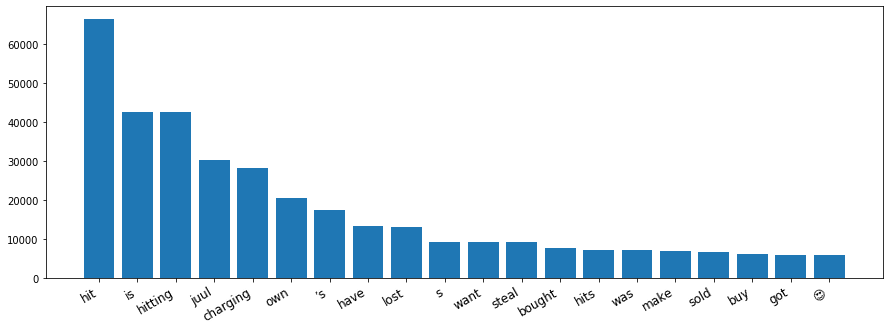

In [266]:
elements = 20
plt.figure(figsize=(15,5))
keys = sorted(juul_verbs,key=juul_verbs.__getitem__,reverse=True)[:elements]
values = [juul_verbs[ele] for ele  in sorted(juul_verbs,key=juul_verbs.__getitem__,reverse=True)][:elements]
plt.xticks(rotation=30,ha='right',fontsize=12)
plt.bar(keys,values)

In [ ]:
## find the sentiment of the link of aspect words with juul